In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import time
import seaborn as sns
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import numpy as np

In [116]:
def fuzhu(x):
#     hour, minute, sec = x.split('-')
    x = int(x[:2])
#     if 0<x <5:
#         d =  '1'
    if 5<=x<10:
        d =  '1'
    elif 10<=x<15:
        d = '2'
    elif 15<=x<20:
        d = '3'
    else:
        d = '0'
#     elif 45<=x<59:
#         d = '4'
    return d

In [117]:
time_label_dict = {'00-1':'20191231000000', '00-2':'20191231000500', '00-3':'20191231001000', '00-4':'20191231001500'}

In [142]:
def get_test_data(df=None):
    test_df = pd.read_csv('data/test_data.csv')
#     test_df = df[['grid_id', 'c_long', 'c_lat', 'time_label']].drop_duplicates()
#     test_df['flow'] = 0
#     test_df['time_label'] = test_df['time_label'].apply(lambda x:time_label_dict[x])
    return test_df

In [79]:
get_test_data()['datatim']

0      20191231000000
1      20191231000500
2      20191231001000
3      20191231000000
4      20191231000500
            ...      
253    20191231000500
254    20191231001000
255    20191231000000
256    20191231000500
257    20191231001000
Name: datatim, Length: 258, dtype: int64

In [141]:
test_df = get_test_data()
# test_df
test_df[test_df['datatim']!=20191231000000].to_csv('data/test_data.csv', index=False)

In [66]:
get_test_data(df).to_csv('data/test_data.csv', index=False)

In [102]:
df_weather = pd.read_csv('./data/weather.txt', names = ['datetim', 'loc', 'low_tem', 'high_tem', 'wea'])
# print(df_weather)
# print(df_weather['wea'].str.contains('雨'))
df_weather['is_rainy'] = df_weather['wea'].str.contains('雨').astype(int)
df_weather['datetim'] = df_weather['datetim'].astype(str)
weather_dict = {w:i for i, w in enumerate(df_weather['wea'].unique())}
df_weather['wea'] = df_weather['wea'].map(weather_dict)
df_weather

datetim loc  low_tem  high_tem  wea  is_rainy
0   20191001  梅县       22        34    0         0
1   20191002  梅县       22        35    0         0
2   20191003  梅县       22        34    0         0
3   20191004  梅县       21        34    0         0
4   20191005  梅县       22        35    1         0
..       ...  ..      ...       ...  ...       ...
87  20191227  梅县        9        19    1         0
88  20191228  梅县        6        20    3         0
89  20191229  梅县       10        20    6         0
90  20191230  梅县       15        24    6         0
91  20191231  梅县       13        19    5         0

[92 rows x 6 columns]

In [8]:
# weekends = {10:[3,4,10,11,17,18,24,25,31], 11:[1,7,8,14,15,21,22,28,29], 12:[5,6, 12,13,19,20,26,27]}
weekends = {10:[5,6,12,13,19,20,26,27], 11:[2,3,9,10,16,17,23,24,30], 12:[1,7,8, 14,15,21,22,28,29]}
weekends = [f"{month}-{str(day).zfill(2)}" for month, day_list in weekends.items() for day in day_list]
weekends

['10-05',
 '10-06',
 '10-12',
 '10-13',
 '10-19',
 '10-20',
 '10-26',
 '10-27',
 '11-02',
 '11-03',
 '11-09',
 '11-10',
 '11-16',
 '11-17',
 '11-23',
 '11-24',
 '11-30',
 '12-01',
 '12-07',
 '12-08',
 '12-14',
 '12-15',
 '12-21',
 '12-22',
 '12-28',
 '12-29']

In [98]:
df_weather

datetim loc  low_tem  high_tem  wea  is_rainy
0   20191001  梅县       22        34    0         0
1   20191002  梅县       22        35    0         0
2   20191003  梅县       22        34    0         0
3   20191004  梅县       21        34    0         0
4   20191005  梅县       22        35    1         0
..       ...  ..      ...       ...  ...       ...
86  20191226  梅县       12        21    3         0
87  20191227  梅县        9        19    1         0
88  20191228  梅县        6        20    3         0
89  20191229  梅县       10        20    6         0
90  20191230  梅县       15        24    6         0

[91 rows x 6 columns]

In [120]:
df = pd.read_csv("E:/all_project/race\zhuhai/data\网格人流预测.txt",sep='|')

In [121]:
df[df['datatim'].str.startswith('20191231')]['datatim'].unique()

array(['20191231000000'], dtype=object)

In [143]:
df = pd.read_csv("E:/all_project/race\zhuhai/data\网格人流预测.txt",sep='|')
test_df = get_test_data()
test_df['datatim'] = test_df['datatim'].astype(str)
# print(test_df)
# print(df)
df = pd.concat([df, test_df], axis=0)
# print(df)
df['datetime'] = df['datatim'].apply(lambda x:x[:8])
df = df.merge(df_weather, left_on='datetime', right_on='datetim')
df['datatim'] = df['datatim'].apply(lambda x:f"{x[4:6]},{x[6:8]},{x[8:10]},{x[10:]}")
df = pd.concat([df['datatim'].str.split(',', expand=True), df],axis=1)
df = df.rename(columns={0:'month', 1:'day', 2:'hour', 3:'time', 'cnt':'flow'})
df = df[df['month']!='']

df['time'] = df['time'].apply(fuzhu)
df = df[df['time'].isin(['1','2','3'])]
# print(df)
df['time_label_all'] = df['month'] + '-' + df['day'] +'-' +df['hour'] +'-' +df['time']
df['time_label'] = df['time_label_all'].apply(lambda x:x[6:])
df['is_weekend'] = (df['month'] + '-' + df['day']).isin(weekends).astype(int)
df = df.groupby(['is_rainy','time_label', 'grid_id', 'c_long', 'c_lat', 'time_label_all', 'is_weekend', 'day', 'month', 'low_tem', 'high_tem', 'wea']).sum()['flow'].reset_index().sort_values(['grid_id', 'month', 'day'])
df['day'] = df['day'].astype(int)
df['month'] = df['month'].astype(int)
df['hour'] = df['time_label'].str.split('-', expand=True)[0].astype(int)
df= df['hour'] = df[df['hour']==0]
df_save= df.copy()
df

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


is_rainy time_label  grid_id      c_long      c_lat time_label_all  \
0             0       00-1     4808  116.344597  24.650400     10-01-00-1   
7648          0       00-2     4808  116.344597  24.650400     10-01-00-2   
15297         0       00-3     4808  116.344597  24.650400     10-01-00-3   
1             0       00-1     4808  116.344597  24.650400     10-02-00-1   
7649          0       00-2     4808  116.344597  24.650400     10-02-00-2   
...         ...        ...      ...         ...        ...            ...   
15295         0       00-2     5674  116.425599  24.784201     12-30-00-2   
22943         0       00-3     5674  116.425599  24.784201     12-30-00-3   
7647          0       00-1     5674  116.425599  24.784201     12-31-00-1   
15296         0       00-2     5674  116.425599  24.784201     12-31-00-2   
22944         0       00-3     5674  116.425599  24.784201     12-31-00-3   

       is_weekend  day  month  low_tem  high_tem  wea  flow hour  
0               0    1     10       22        34    0  6161    0  
7648            0    1     10       22        34    0  6144    0  
15297           0    1     10       22        34    0  6127    0  
1               0    2     10       22        35    0  5892    0  
7649            0    2     10       22        35    0  5917    0  
...           ...  ...    ...      ...       ...  ...   ...  ...  
15295           0   30     12       15        24    6   455    0  
22943           0   30     12       15        24    6   455    0  
7647            0   31     12       13        19    5     0    0  
15296           0   31     12       13        19    5     0    0  
22944           0   31     12       13        19    5     0    0  

[23719 rows x 14 columns]

In [83]:
test_df

grid_id      c_long      c_lat         datatim  cnt
0       4808  116.344597  24.650400  20191231000000    0
1       4808  116.344597  24.650400  20191231000500    0
2       4808  116.344597  24.650400  20191231001000    0
3       4809  116.353600  24.650400  20191231000000    0
4       4809  116.353600  24.650400  20191231000500    0
..       ...         ...        ...             ...  ...
253     5673  116.416604  24.784201  20191231000500    0
254     5673  116.416604  24.784201  20191231001000    0
255     5674  116.425599  24.784201  20191231000000    0
256     5674  116.425599  24.784201  20191231000500    0
257     5674  116.425599  24.784201  20191231001000    0

[258 rows x 5 columns]

In [82]:
df.sort_values(['grid_id', 'month', 'day'])

is_rainy time_label  grid_id      c_long      c_lat time_label_all  \
0             0       00-1     4808  116.344597  24.650400     10-01-00-1   
7562          0       00-2     4808  116.344597  24.650400     10-01-00-2   
15124         0       00-3     4808  116.344597  24.650400     10-01-00-3   
1             0       00-1     4808  116.344597  24.650400     10-02-00-1   
7563          0       00-2     4808  116.344597  24.650400     10-02-00-2   
...         ...        ...      ...         ...        ...            ...   
15122         0       00-2     5674  116.425599  24.784201     12-29-00-2   
22685         0       00-3     5674  116.425599  24.784201     12-29-00-3   
7561          0       00-1     5674  116.425599  24.784201     12-30-00-1   
15123         0       00-2     5674  116.425599  24.784201     12-30-00-2   
22686         0       00-3     5674  116.425599  24.784201     12-30-00-3   

       is_weekend  day  month  low_tem  high_tem  wea  flow hour  
0               0    1     10       22        34    0  6046    0  
7562            0    1     10       22        34    0  6161    0  
15124           0    1     10       22        34    0  6144    0  
1               0    2     10       22        35    0  5915    0  
7563            0    2     10       22        35    0  5892    0  
...           ...  ...    ...      ...       ...  ...   ...  ...  
15122           1   29     12       10        20    6   488    0  
22685           1   29     12       10        20    6   499    0  
7561            0   30     12       15        24    6   443    0  
15123           0   30     12       15        24    6   449    0  
22686           0   30     12       15        24    6   455    0  

[23461 rows x 14 columns]

## 热力图（所有区域）

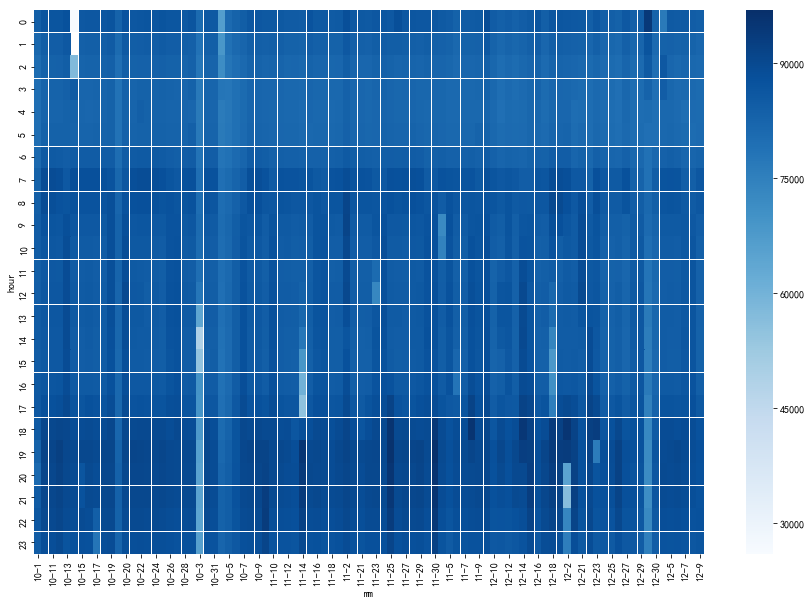

In [140]:
df2 = df.copy()
df2 = df2.groupby(['day', 'month', 'hour', 'grid_id']).sum().reset_index()
# df2.index = df2['hour']
df2['mm'] = df2['month'].astype(str) + '-' + df2['day'].astype(str)
df2 = df2[['flow', 'grid_id', 'hour', 'mm']]
df2 = df2.sort_values(['grid_id', 'mm'])
plt.figure(figsize=(15, 10))
sns.heatmap(pd.pivot_table(df2,values='flow', index='hour', columns='mm'), cmap="Blues", linewidths = 0.001)

In [17]:
df['grid_id'].unique()

array([4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4876,
       4877, 4878, 4879, 4880, 4881, 4882, 4883, 4939, 4940, 4941, 4942,
       4943, 4944, 4945, 4946, 4999, 5000, 5001, 5002, 5003, 5004, 5056,
       5057, 5058, 5059, 5060, 5111, 5112, 5113, 5114, 5163, 5164, 5165,
       5166, 5167, 5216, 5217, 5218, 5219, 5220, 5221, 5268, 5269, 5270,
       5271, 5272, 5273, 5274, 5320, 5321, 5322, 5323, 5372, 5373, 5375,
       5376, 5377, 5424, 5425, 5426, 5429, 5430, 5480, 5481, 5530, 5623,
       5624, 5625, 5626, 5627, 5670, 5671, 5672, 5673, 5674], dtype=int64)

In [18]:
len(df['grid_id'].unique())

86

In [150]:
# weather_dict
reverse_weather_dict = {v:k for k, v in weather_dict.items()}
day_wea_dict = {i.datetim:i.wea for _,i in df_weather.iterrows()}
day_wea_dict = {k:reverse_weather_dict[v] for k,v in day_wea_dict.items()}
day_wea_dict

{'20191001': '晴',
 '20191002': '晴',
 '20191003': '晴',
 '20191004': '晴',
 '20191005': '晴~多云',
 '20191006': '多云',
 '20191007': '多云~晴',
 '20191008': '多云~晴',
 '20191009': '多云~晴',
 '20191010': '多云~晴',
 '20191011': '晴~多云',
 '20191012': '多云',
 '20191013': '多云~雨',
 '20191014': '多云~阴',
 '20191015': '多云~晴',
 '20191016': '晴~多云',
 '20191017': '晴',
 '20191018': '晴',
 '20191019': '晴~多云',
 '20191020': '晴~多云',
 '20191021': '晴~多云',
 '20191022': '晴~多云',
 '20191023': '多云~晴',
 '20191024': '多云~晴',
 '20191025': '多云~阴',
 '20191026': '多云~阴',
 '20191027': '多云~阴',
 '20191028': '阴~多云',
 '20191029': '晴~阴',
 '20191030': '多云~阴',
 '20191031': '多云~晴',
 '20191101': '多云~晴',
 '20191102': '多云~晴',
 '20191103': '晴~阴',
 '20191104': '晴',
 '20191105': '晴~多云',
 '20191106': '晴',
 '20191107': '晴~多云',
 '20191108': '晴~多云',
 '20191109': '晴~多云',
 '20191110': '晴~阴',
 '20191111': '晴~多云',
 '20191112': '晴',
 '20191113': '晴~多云',
 '20191114': '晴~多云',
 '20191115': '晴',
 '20191116': '晴',
 '20191117': '晴~多云',
 '20191118': '晴~多云',
 '20191119'

## 每个区域每天的人数


D:\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


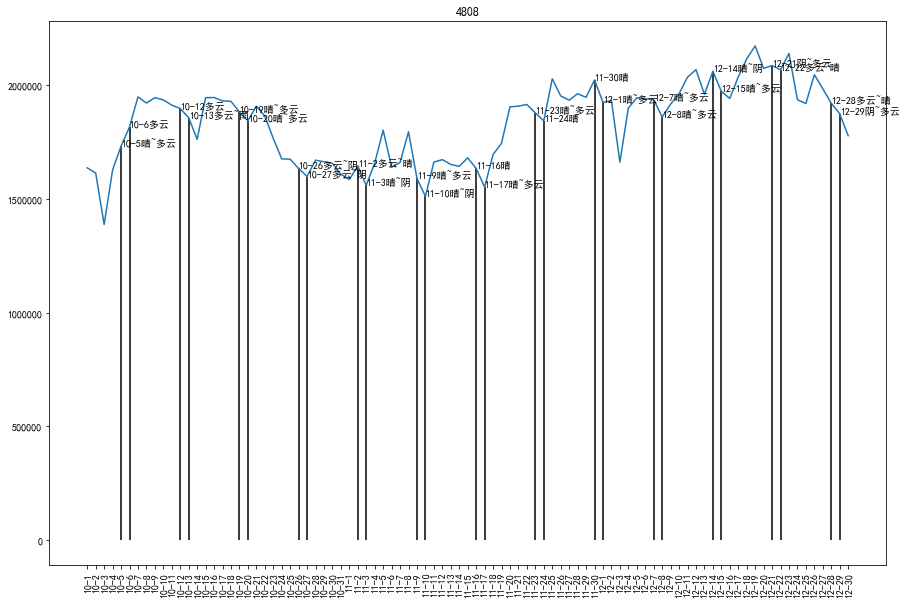

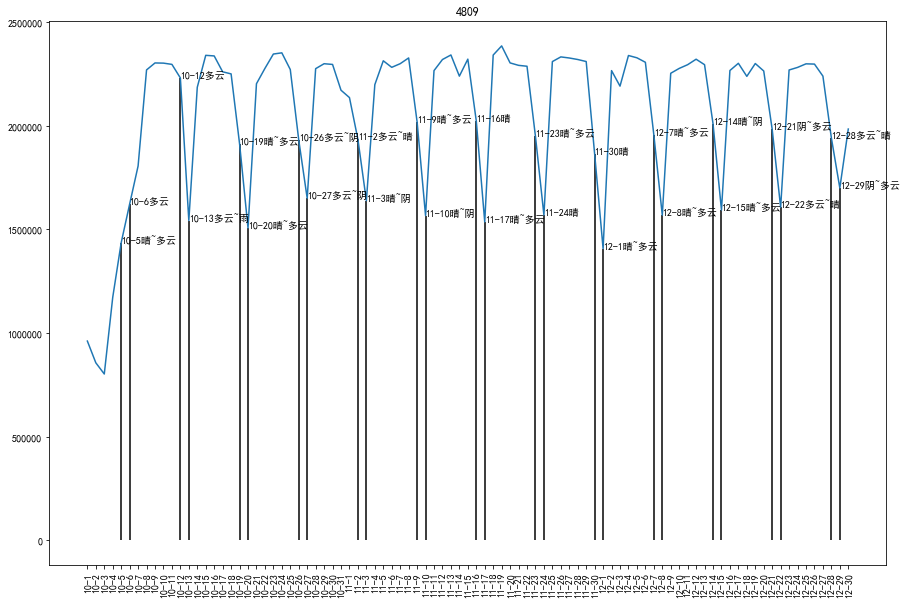

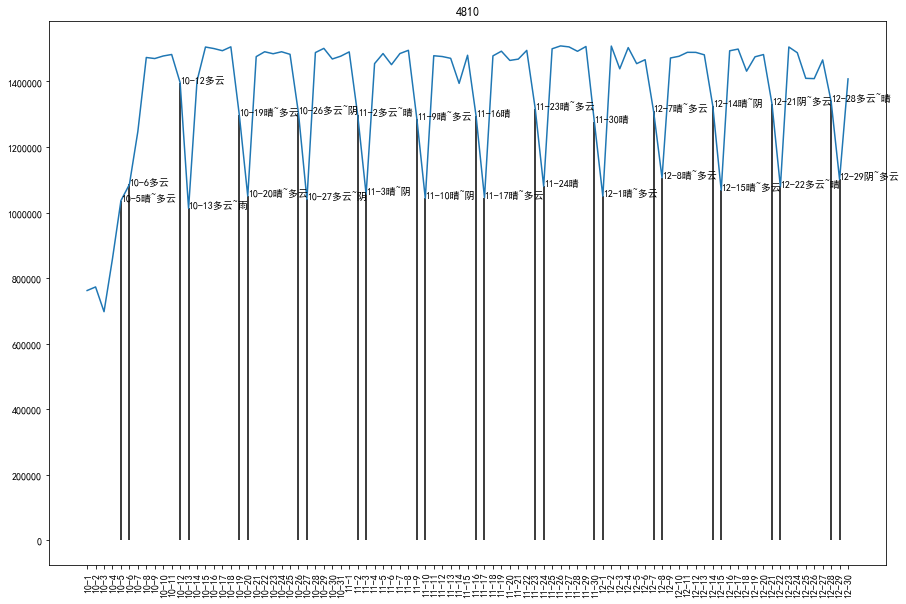

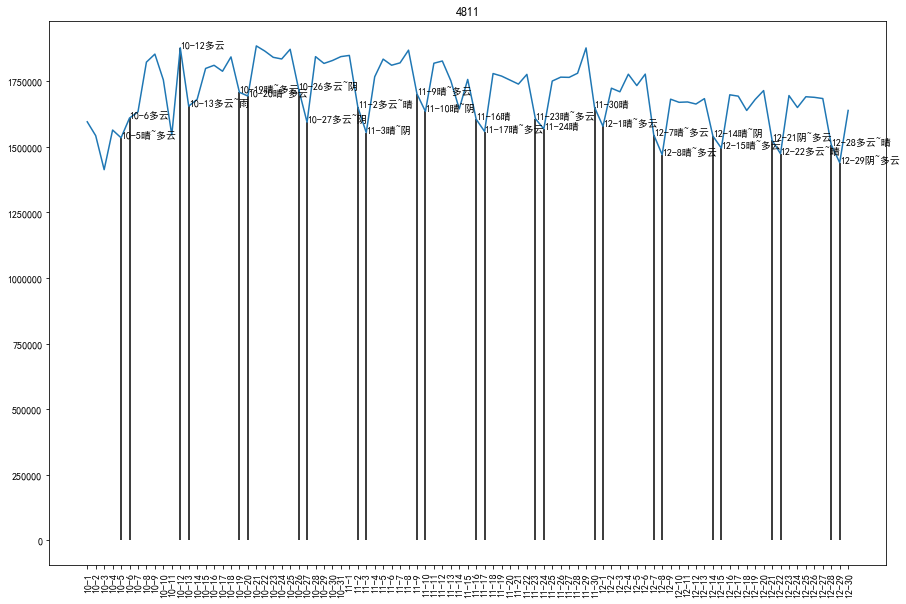

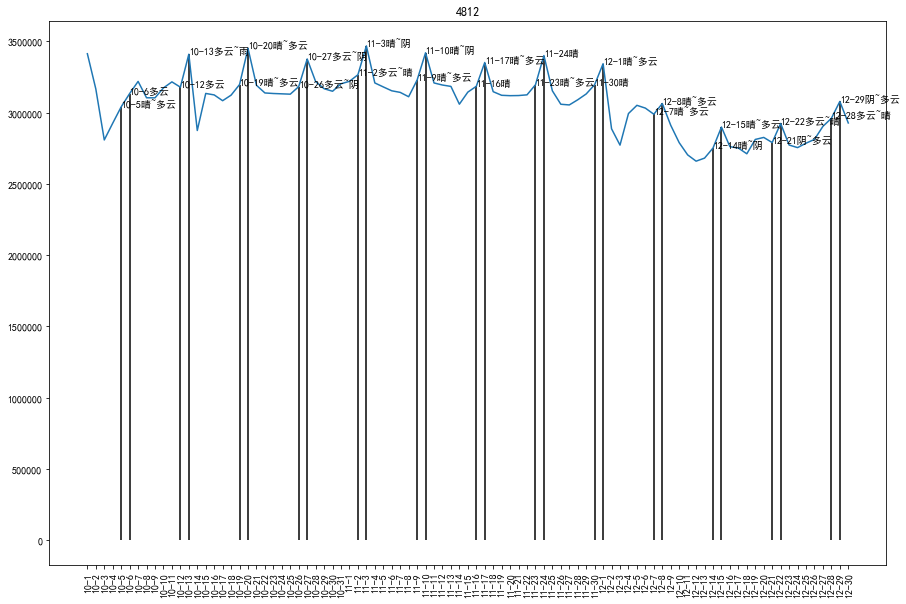

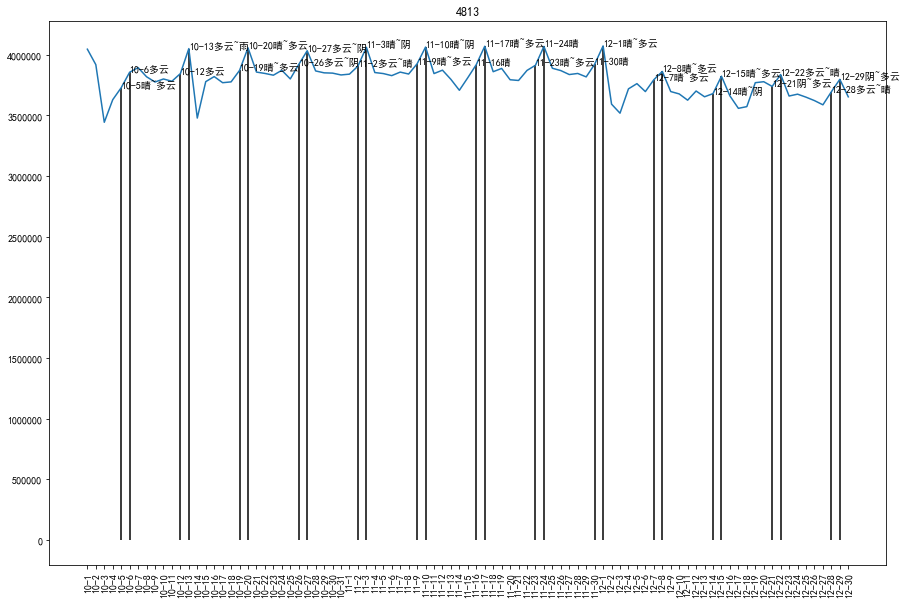

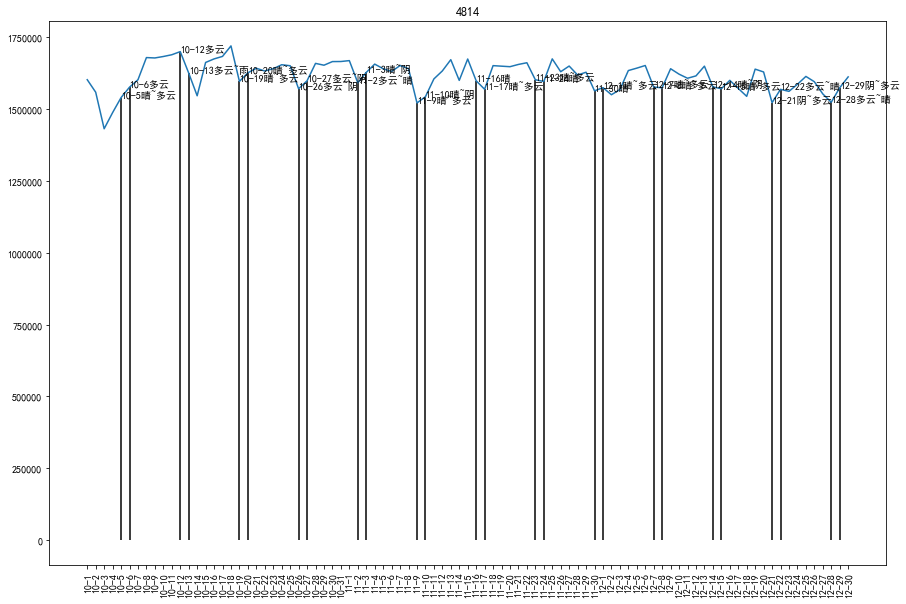

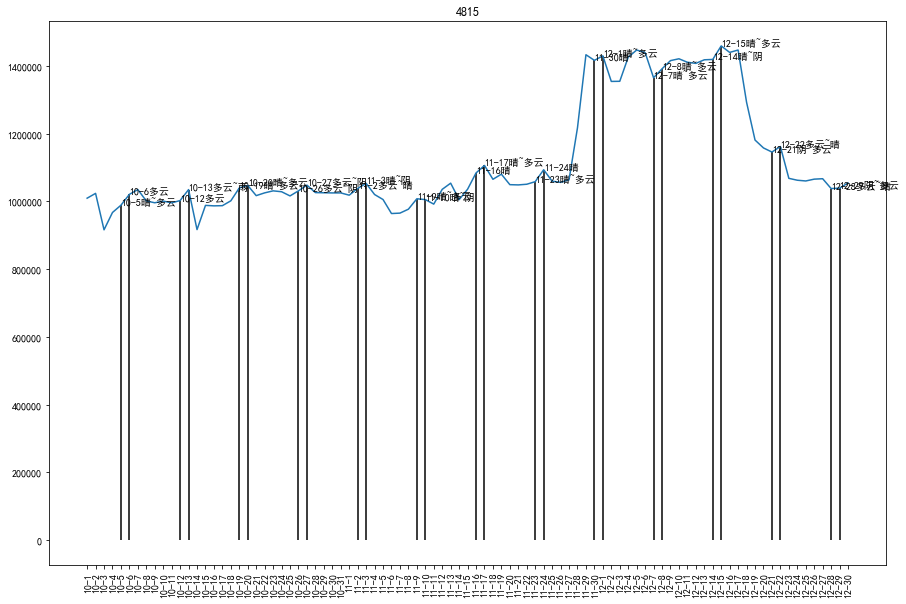

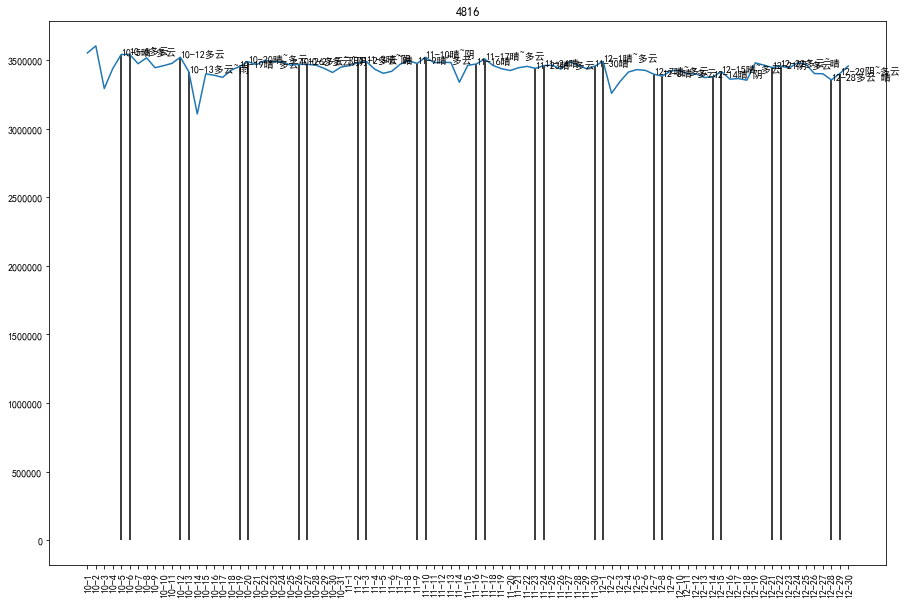

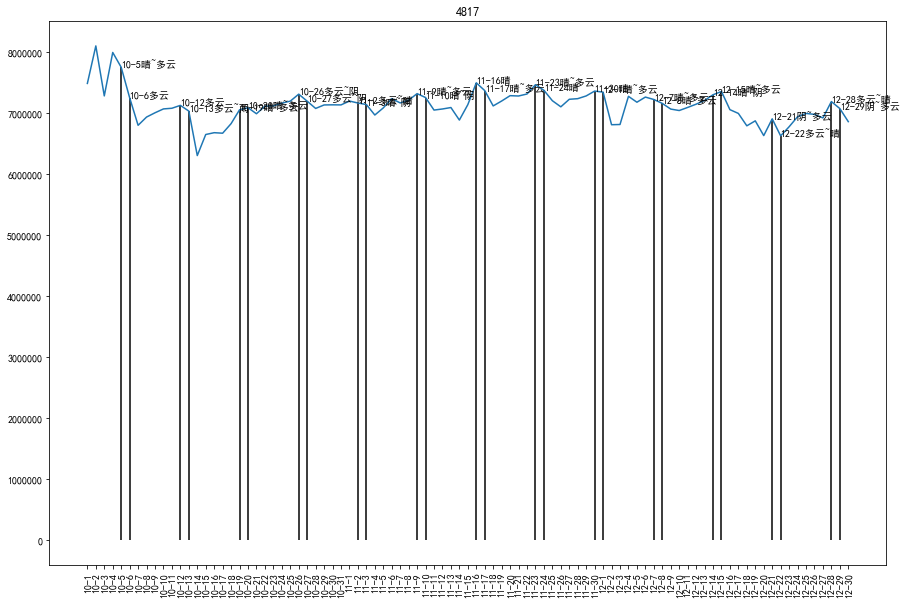

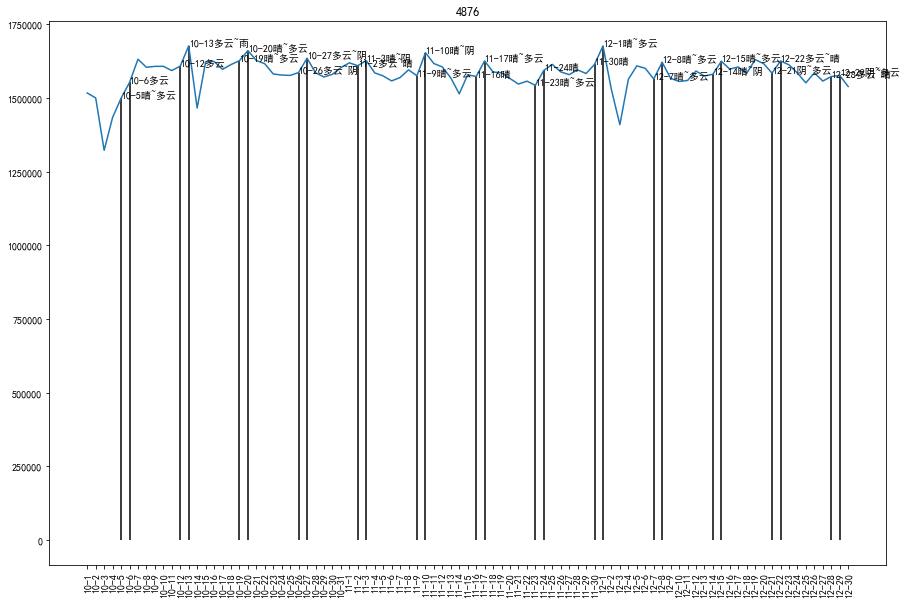

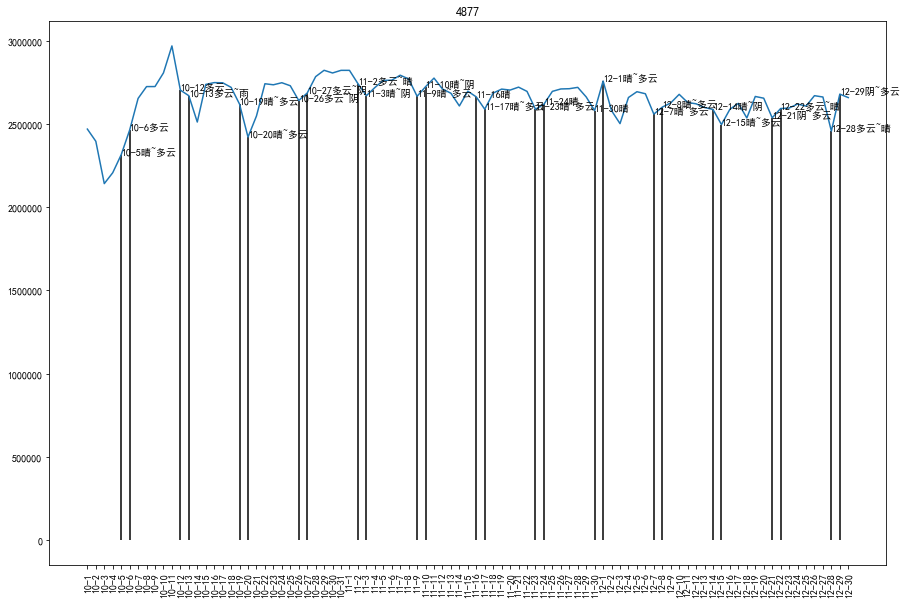

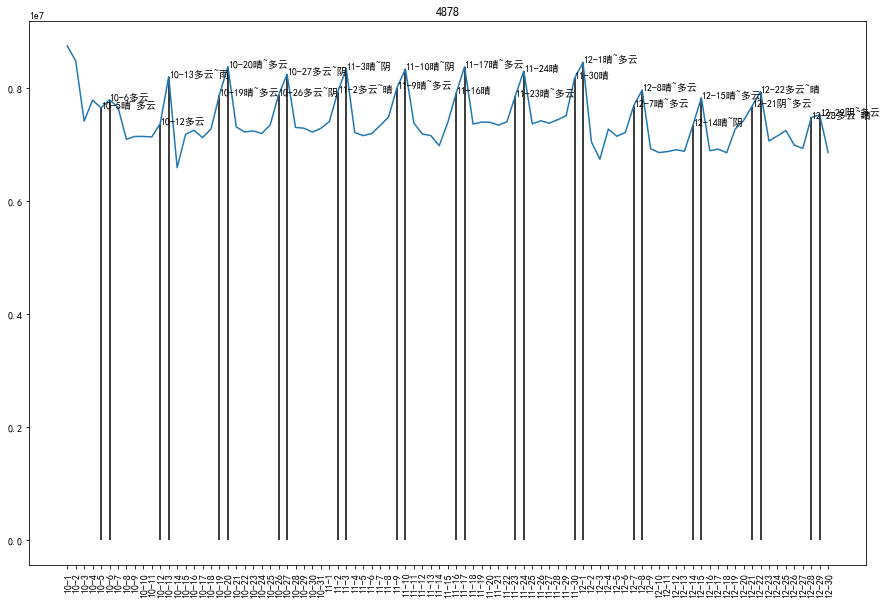

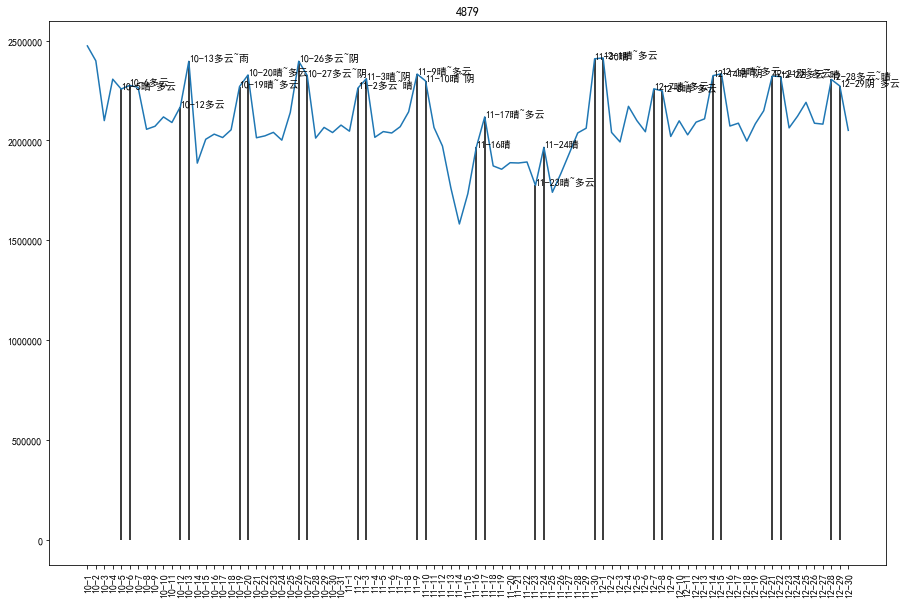

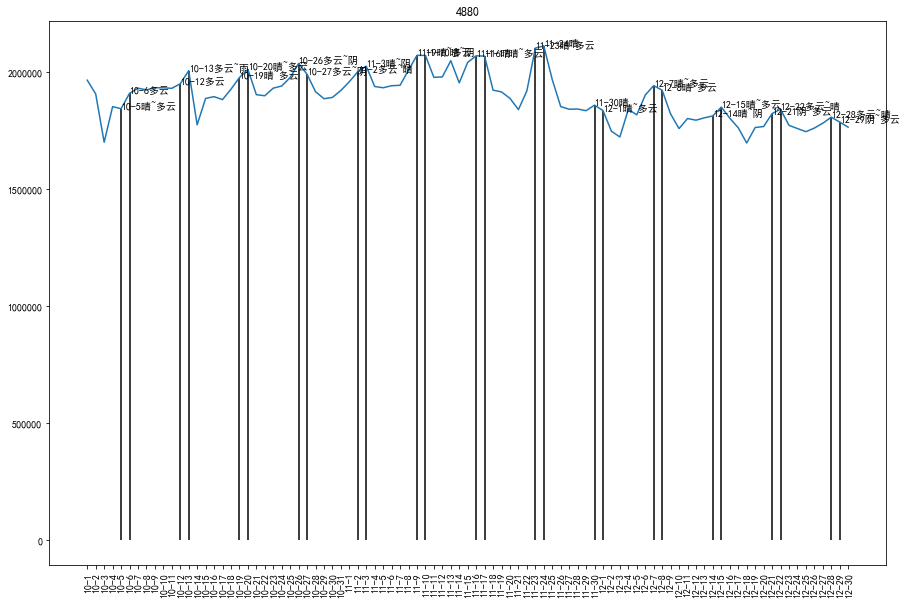

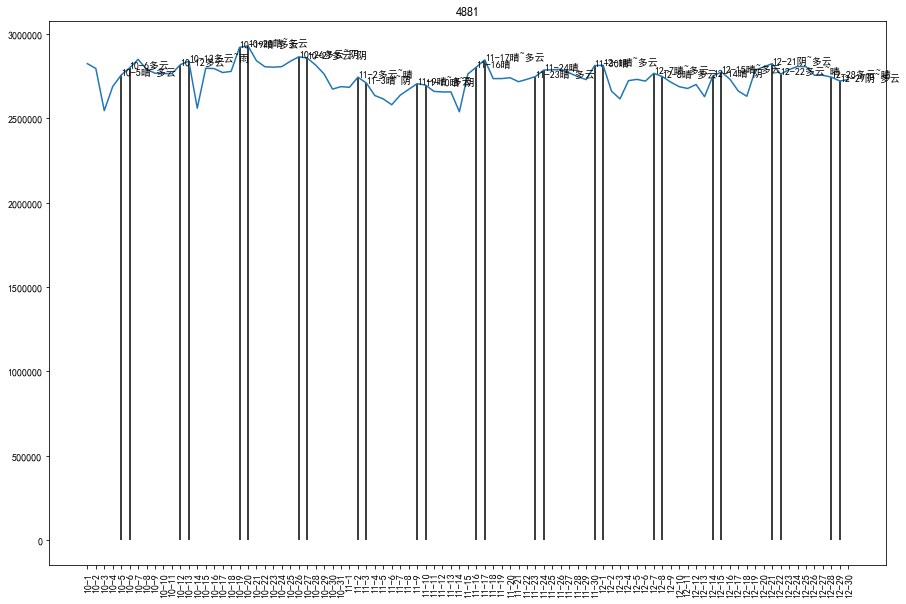

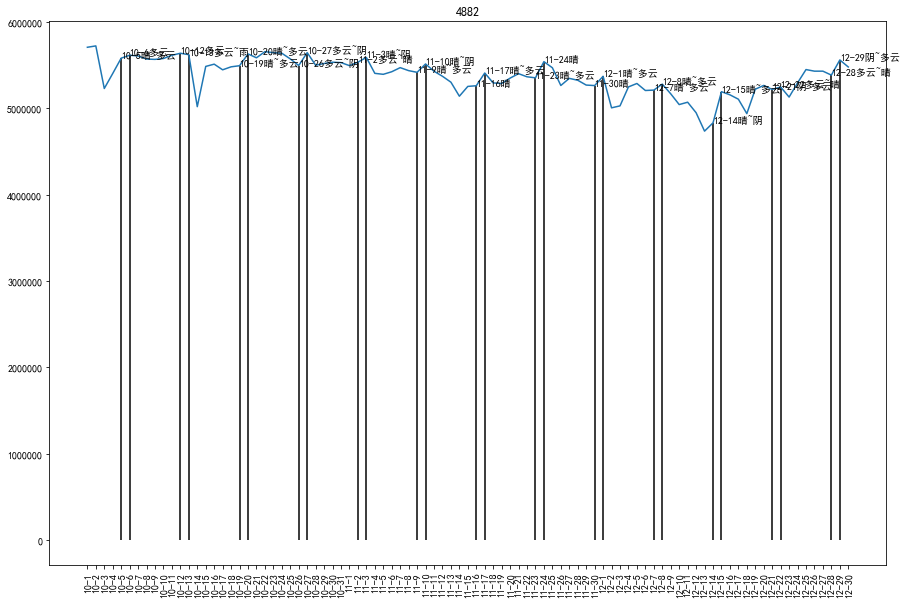

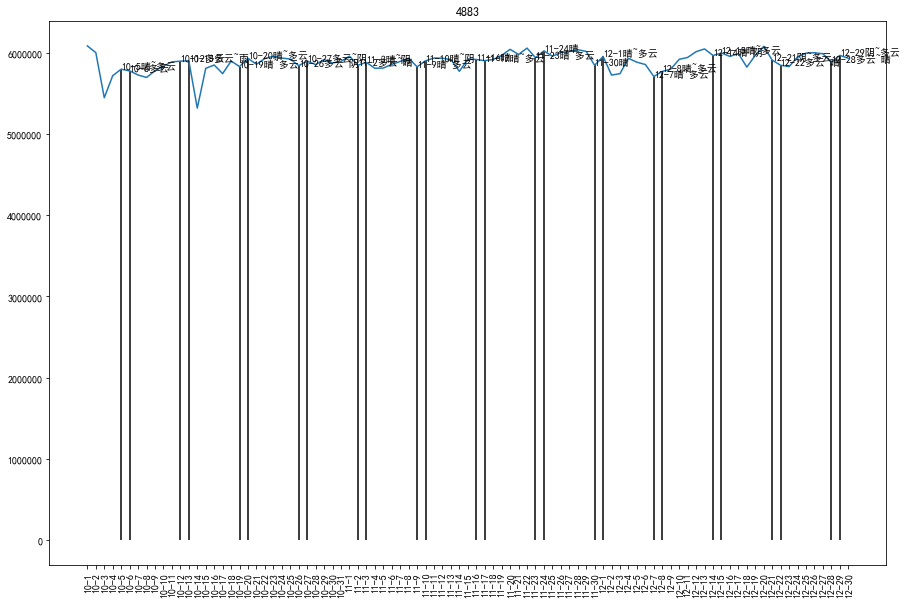

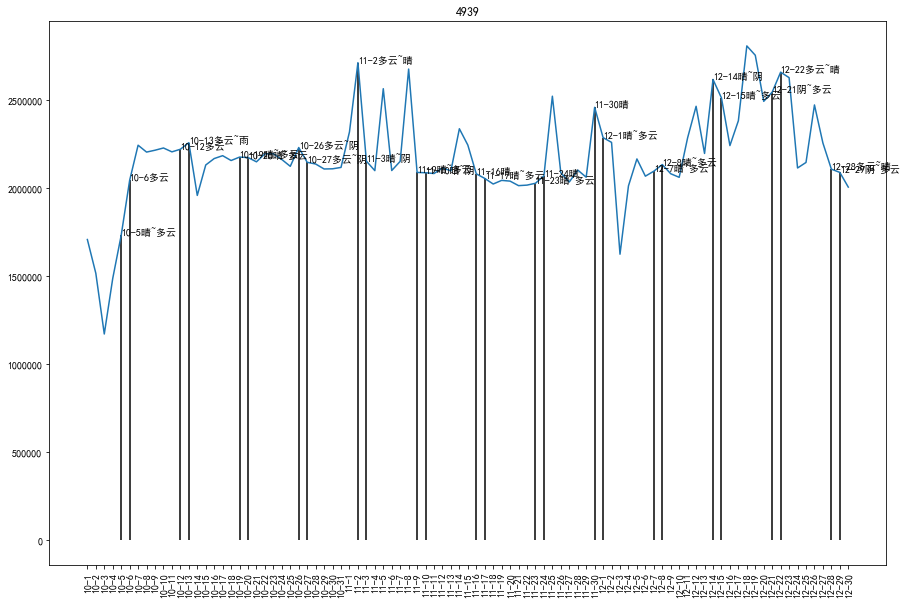

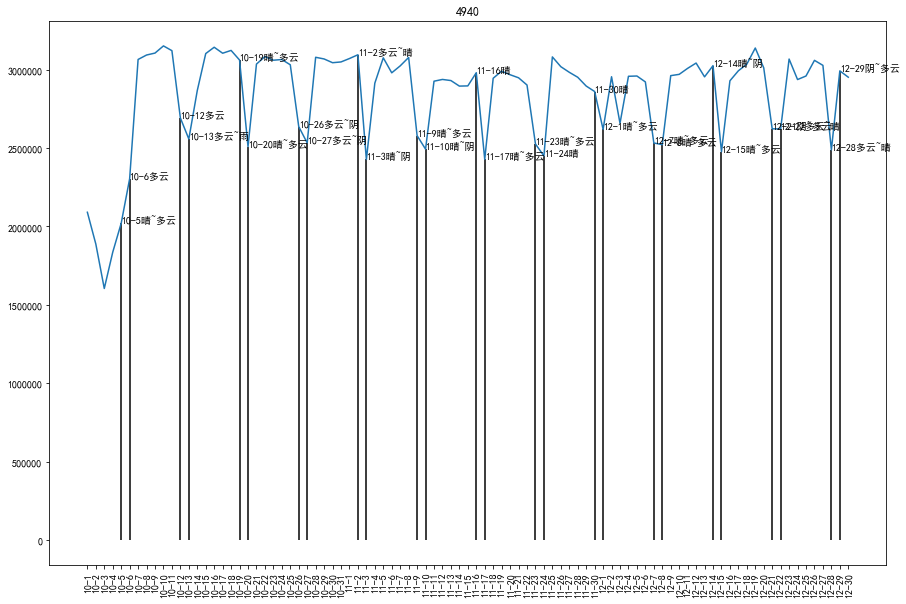

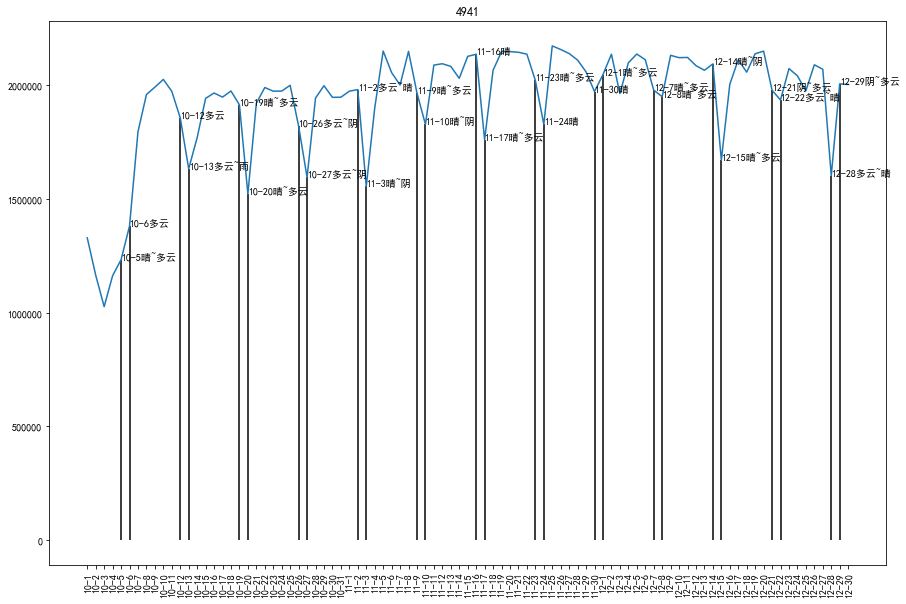

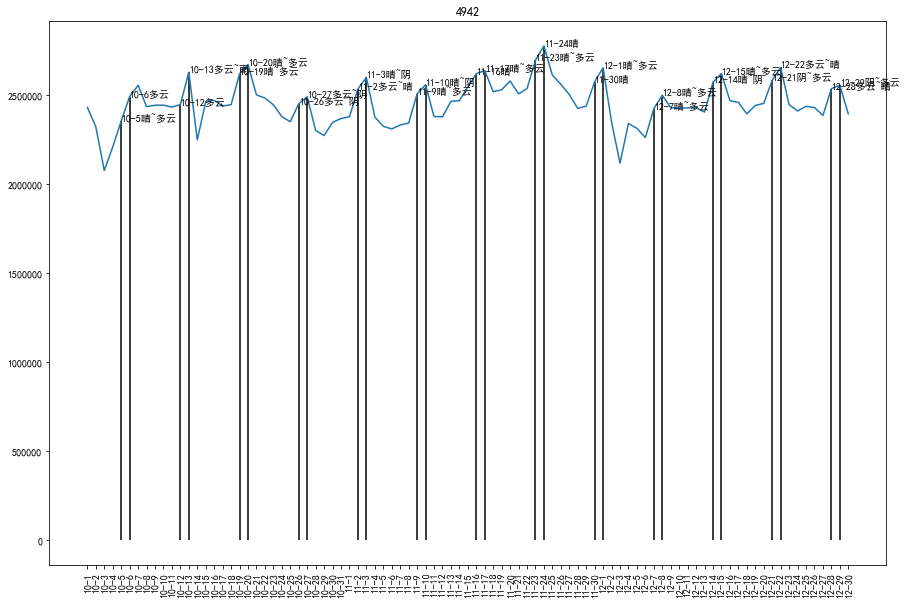

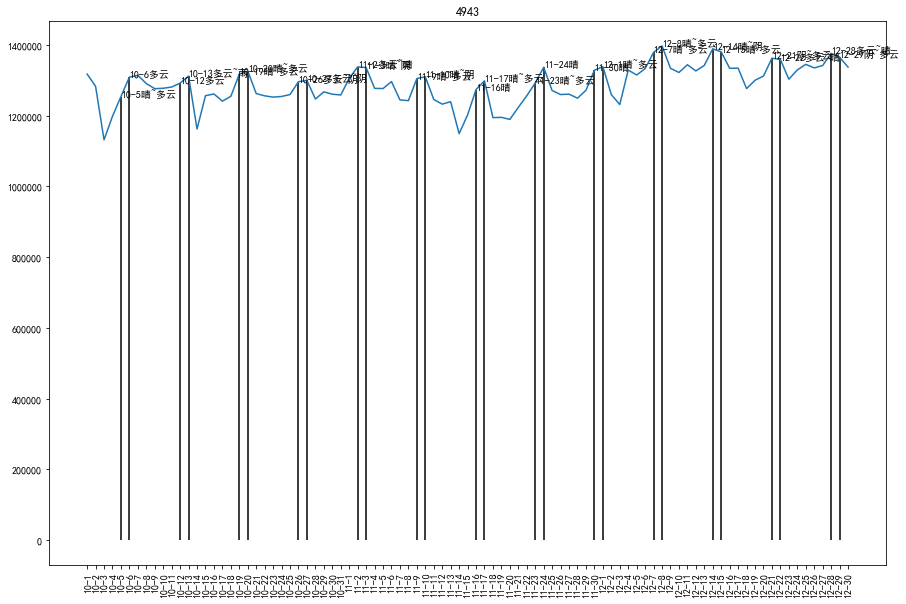

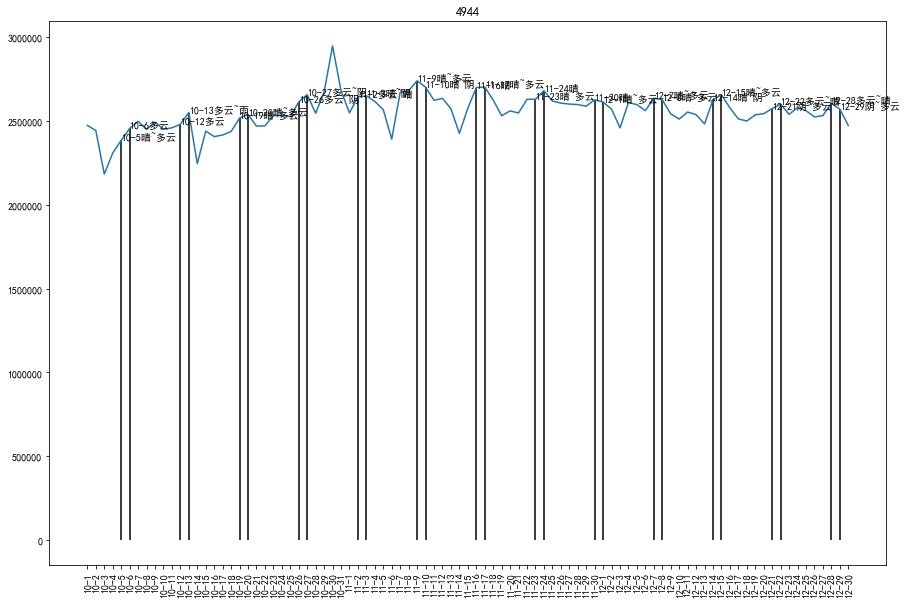

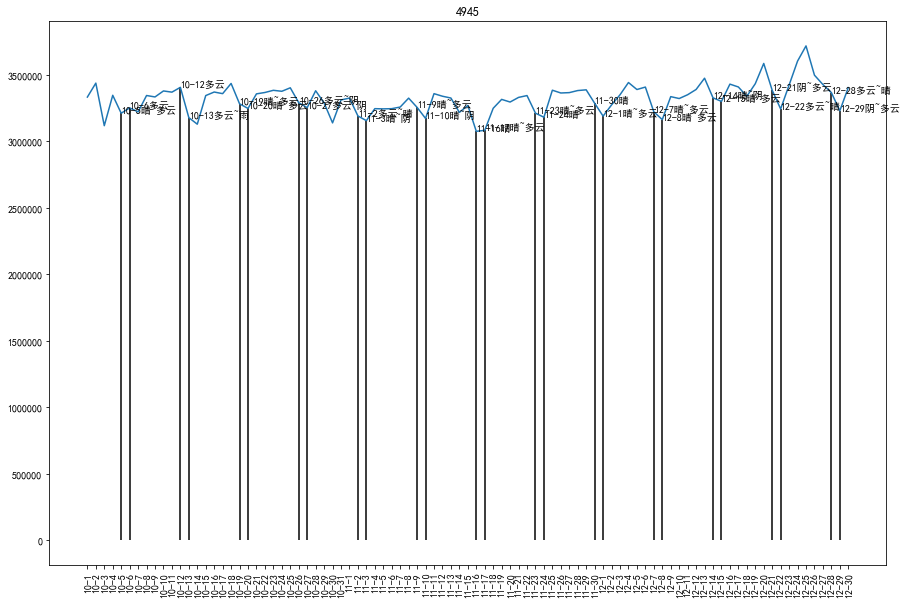

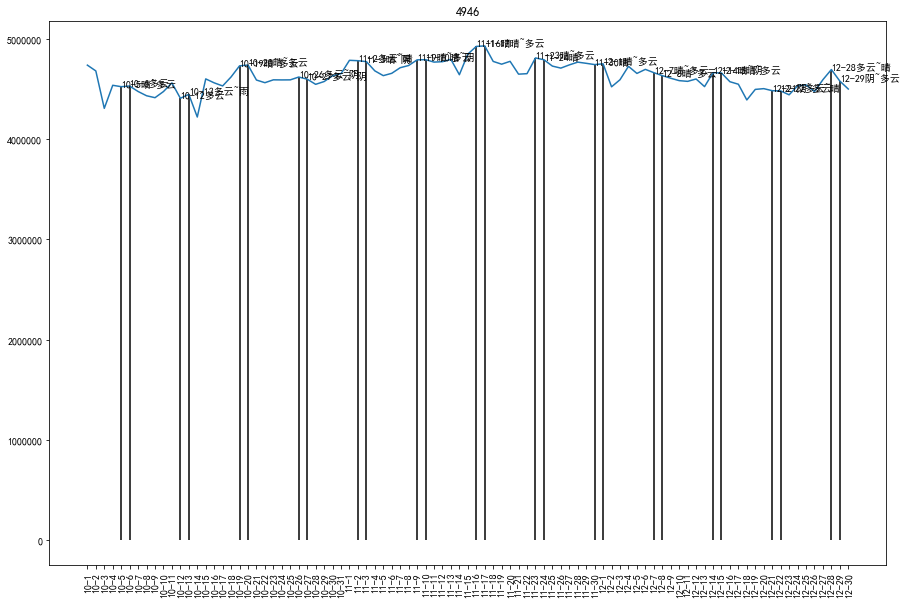

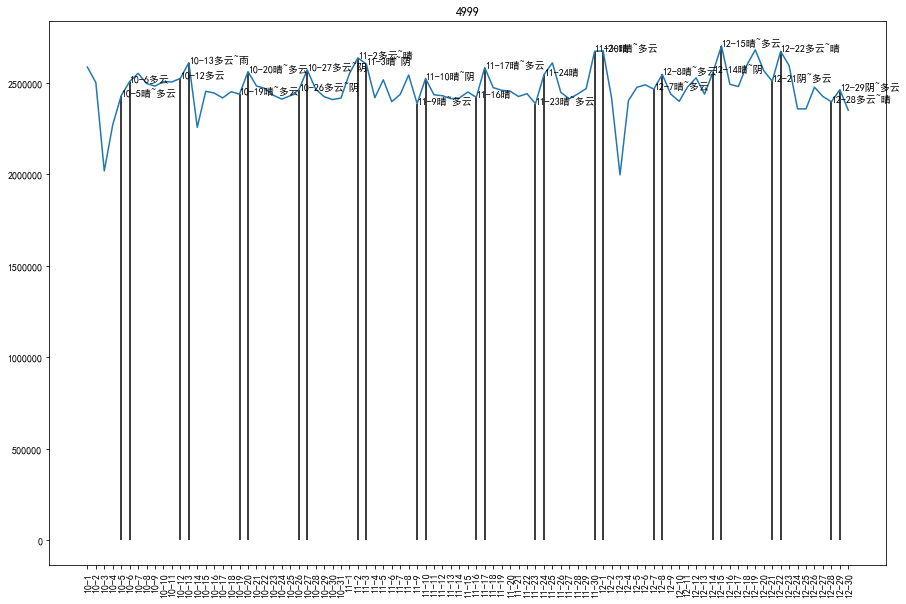

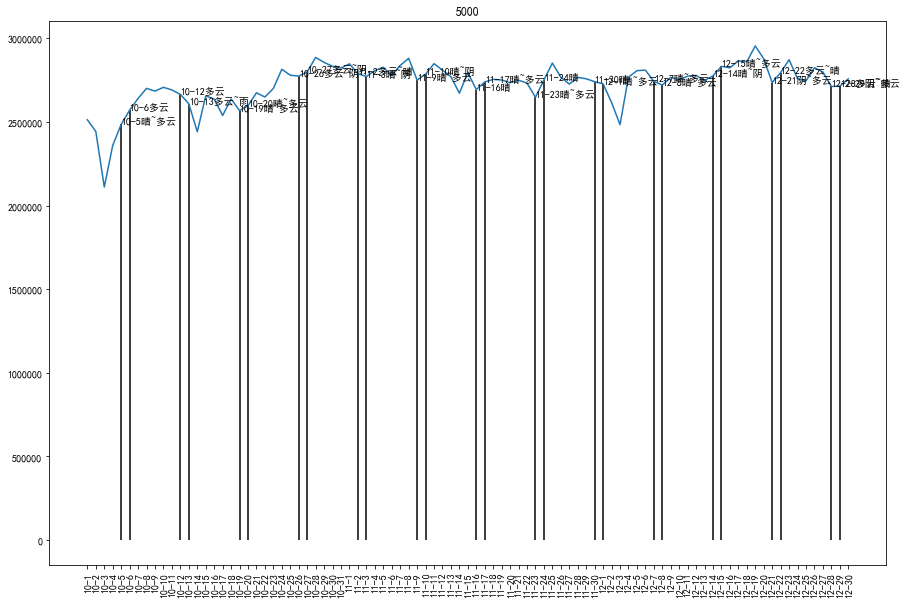

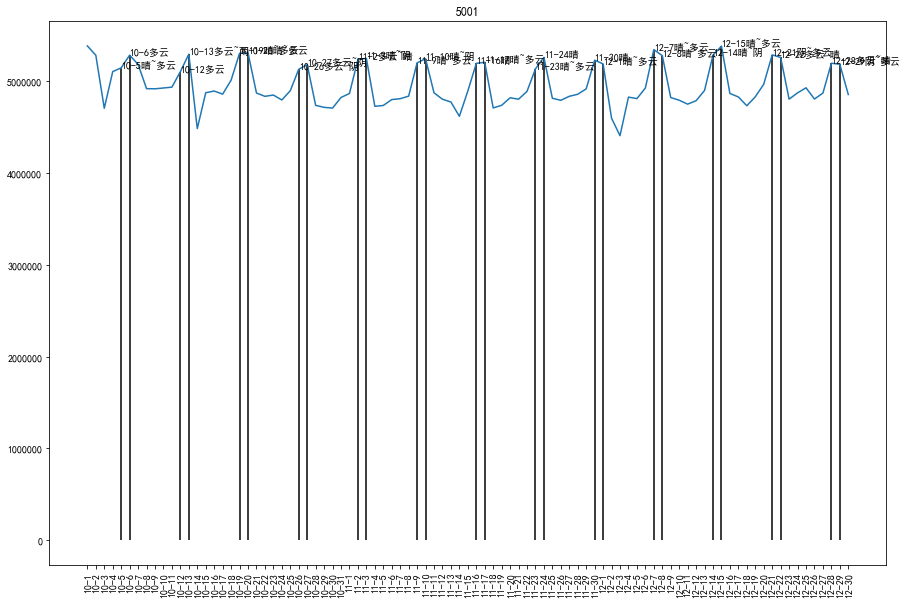

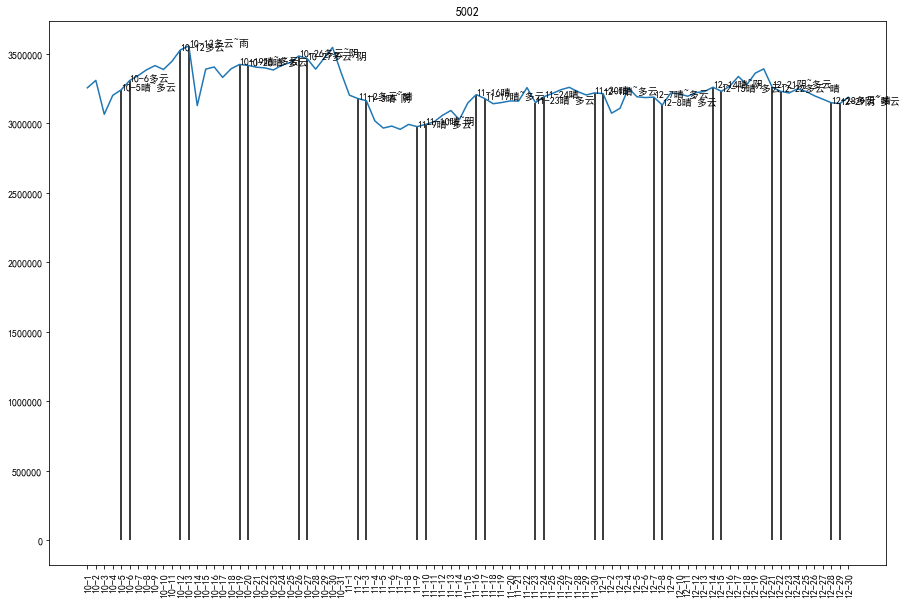

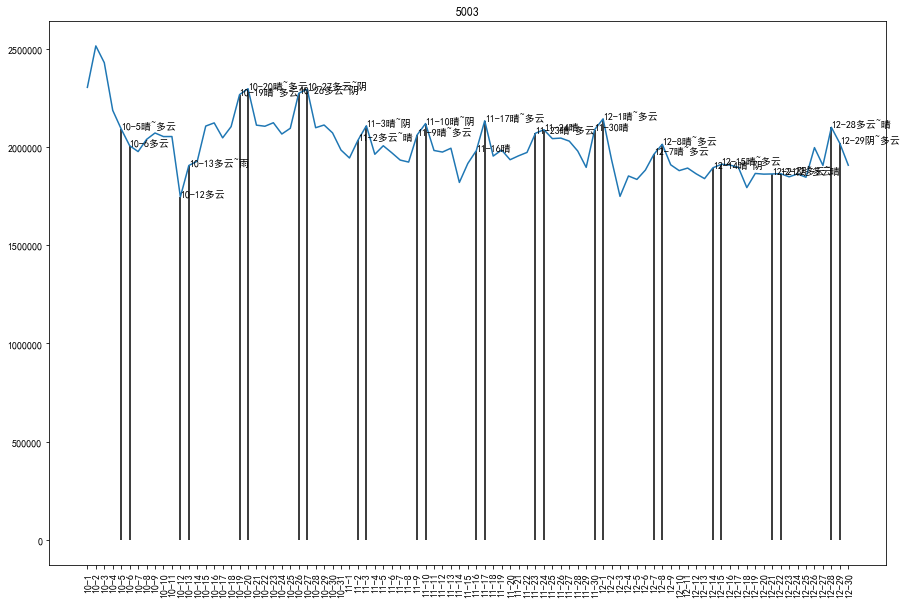

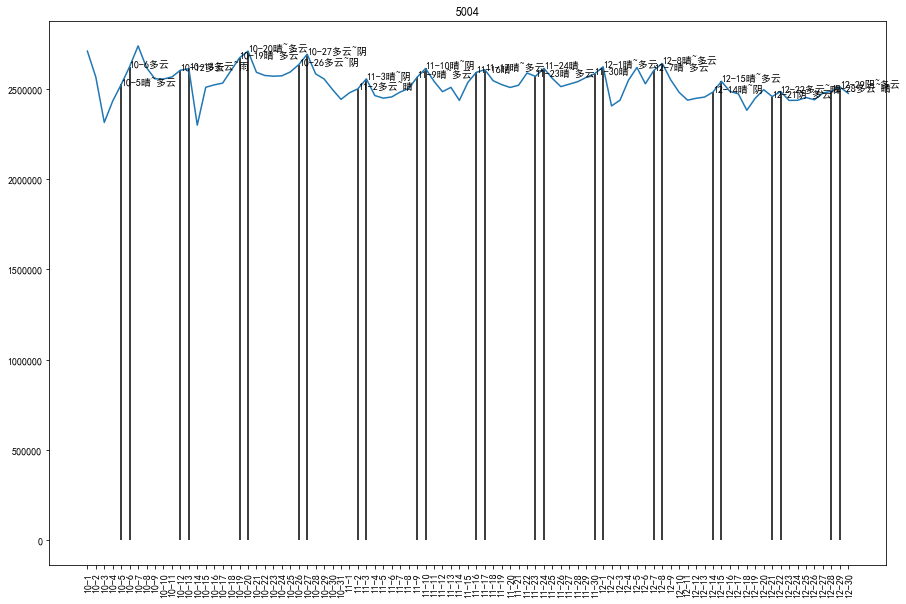

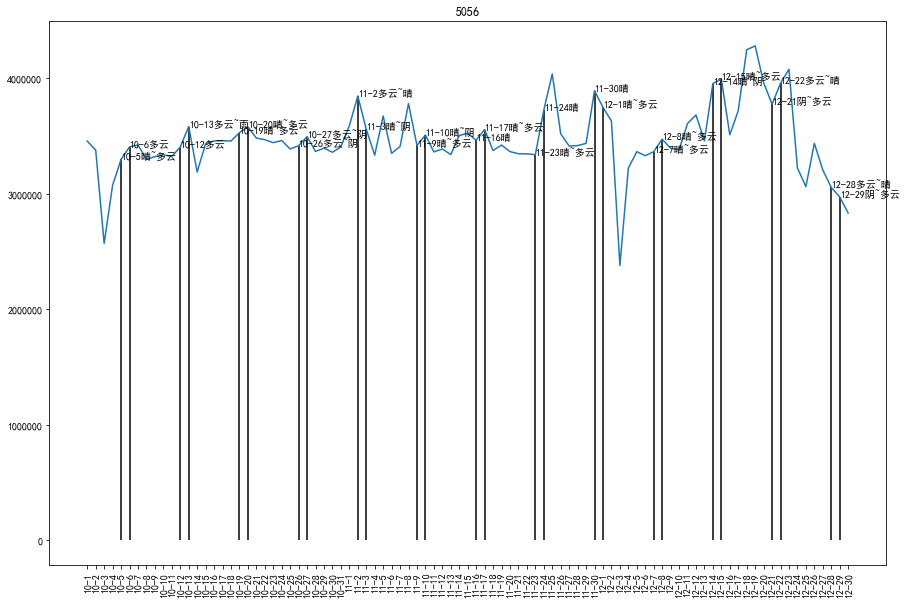

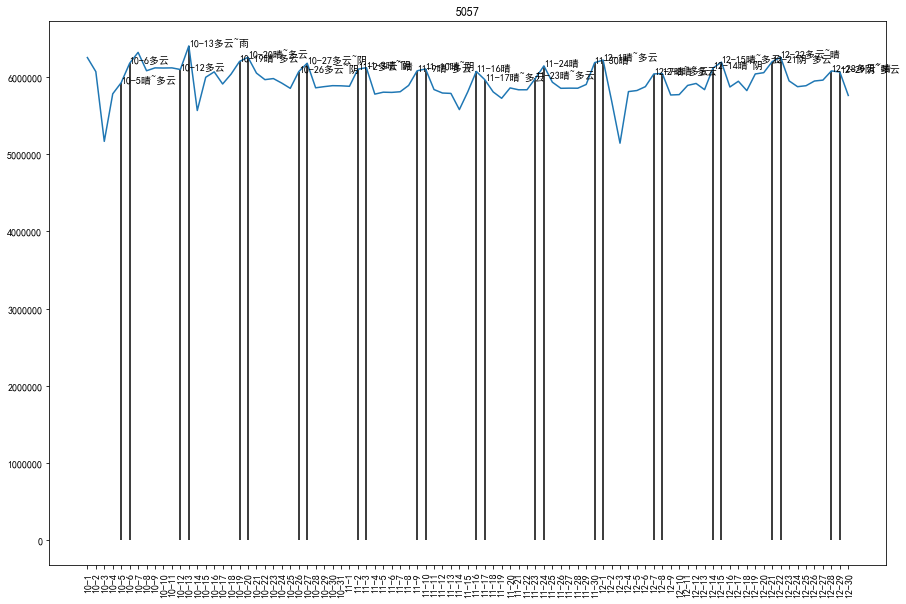

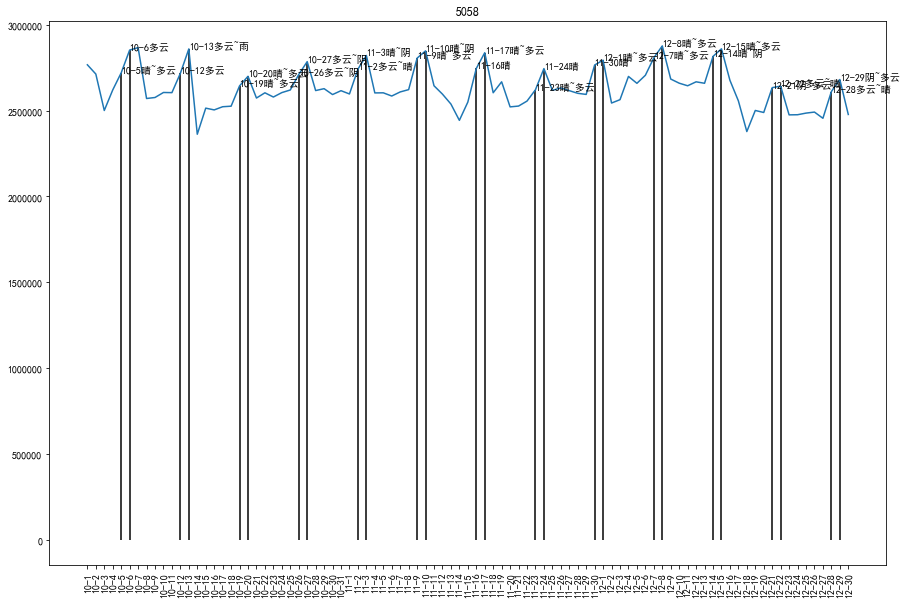

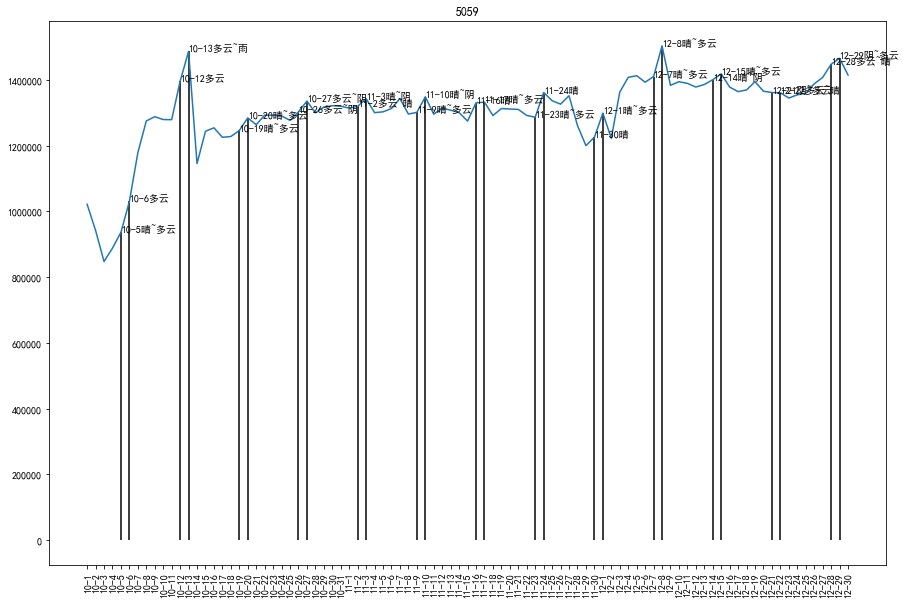

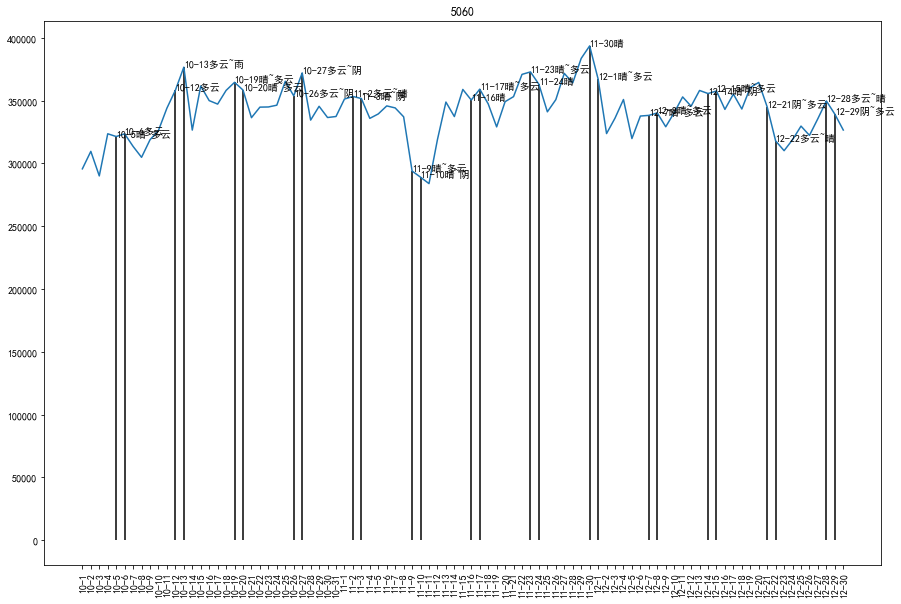

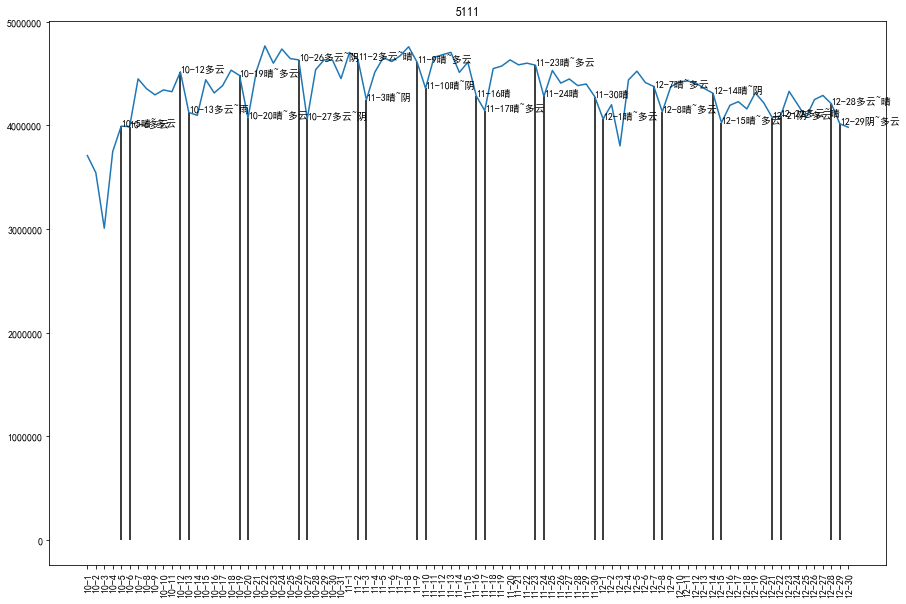

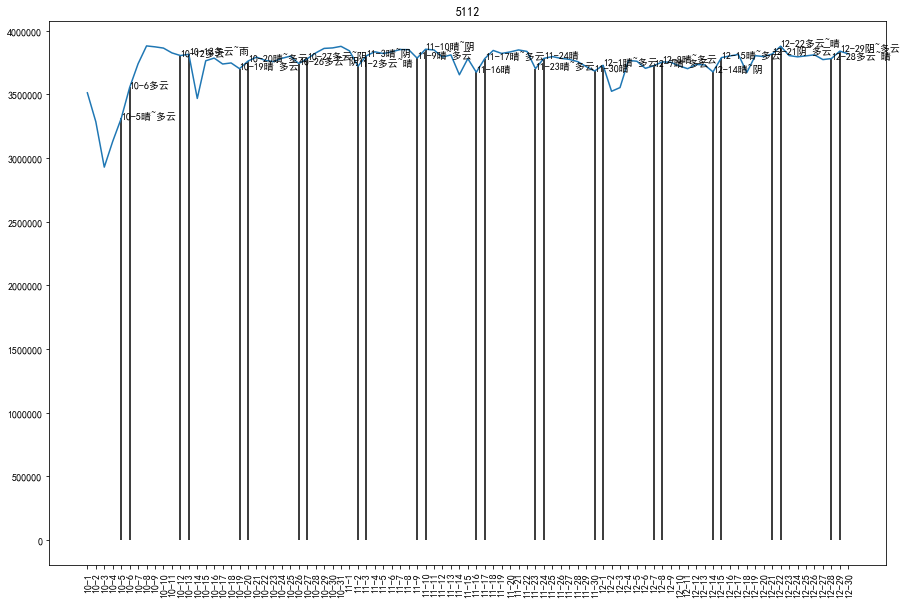

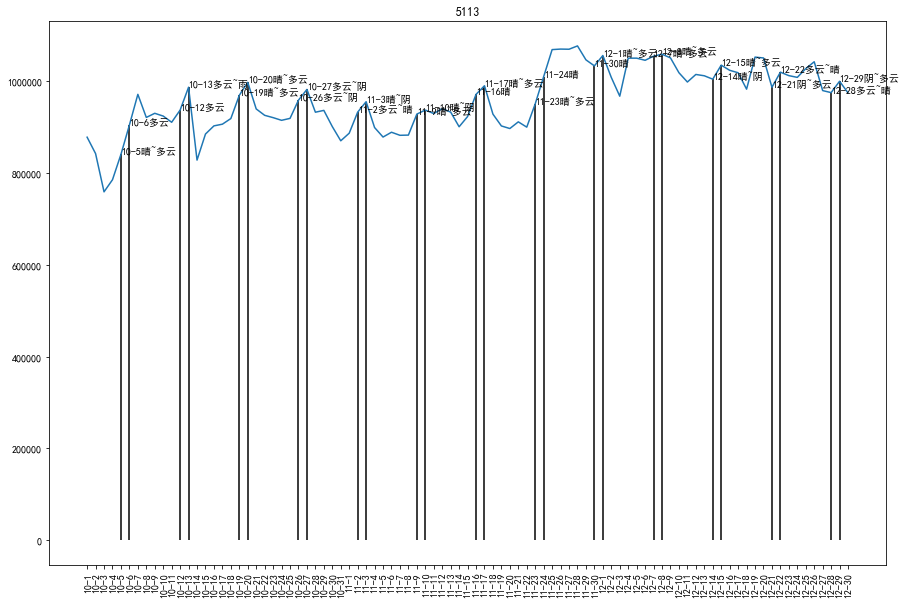

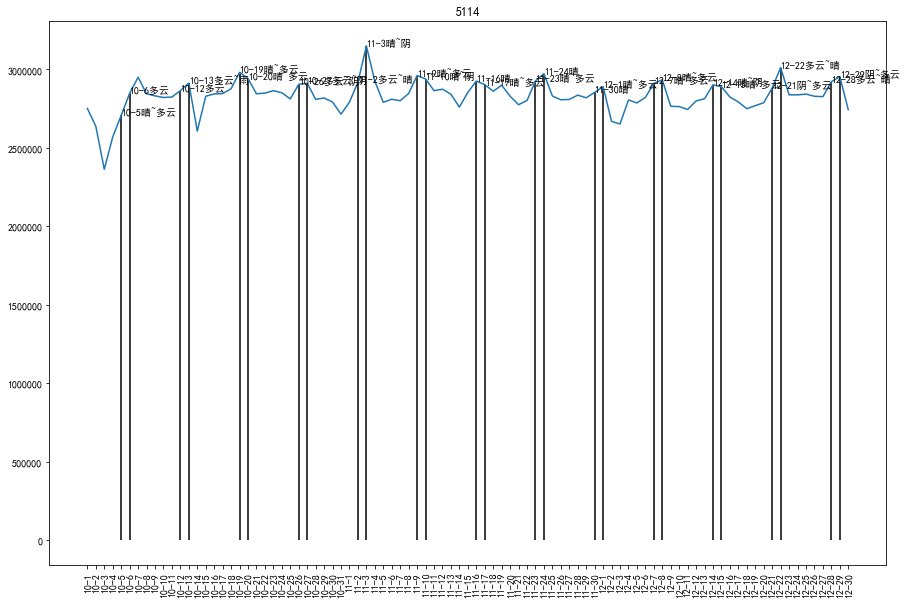

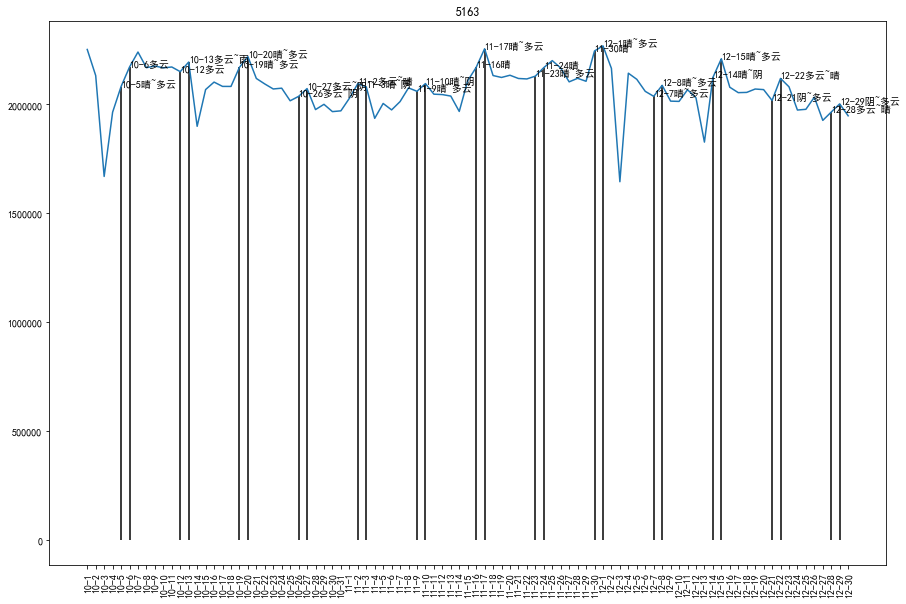

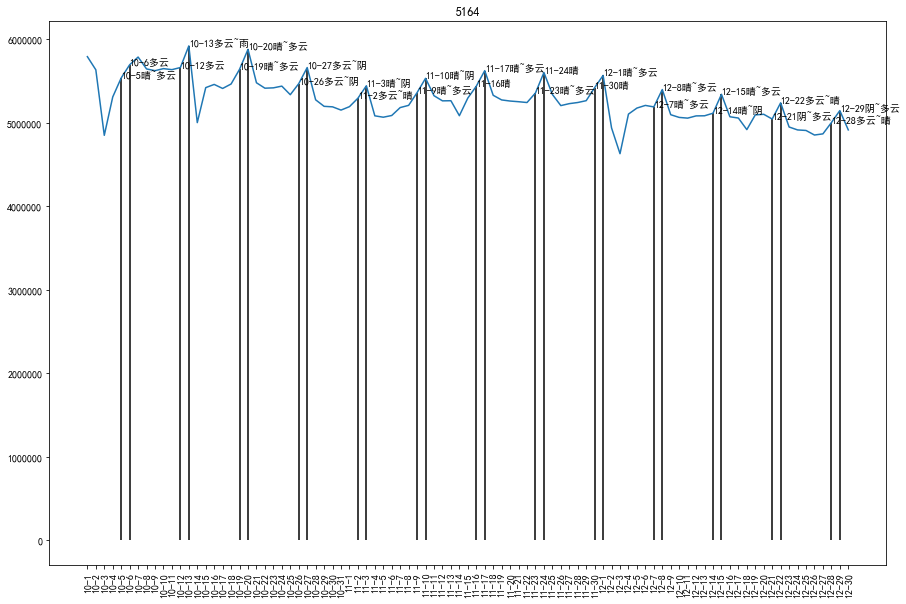

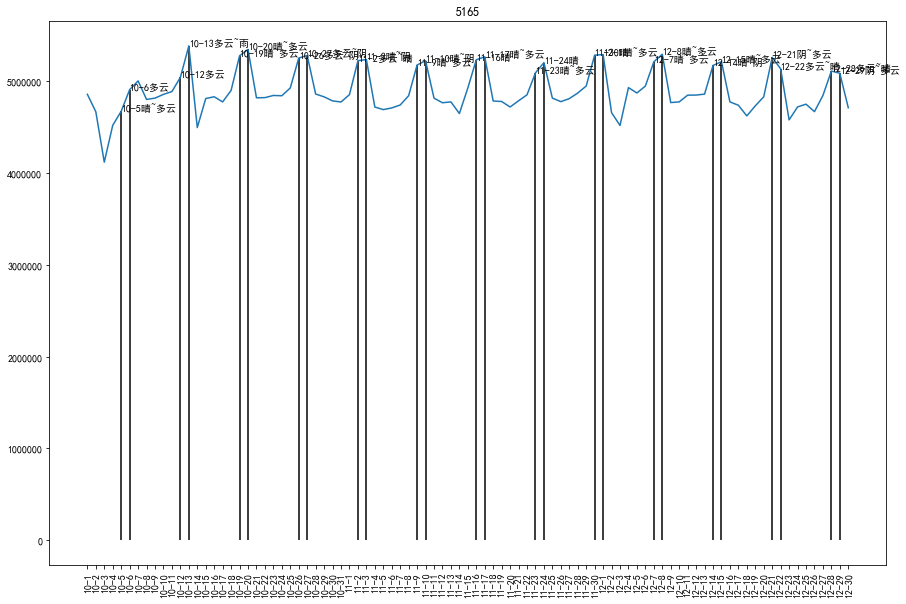

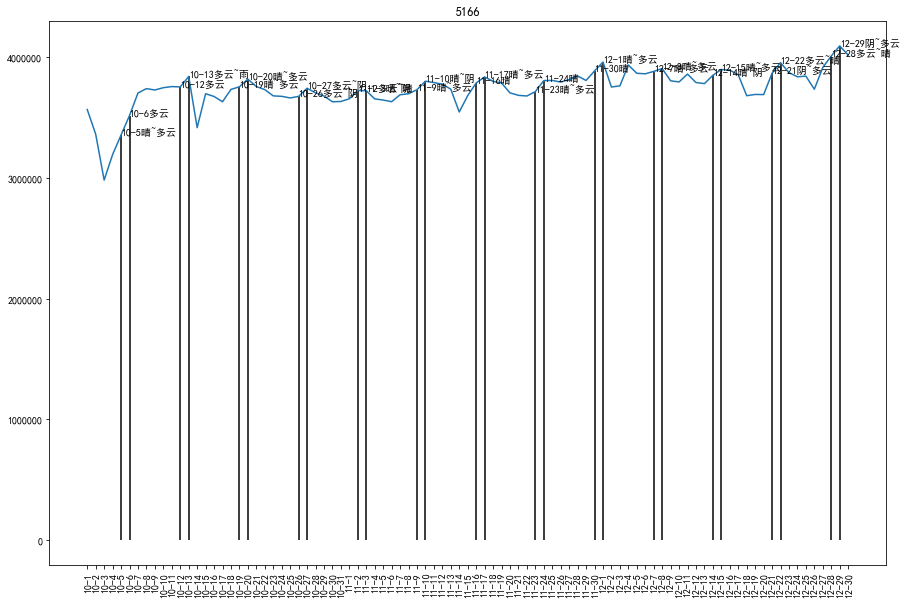

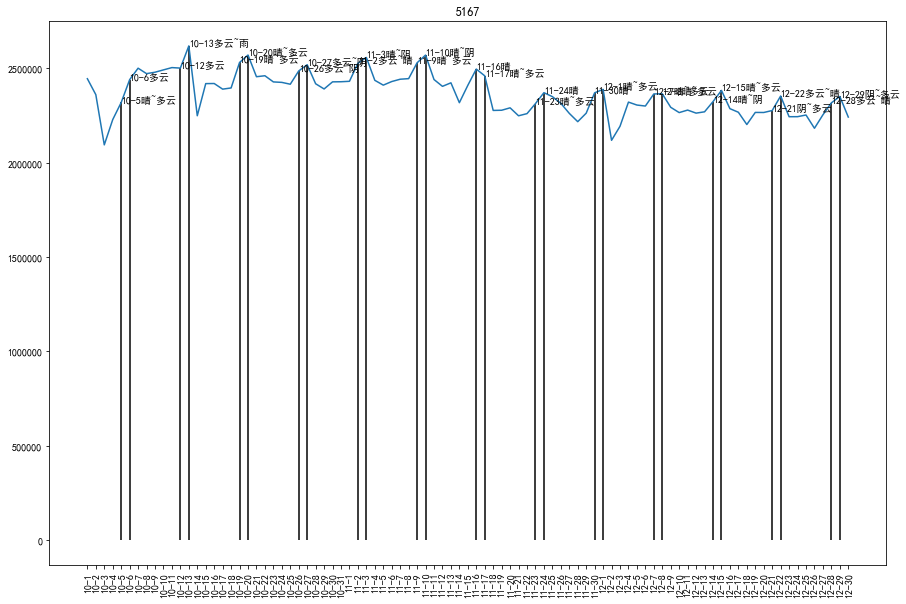

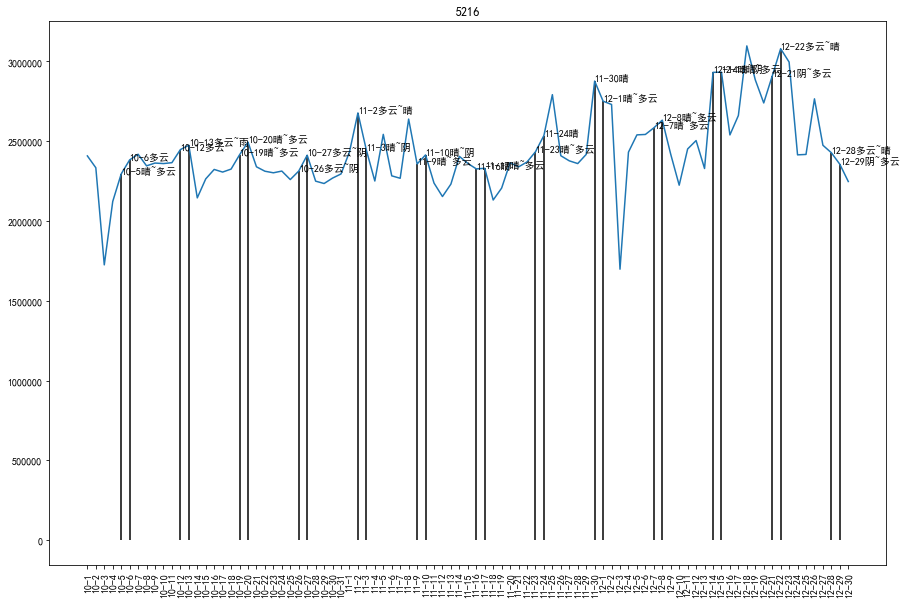

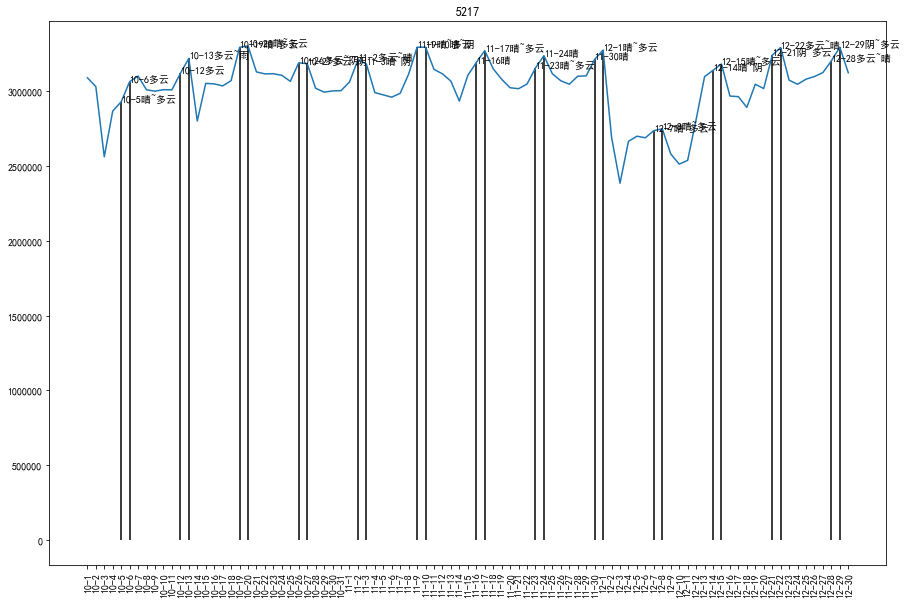

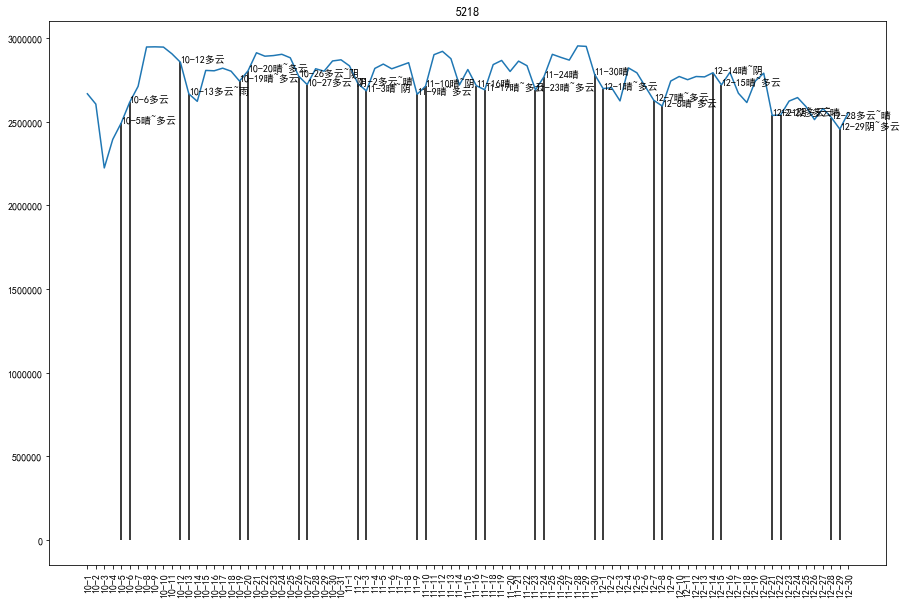

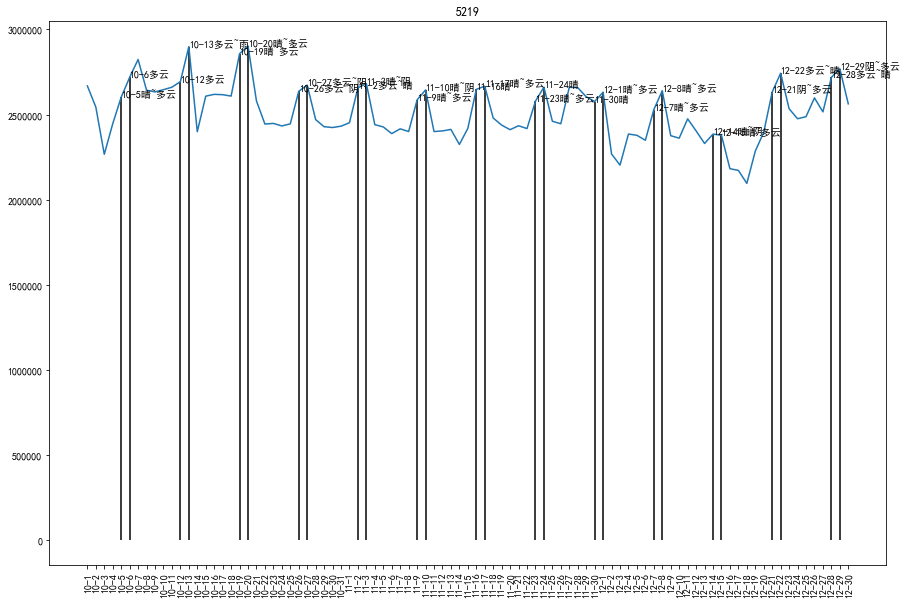

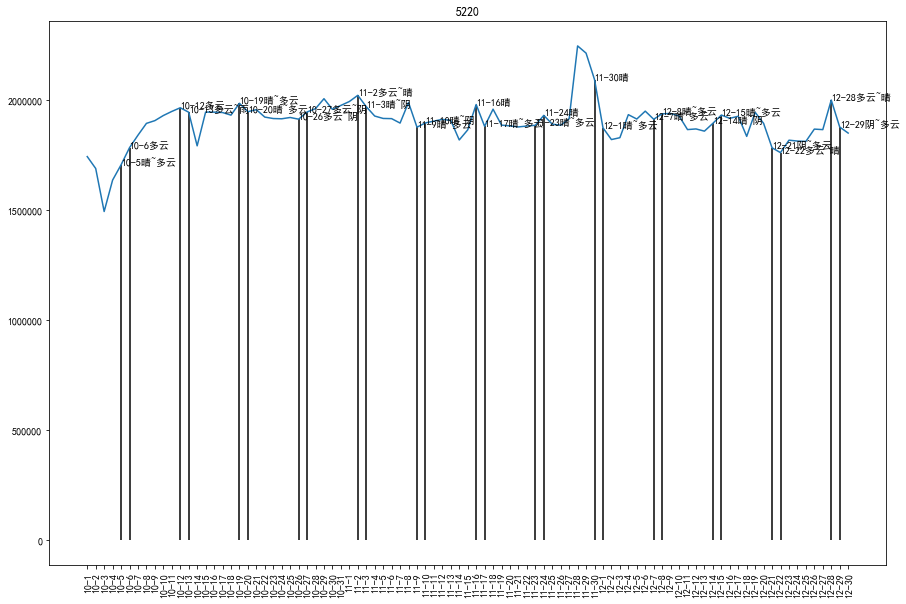

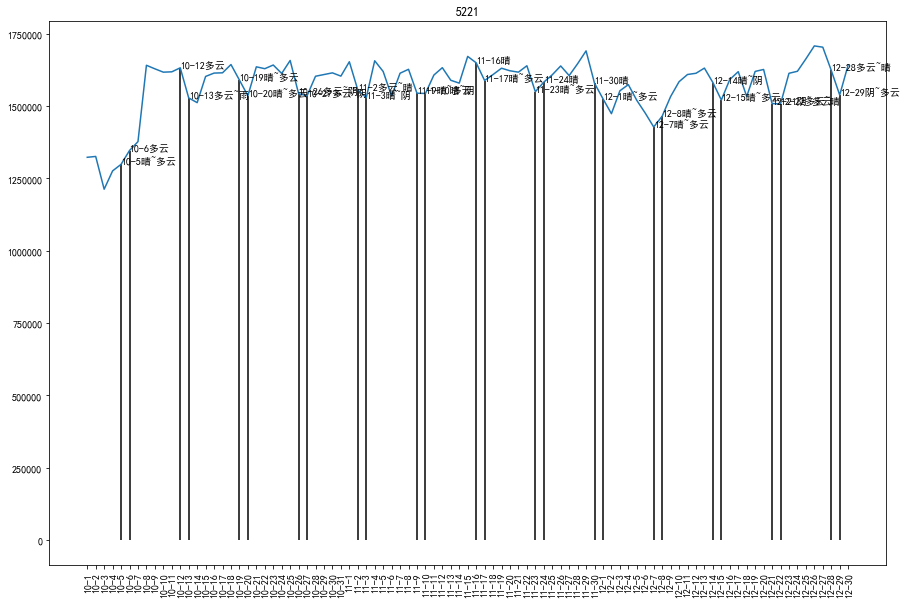

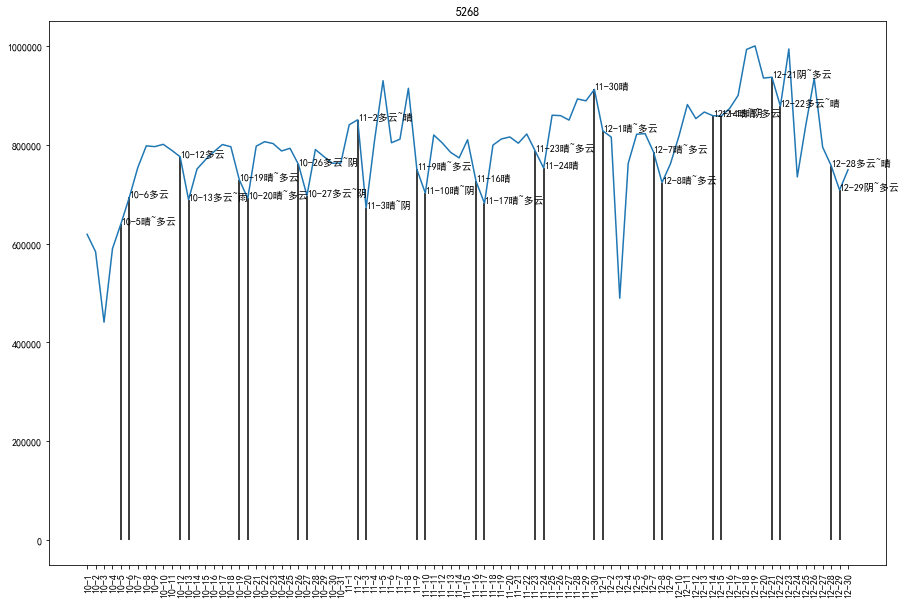

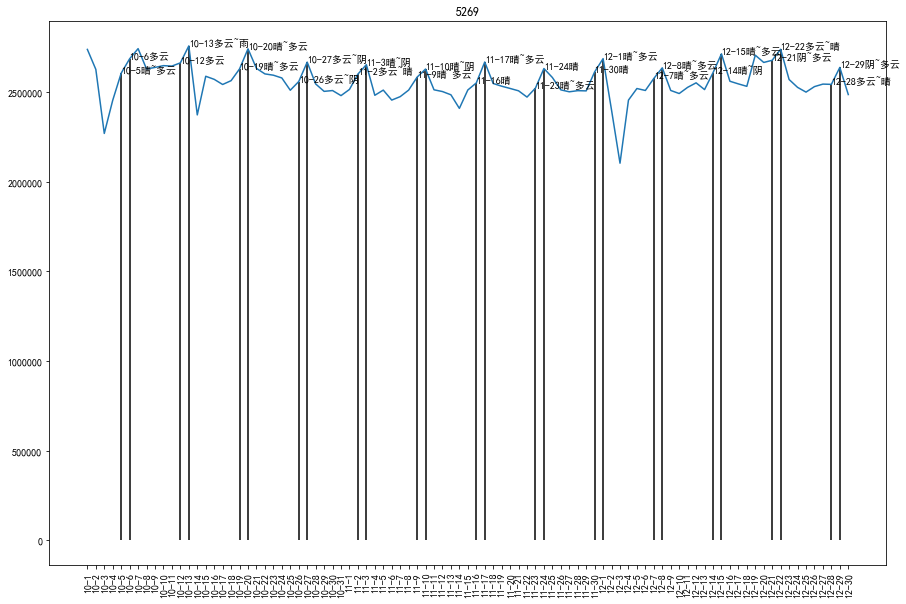

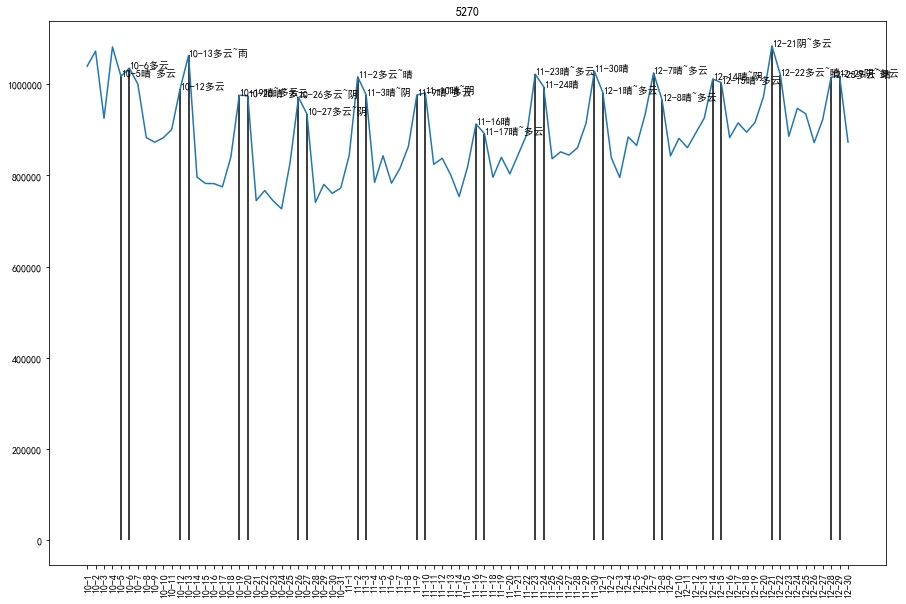

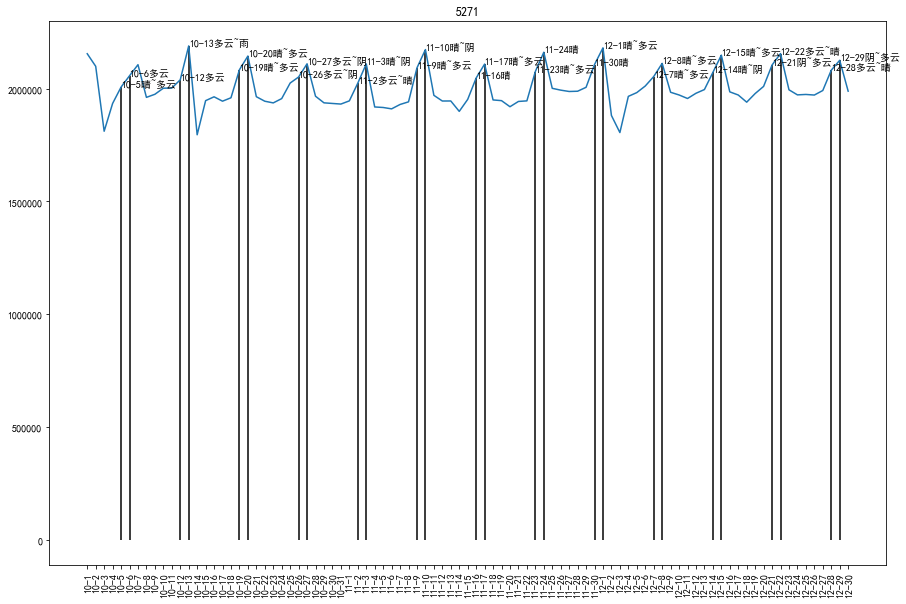

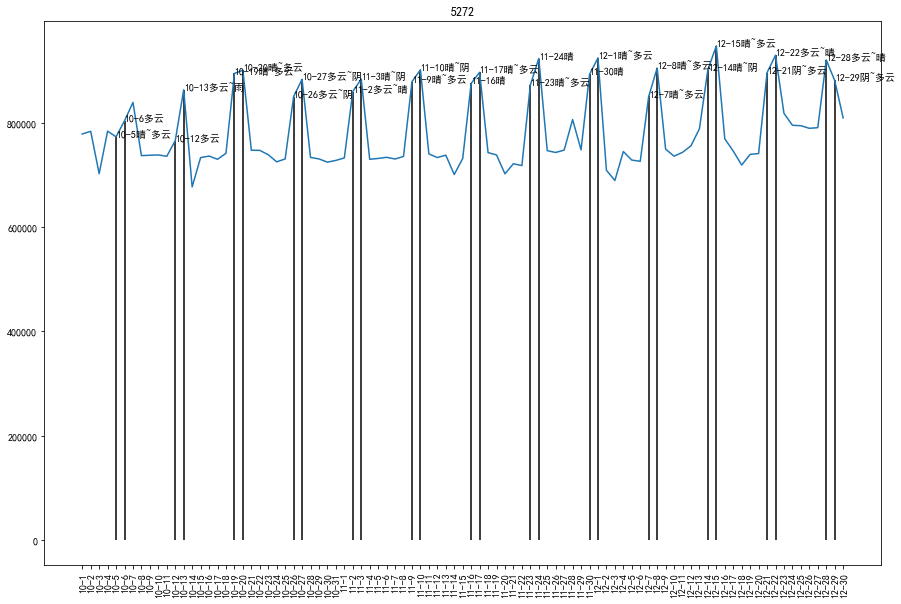

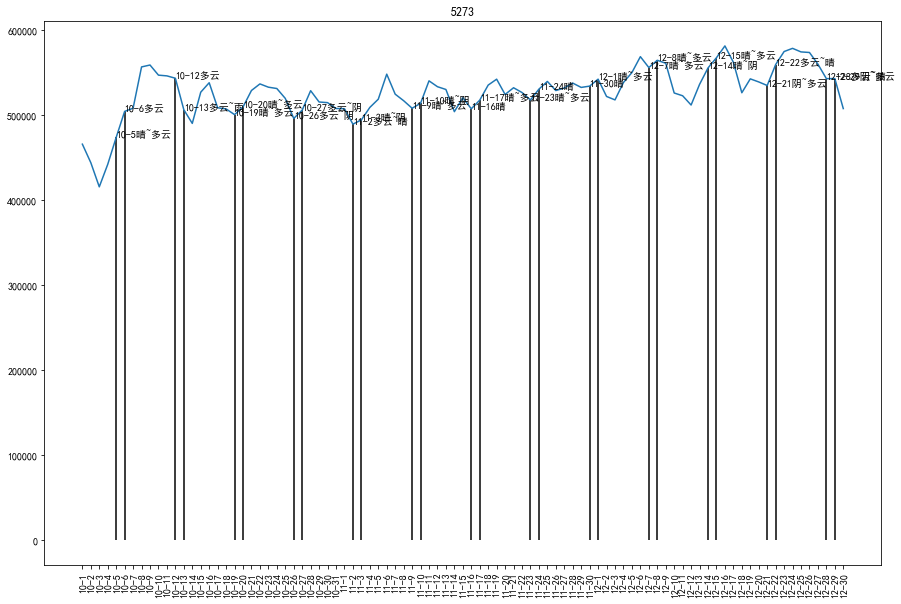

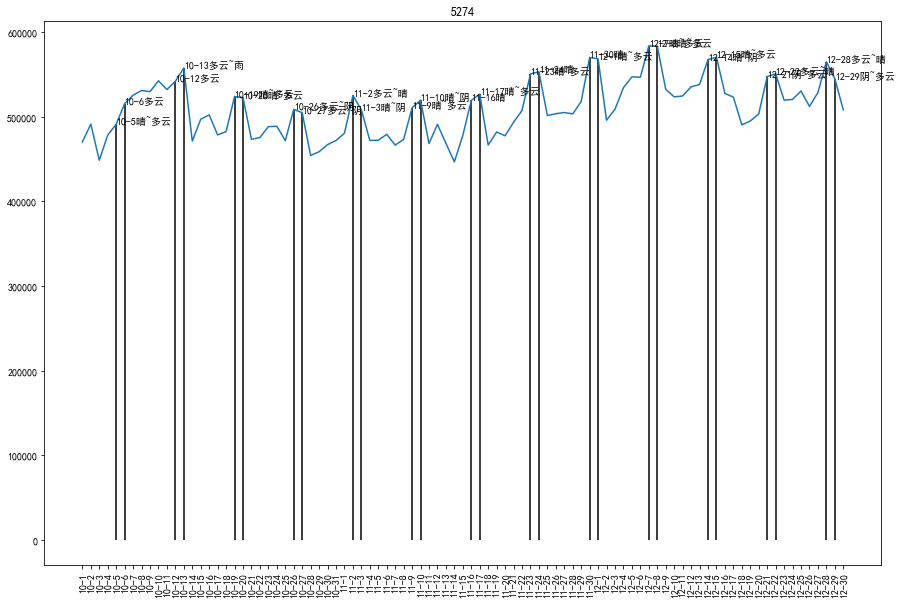

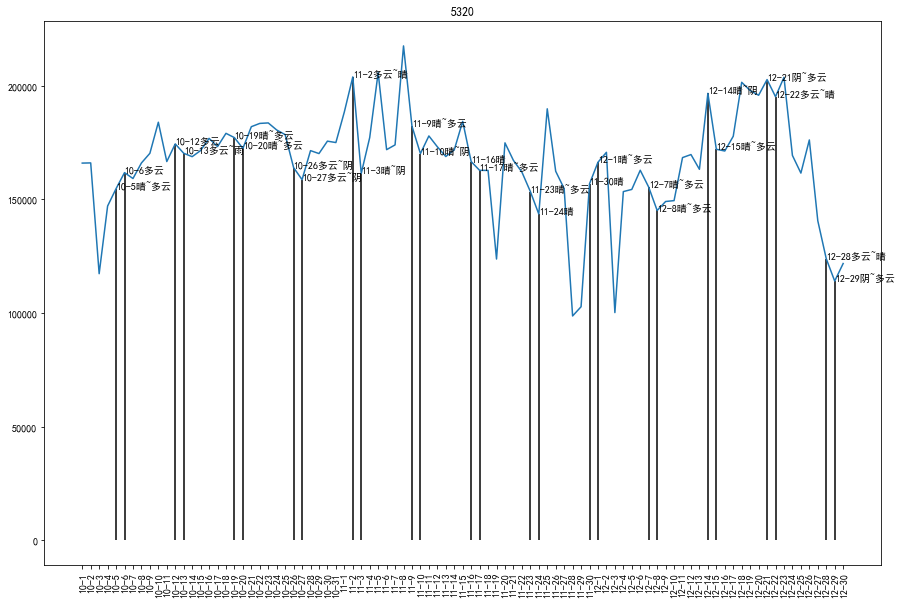

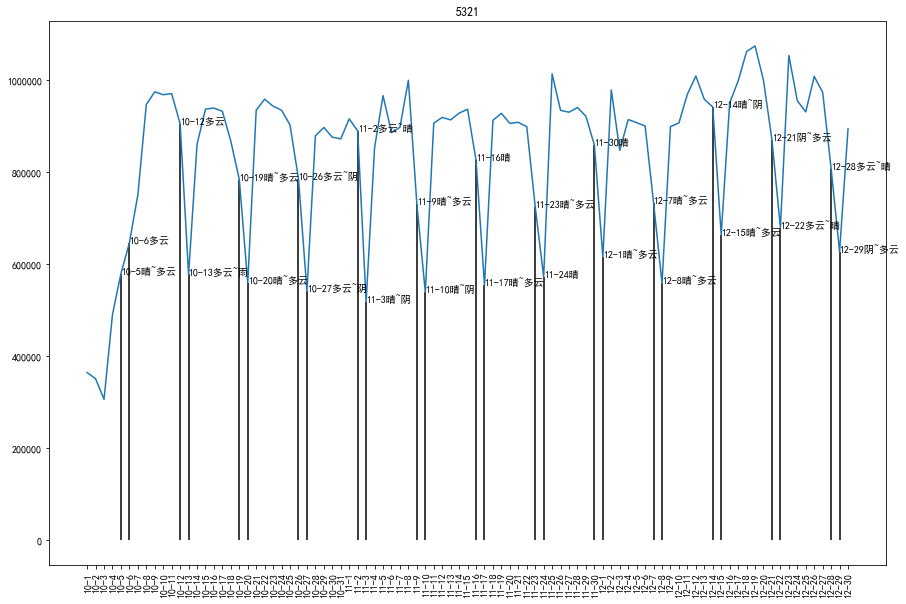

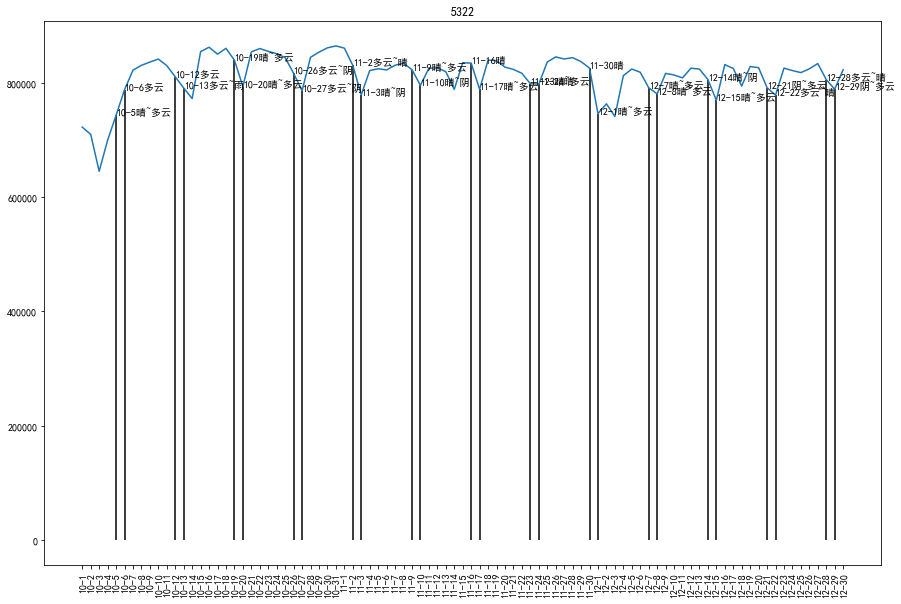

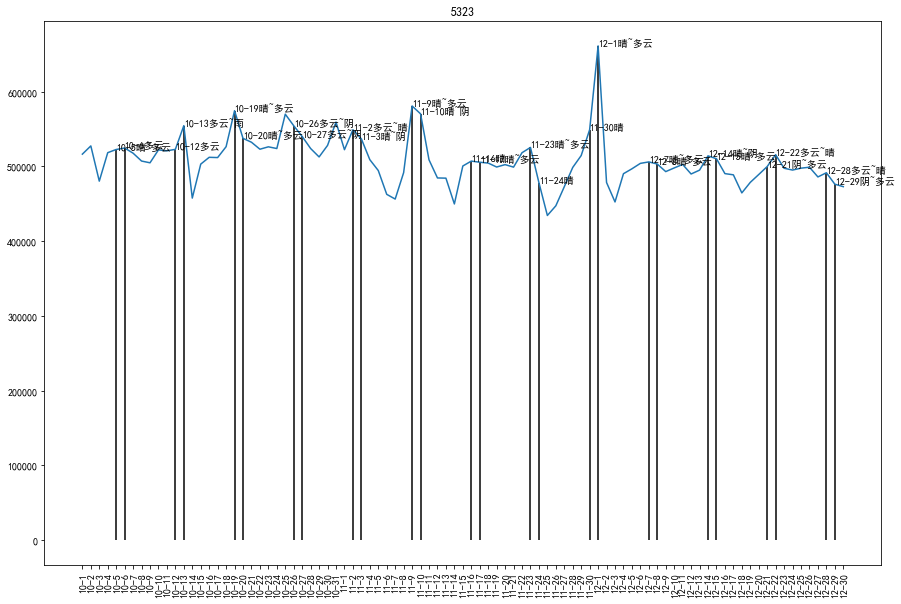

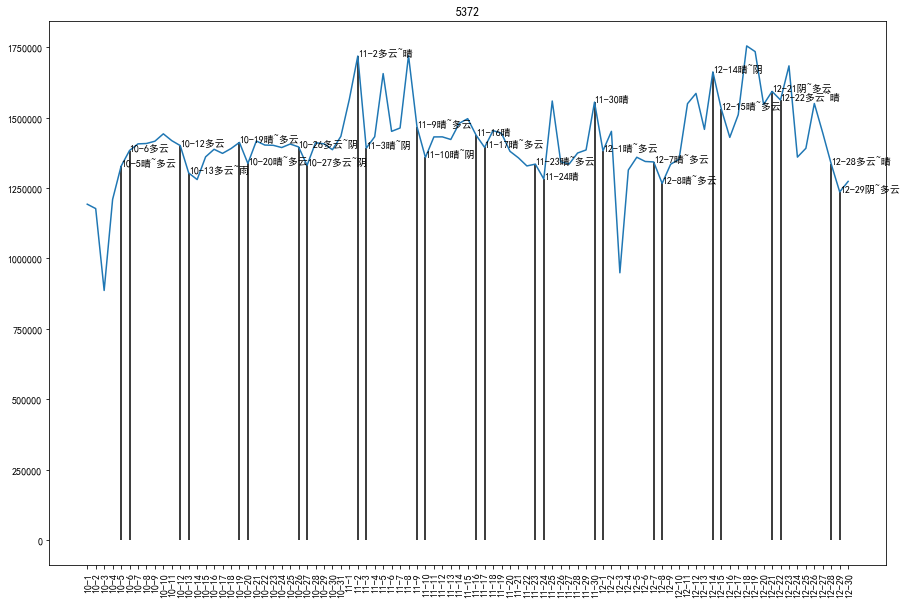

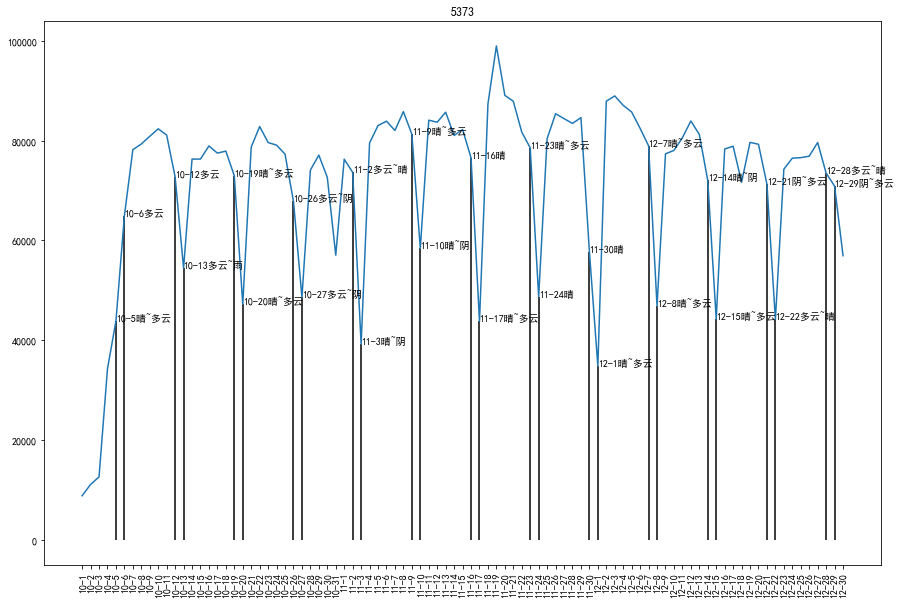

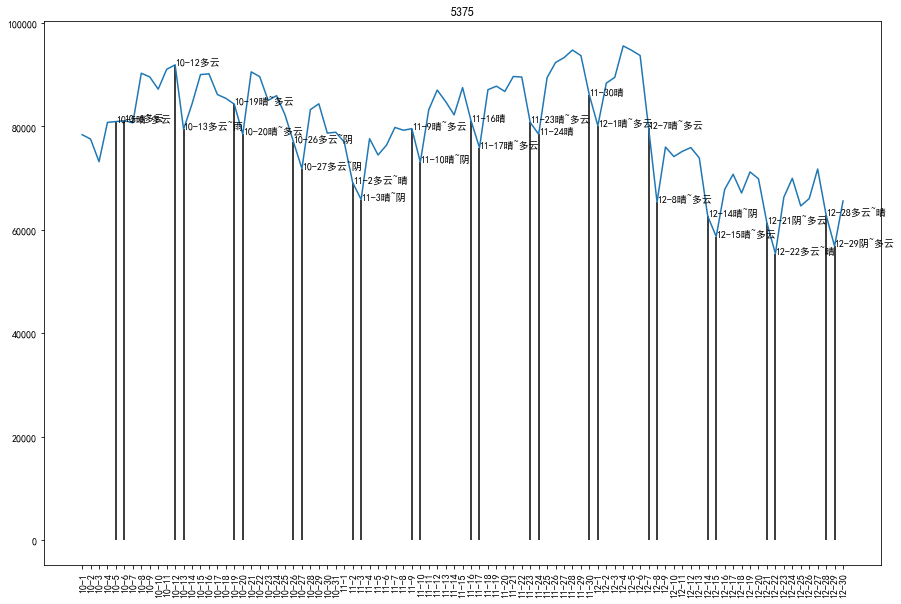

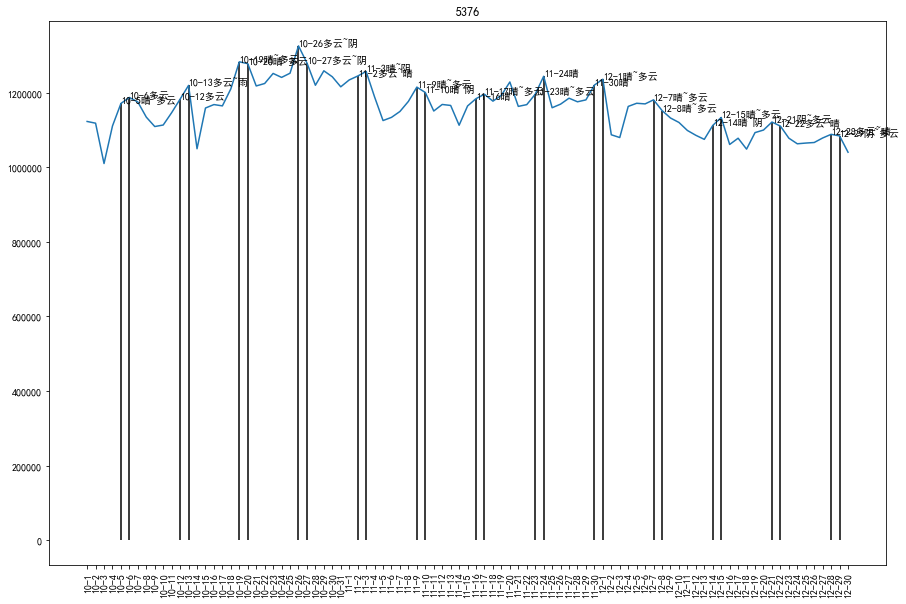

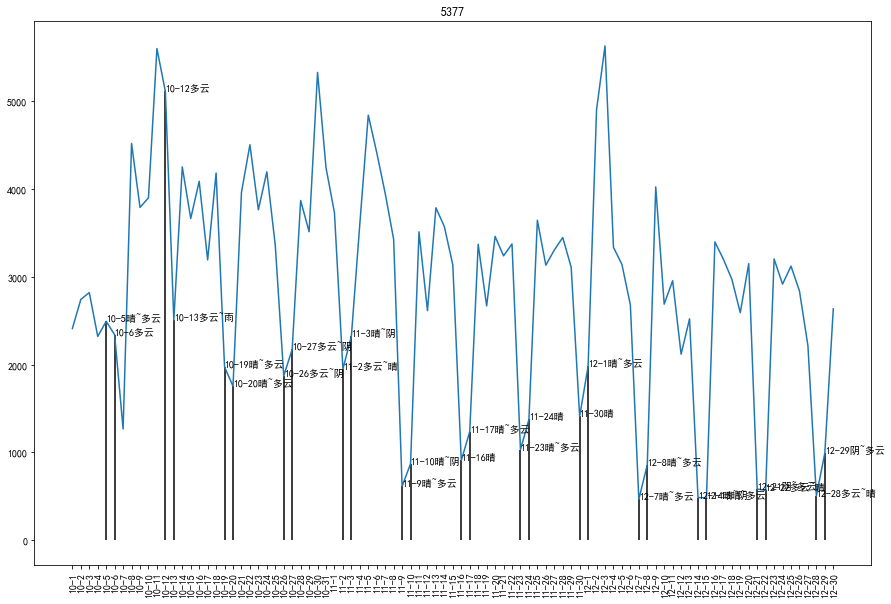

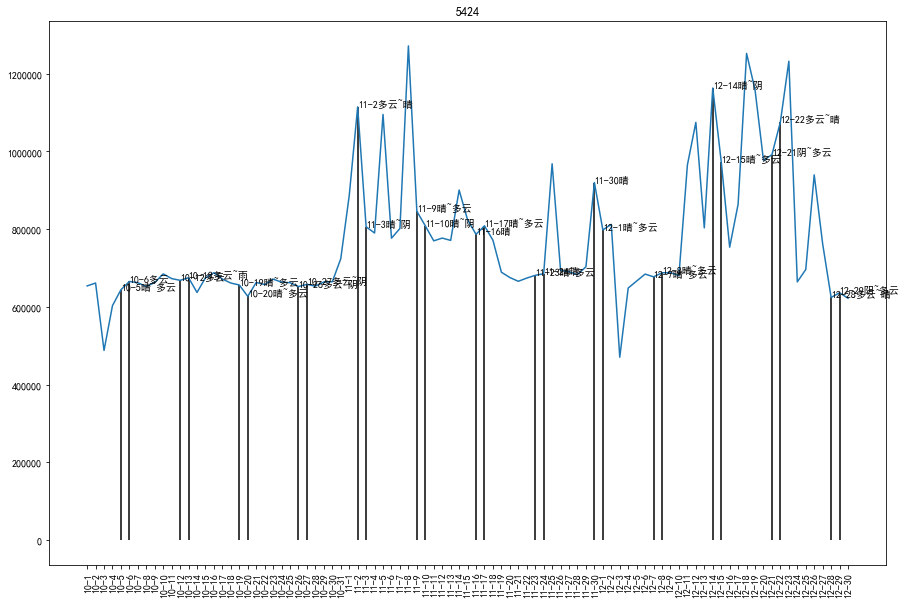

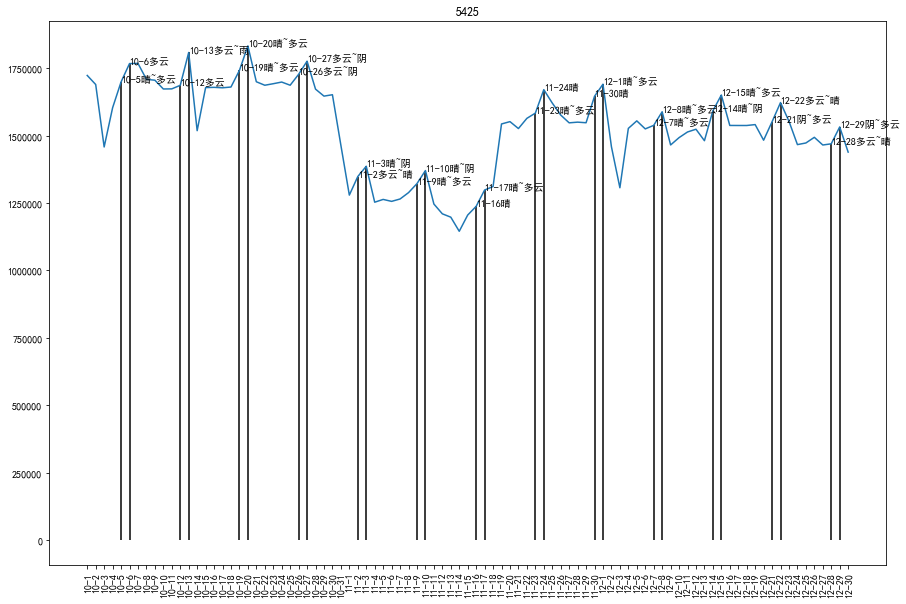

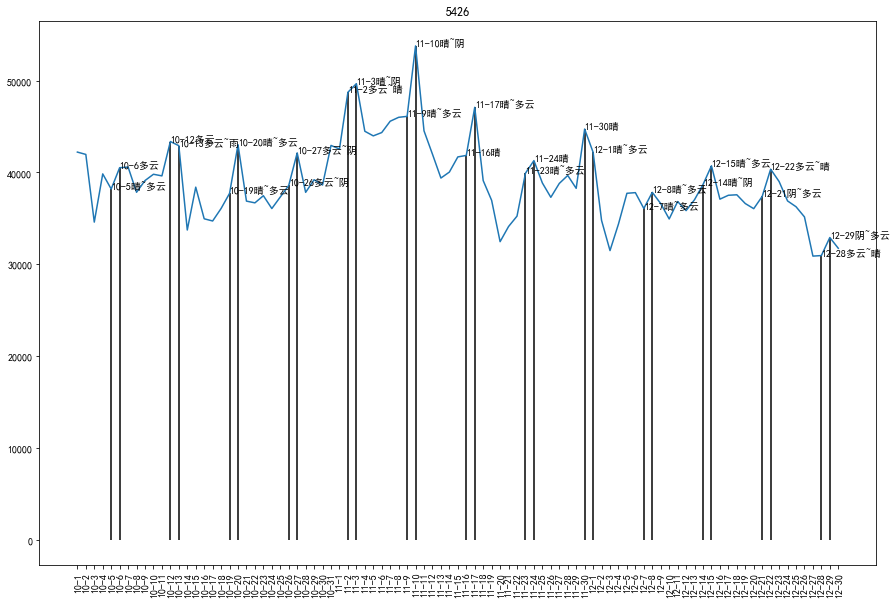

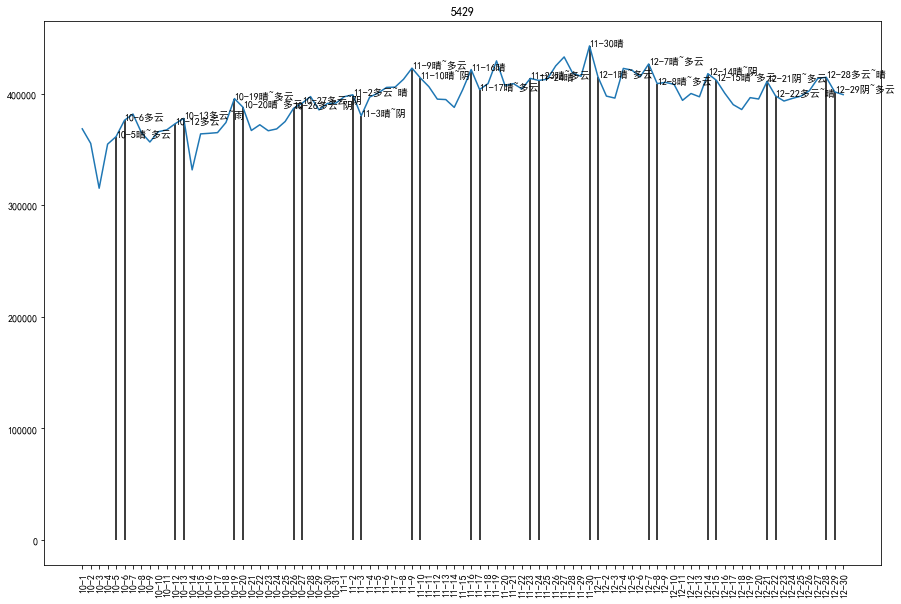

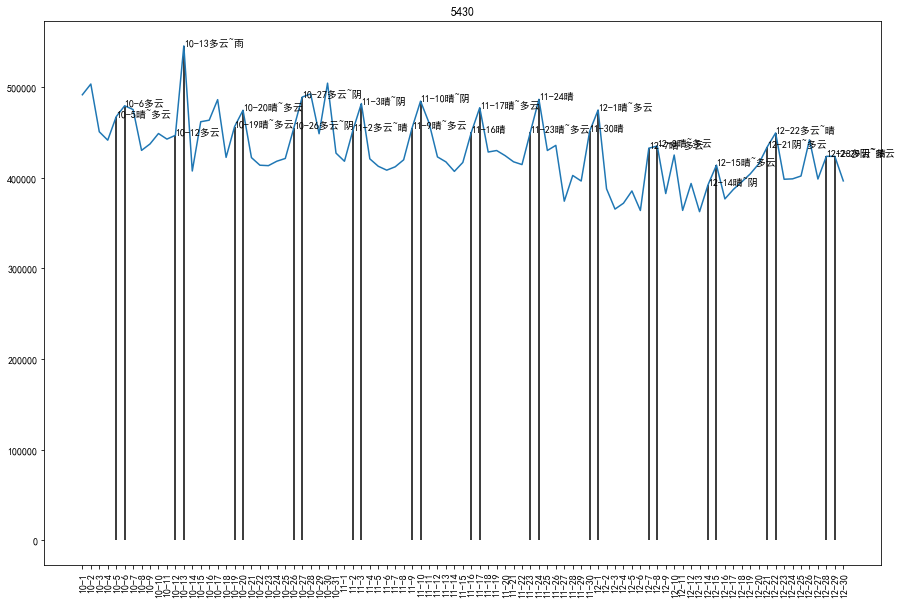

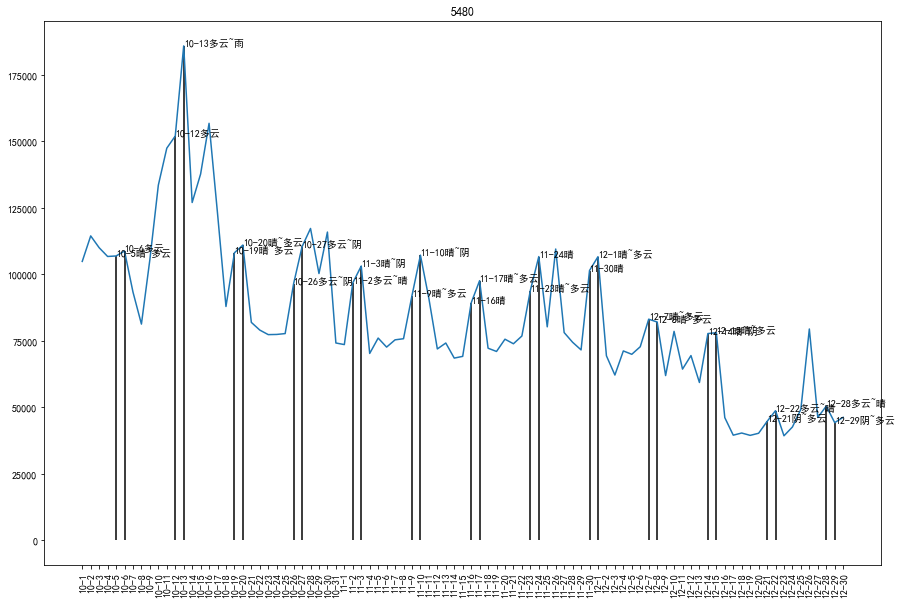

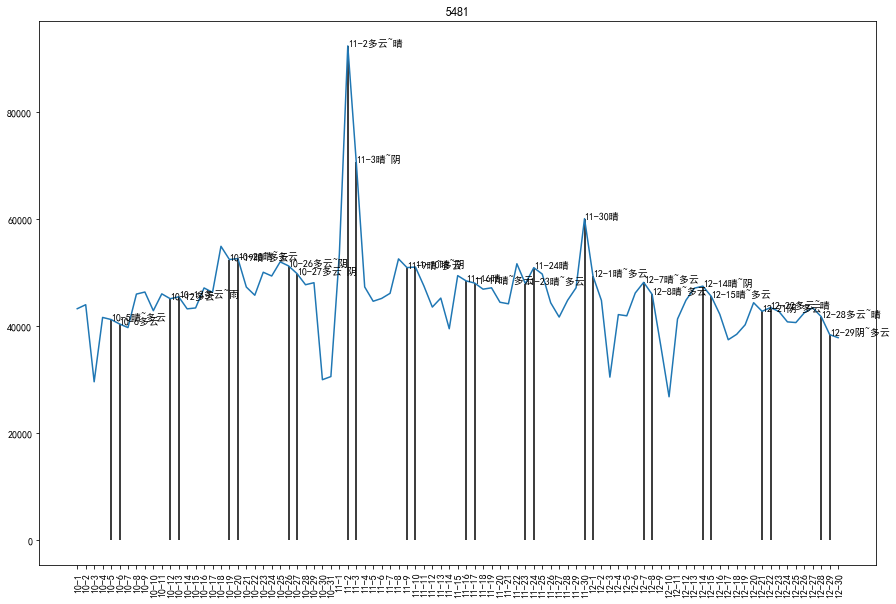

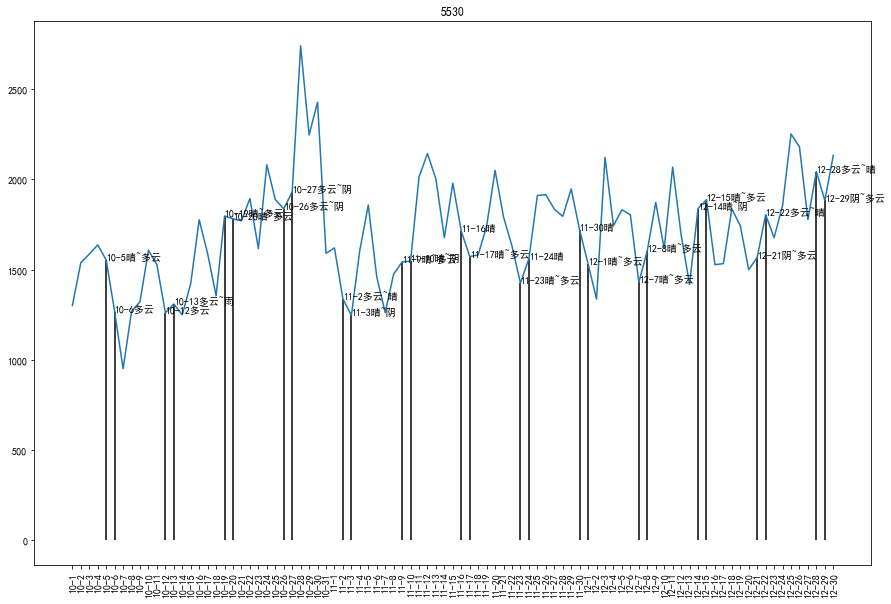

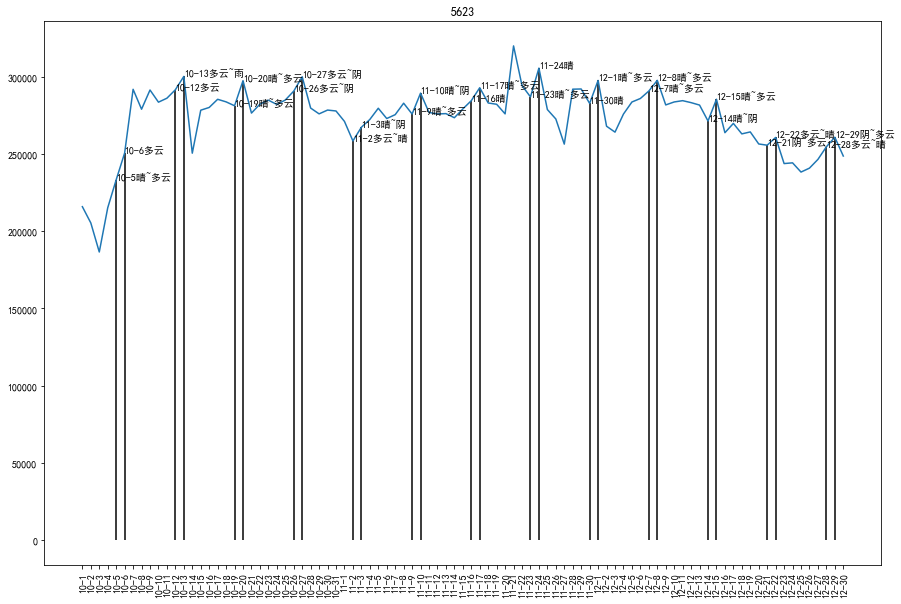

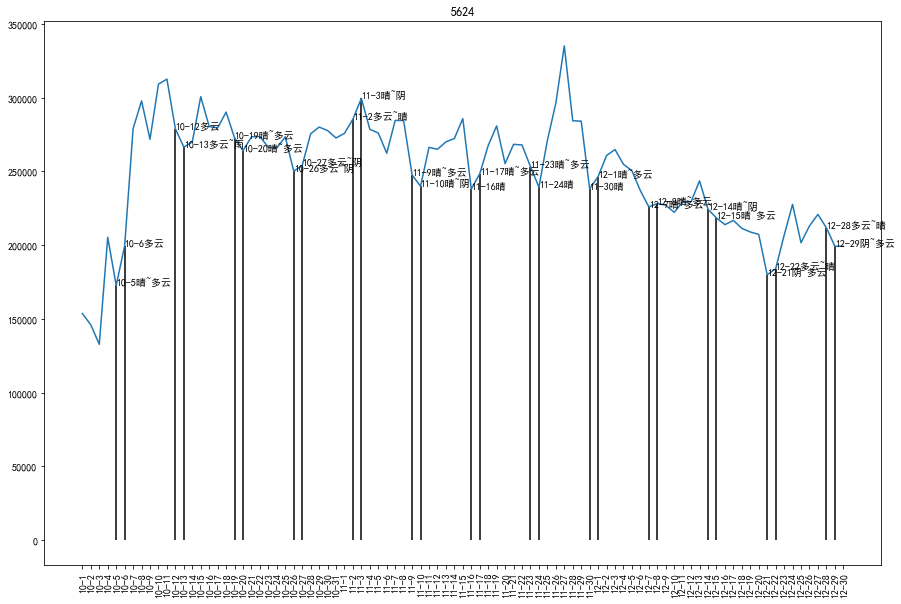

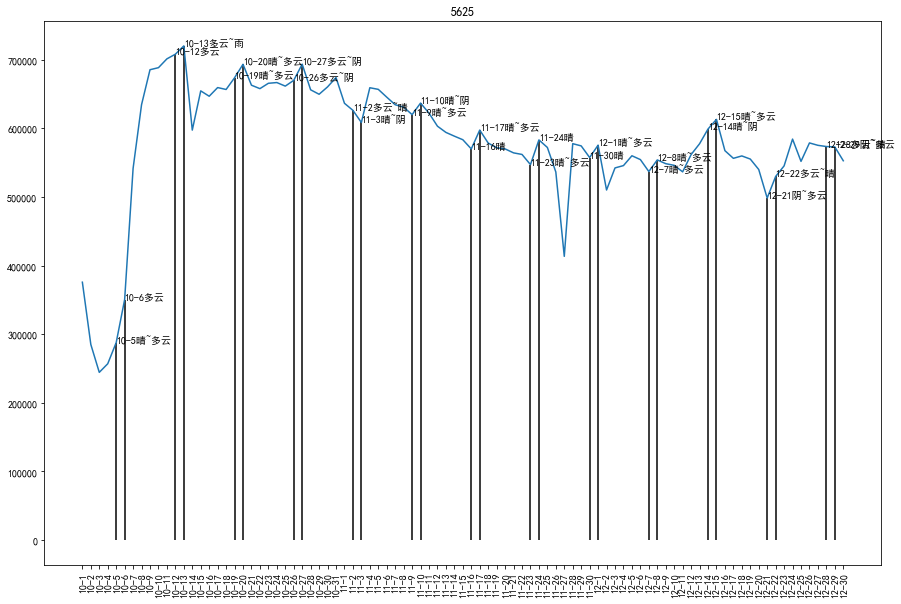

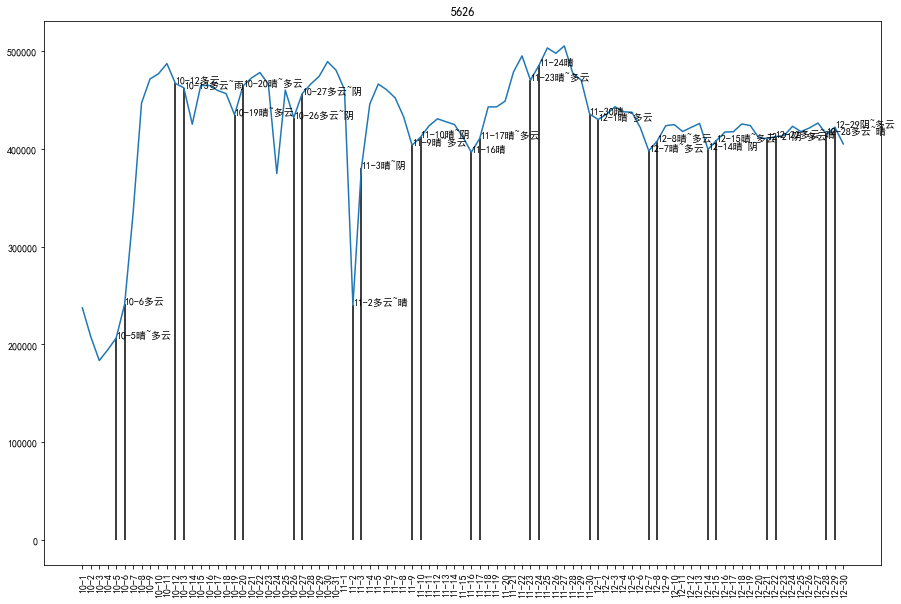

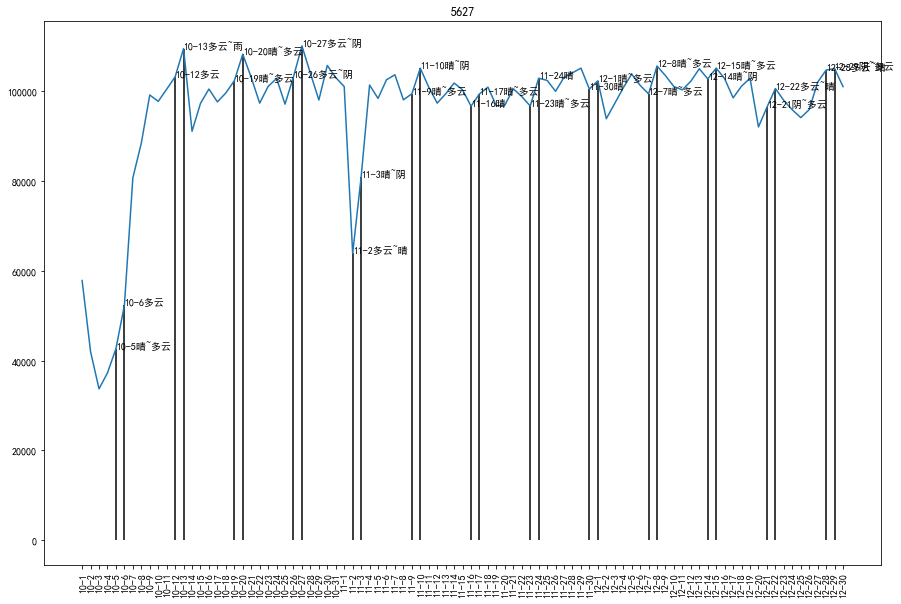

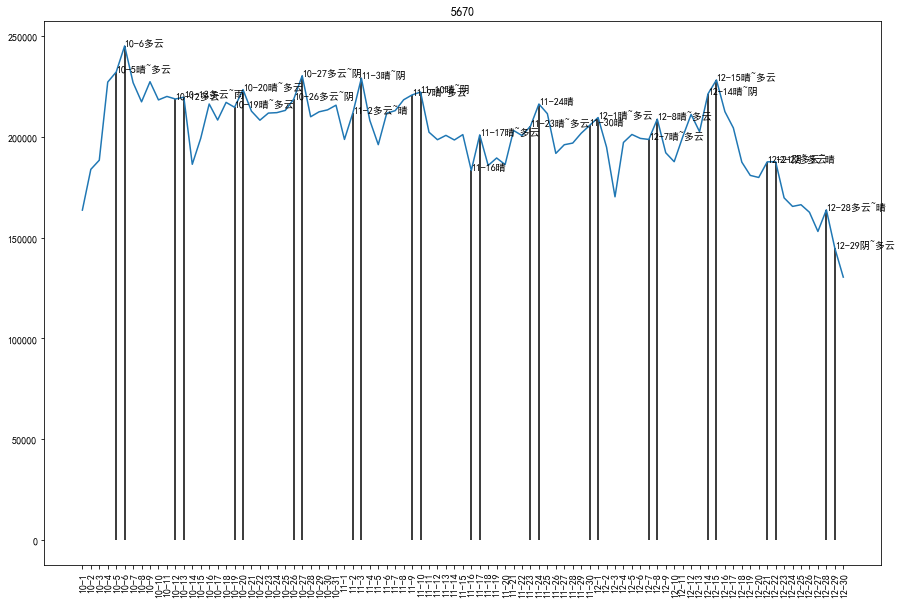

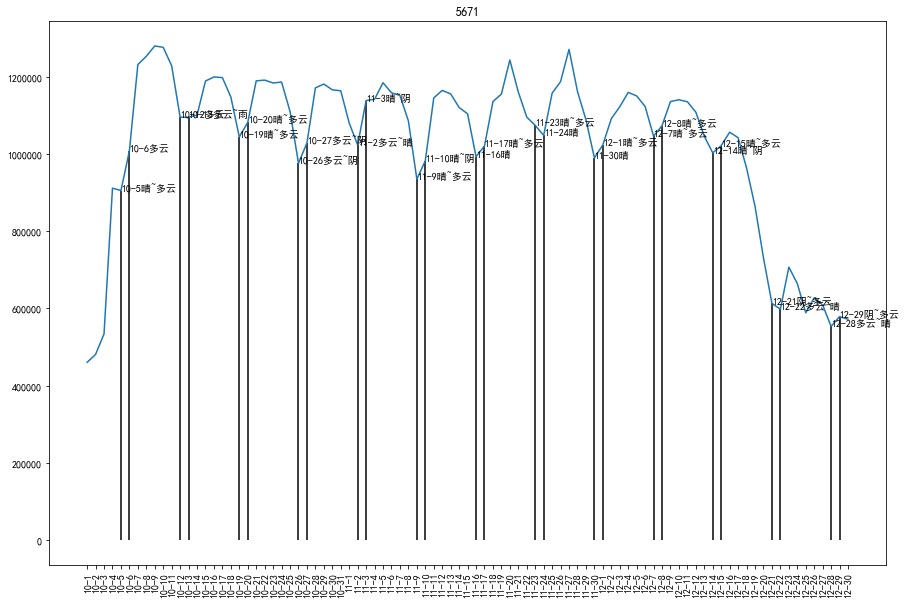

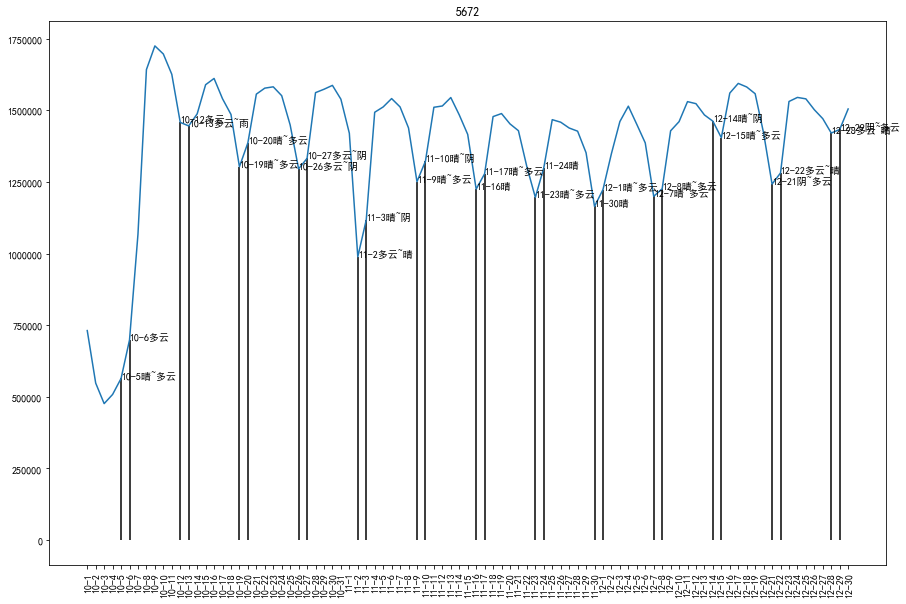

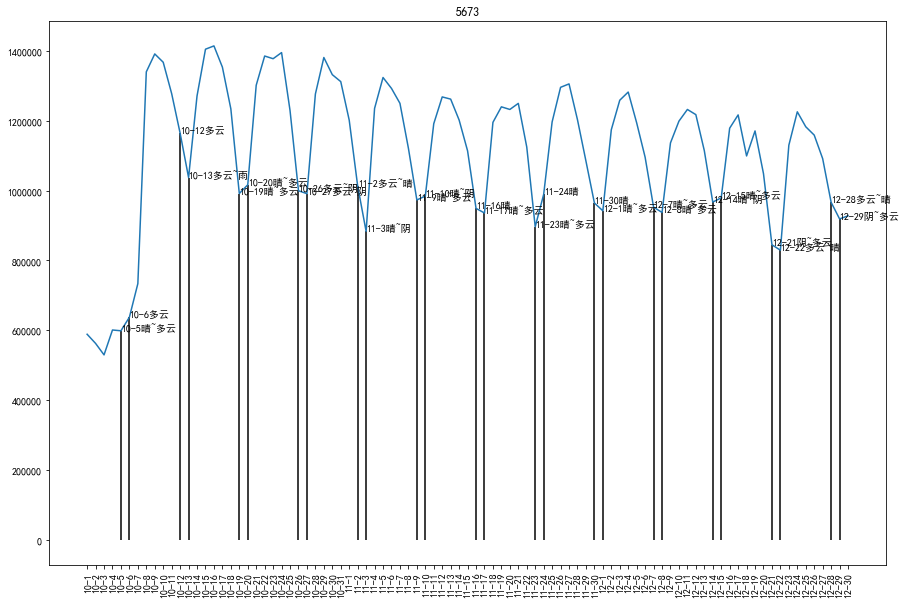

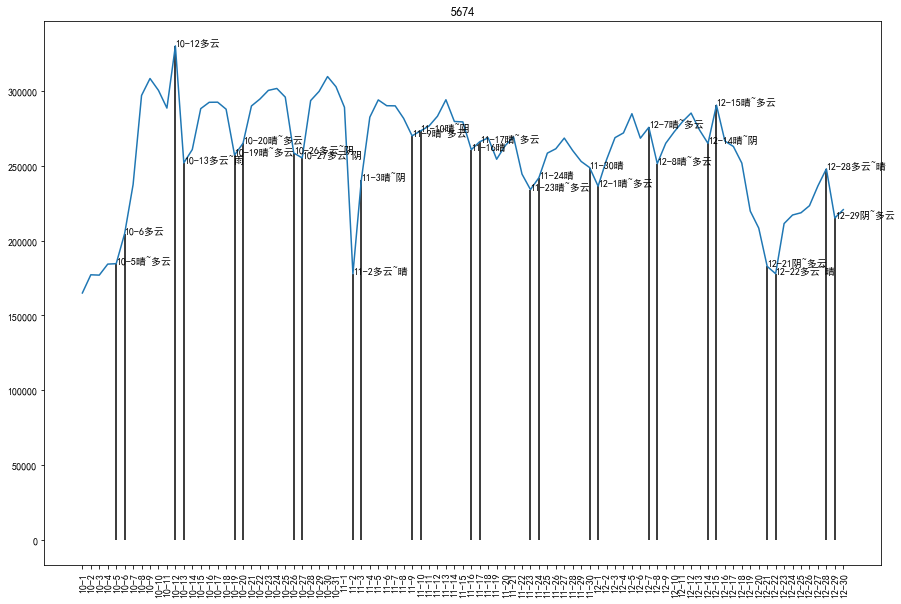

In [130]:
df['month_day'] = df['month'].astype(str) + '-' + df['day'].astype(str)
# print(df)
for i, df_inner in df.groupby(['month_day', 'grid_id', 'c_long', 'c_lat', 'is_weekend', 'day', 'month']).sum().reset_index().sort_values(['grid_id', 'month','day']).groupby('grid_id'):
    plt.figure(figsize=(15,10))
    plt.plot(df_inner['month_day'].tolist(), df_inner['flow'].tolist())
    plt.xticks(df_inner['month_day'], rotation=90)
    df_inner.index = range(len(df_inner))
#     print(df_inner)
    plt.title(df_inner['grid_id'].unique()[0])
    for ii,month_day_in in df_inner.iterrows():
        
        if month_day_in.month_day.split('-')[0] + '-' + month_day_in.month_day.split('-')[1].zfill(2) in weekends:
            wea = day_wea_dict['2019' + month_day_in.month_day.split('-')[0] + month_day_in.month_day.split('-')[1].zfill(2)]
#             print(ii)
#             print(month_day_in.month_day.split('-')[0] + '-' + month_day_in.month_day.split('-')[1].zfill(2))
            plt.vlines(ii, 0, month_day_in['flow'])
            plt.text(ii, month_day_in['flow'], month_day_in.month_day+wea)
    plt.savefig(f"pic/{df_inner['grid_id'].unique()[0]}.png")
#     break

In [125]:
df[df['is_weekend']==1]

month day hour time        datatim  grid_id      c_long      c_lat  \
46         10  03   00    2  10,03,00,1500     5430  116.407601  24.742399   
47         10  03   02    1  10,03,02,0000     5272  116.407601  24.717300   
48         10  03   02    4  10,03,02,5000     5672  116.407601  24.784201   
49         10  03   03    1  10,03,03,0500     4945  116.416604  24.667101   
50         10  03   05    2  10,03,05,2000     5167  116.425599  24.700600   
...       ...  ..  ...  ...            ...      ...         ...        ...   
2251283    12  27   16    3  12,27,16,4000     5321  116.380600  24.725700   
2251284    12  27   17    1  12,27,17,0000     4946  116.425599  24.667101   
2251285    12  27   19    2  12,27,19,2000     5164  116.398598  24.700600   
2251286    12  27   20    2  12,27,20,2500     5216  116.380600  24.708900   
2251287    12  27   21    4  12,27,21,5500     5429  116.398598  24.742399   

          flow time_label_all time_label  is_weekend  
46        1626     10-03-00-2       00-2           1  
47        2331     10-03-02-1       02-1           1  
48        1690     10-03-02-4       02-4           1  
49        9453     10-03-03-1       03-1           1  
50        7515     10-03-05-2       05-2           1  
...        ...            ...        ...         ...  
2251283   5144     12-27-16-3       16-3           1  
2251284  16662     12-27-17-1       17-1           1  
2251285  17872     12-27-19-2       19-2           1  
2251286   8115     12-27-20-2       20-2           1  
2251287   1653     12-27-21-4       21-4           1  

[643941 rows x 12 columns]

In [126]:
df['is_weekend'].value_counts()

0    1607306
1     643941
Name: is_weekend, dtype: int64

In [104]:
df.sort_values(['grid_id', 'time_label'])

month day hour time        datatim  grid_id      c_long      c_lat  \
758120     10  01   00    1  10,01,00,0500     4808  116.344597  24.650400   
1977789    10  01   00    1  10,01,00,0000     4808  116.344597  24.650400   
2000445    10  01   00    1  10,01,00,1000     4808  116.344597  24.650400   
775674     10  01   00    2  10,01,00,2500     4808  116.344597  24.650400   
1255424    10  01   00    2  10,01,00,1500     4808  116.344597  24.650400   
...       ...  ..  ...  ...            ...      ...         ...        ...   
1259986    12  30   23    3  12,30,23,3500     5674  116.425599  24.784201   
369911     12  30   23    4  12,30,23,4500     5674  116.425599  24.784201   
1406079    12  30   23    4  12,30,23,5500     5674  116.425599  24.784201   
1466981    12  30   23    4  12,30,23,5000     5674  116.425599  24.784201   
892593     12  31   00    1  12,31,00,0000     5674  116.425599  24.784201   

         flow  time_label  
758120   6161  10-01-00-1  
1977789  6046  10-01-00-1  
2000445  6144  10-01-00-1  
775674   6123  10-01-00-2  
1255424  6127  10-01-00-2  
...       ...         ...  
1259986   505  12-30-23-3  
369911    506  12-30-23-4  
1406079   475  12-30-23-4  
1466981   500  12-30-23-4  
892593    489  12-31-00-1  

[2251247 rows x 10 columns]

In [152]:
df[(df['day']=='01') & (df['month']=='10')]

time_label  grid_id      c_long      c_lat time_label_all  is_weekend  \
0            00-1     4808  116.344597  24.650400     10-01-00-1           0   
7907         00-2     4808  116.344597  24.650400     10-01-00-2           0   
15727        00-3     4808  116.344597  24.650400     10-01-00-3           0   
23463        00-4     4808  116.344597  24.650400     10-01-00-4           0   
31200        01-1     4808  116.344597  24.650400     10-01-01-1           0   
...           ...      ...         ...        ...            ...         ...   
719164       22-4     5674  116.425599  24.784201     10-01-22-4           0   
726985       23-1     5674  116.425599  24.784201     10-01-23-1           0   
734806       23-2     5674  116.425599  24.784201     10-01-23-2           0   
742627       23-3     5674  116.425599  24.784201     10-01-23-3           0   
750447       23-4     5674  116.425599  24.784201     10-01-23-4           0   

       day month   flow  
0       01    10  18351  
7907    01    10  18352  
15727   01    10  18405  
23463   01    10  18351  
31200   01    10  18422  
...     ..   ...    ...  
719164  01    10   1622  
726985  01    10   1537  
734806  01    10   1584  
742627  01    10   1581  
750447  01    10   1506  

[8255 rows x 9 columns]

In [14]:
def feature_extraction(flow_data_in):
    flow_data_in['flow_1db'] = [flow_data_in['flow'].mean()]*1 + flow_data_in['flow'][:-1].tolist()
    flow_data_in['flow_2db'] = [flow_data_in['flow'].mean()]*2 + flow_data_in['flow'][:-2].tolist()
    flow_data_in['flow_3db'] = [flow_data_in['flow'].mean()]*3 + flow_data_in['flow'][:-3].tolist()
    flow_data_in['flow_7db'] = [flow_data_in['flow'].mean()]*7 + flow_data_in['flow'][:-7].tolist()
#     flow_data_in['flow_14db'] = [flow_data_in['flow'].mean()]*14 + flow_data_in['flow'][:-14].tolist()
#     flow_data_in['flow_21db'] = [flow_data_in['flow'].mean()]*21 + flow_data_in['flow'][:-21].tolist()
#     flow_data_in['flow_7_14db'] = flow_data_in[['flow_7db','flow_14db', 'flow_21db']].mean(axis=1)
    
    flow_data_in['wea_1db'] = [0]*1 + flow_data_in['wea'][:-1].tolist()
    flow_data_in['is_rainy'] = [0]*1 + flow_data_in['is_rainy'][:-1].tolist()
    flow_data_in['low_tem_1db'] = [0]*1 + flow_data_in['low_tem'][:-1].tolist()
    flow_data_in['high_tem_1db'] = [0]*1 + flow_data_in['high_tem'][:-1].tolist()
    
    
    flow_data_in['flow_3dba'] = flow_data_in[['flow_1db','flow_2db','flow_3db']].mean(axis=1)
    
    df_grid_flow = flow_data_in.groupby('grid_id').mean().reset_index()[['grid_id', 'flow']]
    df_grid_flow = df_grid_flow.rename(columns={'flow':'area_flow'})
    flow_data_in = flow_data_in.merge(df_grid_flow, on='grid_id')
    return flow_data_in



In [141]:
print(len(df['grid_id'].unique()))  # 网格个数
df['grid_id'].unique()

86


array([4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4876,
       4877, 4878, 4879, 4880, 4881, 4882, 4883, 4939, 4940, 4941, 4942,
       4943, 4944, 4945, 4946, 4999, 5000, 5001, 5002, 5003, 5004, 5056,
       5057, 5058, 5059, 5060, 5111, 5112, 5113, 5114, 5163, 5164, 5165,
       5166, 5167, 5216, 5217, 5218, 5219, 5220, 5221, 5268, 5269, 5270,
       5271, 5272, 5273, 5274, 5320, 5321, 5322, 5323, 5372, 5373, 5375,
       5376, 5377, 5424, 5425, 5426, 5429, 5430, 5480, 5481, 5530, 5623,
       5624, 5625, 5626, 5627, 5670, 5671, 5672, 5673, 5674], dtype=int64)

In [75]:
train_df

grid_id      c_long      c_lat  is_weekend  day  month  hour  flow_1db  \
7819     5674  116.425599  24.784201           1    5     10     0         0   
7820     5674  116.425599  24.784201           1    6     10     0      1327   
7826     5674  116.425599  24.784201           1   12     10     0      1499   
7827     5674  116.425599  24.784201           1   13     10     0      2262   
7833     5674  116.425599  24.784201           1   19     10     0      2123   
7834     5674  116.425599  24.784201           1   20     10     0      1876   
7840     5674  116.425599  24.784201           1   26     10     0      1756   
7841     5674  116.425599  24.784201           1   27     10     0      1919   
7847     5674  116.425599  24.784201           1    2     11     0      1825   
7848     5674  116.425599  24.784201           1    3     11     0      1925   
7854     5674  116.425599  24.784201           1    9     11     0        89   
7855     5674  116.425599  24.784201           1   10     11     0      2024   
7858     5674  116.425599  24.784201           1   13     11     0      2057   
7861     5674  116.425599  24.784201           1   16     11     0      1932   
7862     5674  116.425599  24.784201           1   17     11     0      1924   
7869     5674  116.425599  24.784201           1   24     11     0      1786   
7875     5674  116.425599  24.784201           1   30     11     0      1627   

      flow_2db  flow_3db    flow_3dba  
7819         0         0     0.000000  
7820         0         0   442.333333  
7826      1327         0   942.000000  
7827      1499      1327  1696.000000  
7833      2262      1499  1961.333333  
7834      2123      2262  2087.000000  
7840      1876      2123  1918.333333  
7841      1756      1876  1850.333333  
7847      1919      1756  1833.333333  
7848      1825      1919  1889.666667  
7854      1925      1825  1279.666667  
7855        89      1925  1346.000000  
7858      2024        89  1390.000000  
7861      2057      2024  2004.333333  
7862      1932      2057  1971.000000  
7869      1924      1932  1880.666667  
7875      1786      1924  1779.000000

In [76]:
train_y

7819    1327
7820    1499
7826    2262
7827    2123
7833    1876
7834    1756
7840    1919
7841    1825
7847    1925
7848      89
7854    2024
7855    2057
7858    1932
7861    1924
7862    1786
7869    1627
7875    1712
Name: flow, dtype: int64

In [170]:
df['day'] = df['day'].astype(int)
df['month'] = df['month'].astype(int)

In [25]:
from sklearn import svm,datasets
from sklearn.model_selection import GridSearchCV
# iris = datasets.load_iris()
# #定义参数网格：2*3=6个参数组合
# parameters = {'kernel':['rbf','linear'],'C':[5,10]}
# svr = svm.SVC()
# clf = GridSearchCV(svr,parameters)
# clf.fit(iris.data,iris.target)
# print(clf.best_estimator_)
def training_xgboost(train_data, train_y):
    
    model_xgb = xgb.XGBRegressor(max_depth=3
                                ,learning_rate=0.14
                                ,n_estimators=1000
                                ,n_jobs=-1)
#     model_xgb = xgb.XGBRegressor(max_depth=3
#                                 ,learning_rate=0.14
#                                 ,n_estimators=300
#                                 ,n_jobs=-1)
    parameters = {'max_depth':[3,4,2], 'n_estimators':[300,400, 500, 600, 700]}
#     model_xgb = GridSearchCV(model_xgb, parameters)
    
    t1 = time.time()
#     print(train_data)
#     print(train_y)
    model_xgb.fit(train_data,train_y)
    print('training time:', str(int(time.time()-t1))+'s, ', end='')
#     print(model_xgb.best_estimator_)
    return model_xgb

def training_lightgbm(train_data, train_y):
    model_lgb = lgb.LGBMRegressor(num_leaves=20
                                ,max_depth=3
                                ,learning_rate=0.14
                                ,n_estimators=2000
                                ,n_jobs=-1)

    t1 = time.time()
    model_lgb.fit(train_data,train_y)
    print('training time:', str(int(time.time()-t1))+'s, ', end='')
    return model_lgb

In [151]:
def train_test_split(train_test_df):
    test_train_split_month, test_train_split_day = 12, 30
    test_train_start_month, test_train_start_day = 10, 5
    train_df = train_test_df[((train_test_df['day'].astype(int)>5) & (train_test_df['month']==10) | (train_test_df['month']==11)| ((train_test_df['month']==12)&(train_test_df['day']<=test_train_split_day)))]
#     test_df = train_test_df[~train_test_df.index.isin(train_df.index)]
    test_df = train_test_df[(train_test_df['day'].astype(int)>test_train_split_day) & (train_test_df['month']==12)]
    train_y = train_df.pop('flow')
    train_x = train_df
    test_y = test_df.pop('flow')
    test_x = test_df
    return train_x, train_y, test_x, test_y

In [47]:
train_x

is_rainy  grid_id      c_long      c_lat  is_weekend  day  month  \
5            0     4808  116.344597  24.650400           1    6     10   
6            0     4808  116.344597  24.650400           0    7     10   
7            0     4808  116.344597  24.650400           0    8     10   
8            0     4808  116.344597  24.650400           0    9     10   
9            0     4808  116.344597  24.650400           0   10     10   
...        ...      ...         ...        ...         ...  ...    ...   
7799         0     5674  116.425599  24.784201           0   10     12   
7800         0     5674  116.425599  24.784201           0   11     12   
7801         0     5674  116.425599  24.784201           0   12     12   
7802         0     5674  116.425599  24.784201           0   13     12   
7803         0     5674  116.425599  24.784201           1   14     12   

      low_tem  high_tem  wea  flow_1db  flow_2db  flow_3db     flow_7db  \
5          21        30    2    6018.0    3911.0    5765.0  7152.604092   
6          22        33    3    6276.0    6018.0    3911.0  7152.604092   
7          23        33    3    6754.0    6276.0    6018.0  6161.000000   
8          23        32    3    6852.0    6754.0    6276.0  5892.000000   
9          22        32    3    6889.0    6852.0    6754.0  5765.000000   
...       ...       ...  ...       ...       ...       ...          ...   
7799        7        23    1     567.0     557.0     596.0   888.000000   
7800        5        23    0     627.0     567.0     557.0   934.000000   
7801        6        23    0     604.0     627.0     567.0   585.000000   
7802       12        24    1     571.0     604.0     627.0   560.000000   
7803        9        24    7     576.0     571.0     604.0   596.000000   

      wea_1db  low_tem_1db  high_tem_1db    flow_3dba    area_flow  
5           1           22            35  5231.333333  6474.692308  
6           2           21            30  5401.666667  6474.692308  
7           3           22            33  6349.333333  6474.692308  
8           3           23            33  6627.333333  6474.692308  
9           3           23            32  6831.666667  6474.692308  
...       ...          ...           ...          ...          ...  
7799        5            5            18   573.333333   597.648352  
7800        1            7            23   583.666667   597.648352  
7801        0            5            23   599.333333   597.648352  
7802        0            6            23   600.666667   597.648352  
7803        1           12            24   583.666667   597.648352  

[6015 rows x 19 columns]

grid_id      c_long      c_lat time_label
0         4808  116.344597  24.650400       00-1
7562      4808  116.344597  24.650400       00-2
15124     4808  116.344597  24.650400       00-3
88        4809  116.353600  24.650400       00-1
7650      4809  116.353600  24.650400       00-2
...        ...         ...        ...        ...
14948     5673  116.416604  24.784201       00-2
22511     5673  116.416604  24.784201       00-3
7474      5674  116.425599  24.784201       00-1
15036     5674  116.425599  24.784201       00-2
22599     5674  116.425599  24.784201       00-3

[258 rows x 4 columns]

In [45]:
df_weather

datetim loc  low_tem  high_tem  wea  is_rainy
0   20191001  梅县       22        34    0         0
1   20191002  梅县       22        35    0         0
2   20191003  梅县       22        34    0         0
3   20191004  梅县       21        34    0         0
4   20191005  梅县       22        35    1         0
..       ...  ..      ...       ...  ...       ...
86  20191226  梅县       12        21    3         0
87  20191227  梅县        9        19    1         0
88  20191228  梅县        6        20    3         0
89  20191229  梅县       10        20    6         0
90  20191230  梅县       15        24    6         0

[91 rows x 6 columns]

In [46]:
df

is_rainy time_label  grid_id      c_long      c_lat time_label_all  \
0             0       00-1     4808  116.344597  24.650400     10-01-00-1   
7562          0       00-2     4808  116.344597  24.650400     10-01-00-2   
15124         0       00-3     4808  116.344597  24.650400     10-01-00-3   
1             0       00-1     4808  116.344597  24.650400     10-02-00-1   
7563          0       00-2     4808  116.344597  24.650400     10-02-00-2   
...         ...        ...      ...         ...        ...            ...   
15122         0       00-2     5674  116.425599  24.784201     12-29-00-2   
22685         0       00-3     5674  116.425599  24.784201     12-29-00-3   
7561          0       00-1     5674  116.425599  24.784201     12-30-00-1   
15123         0       00-2     5674  116.425599  24.784201     12-30-00-2   
22686         0       00-3     5674  116.425599  24.784201     12-30-00-3   

       is_weekend  day  month  low_tem  high_tem  wea  flow hour month_day  
0               0    1     10       22        34    0  6046    0      10-1  
7562            0    1     10       22        34    0  6161    0      10-1  
15124           0    1     10       22        34    0  6144    0      10-1  
1               0    2     10       22        35    0  5915    0      10-2  
7563            0    2     10       22        35    0  5892    0      10-2  
...           ...  ...    ...      ...       ...  ...   ...  ...       ...  
15122           1   29     12       10        20    6   488    0     12-29  
22685           1   29     12       10        20    6   499    0     12-29  
7561            0   30     12       15        24    6   443    0     12-30  
15123           0   30     12       15        24    6   449    0     12-30  
22686           0   30     12       15        24    6   455    0     12-30  

[23461 rows x 15 columns]

In [29]:
model.save_model('model/xgboost_0')

In [32]:
def predict()
    import pickle
    model = pickle.dump(model, open("model/pima.pickle.dat", "wb"))
    model.predict(test_x)

In [33]:
pickle.load(open("model/pima.pickle.dat", "rb"))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.14, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [35]:
train_x

is_rainy  grid_id      c_long      c_lat  is_weekend  day  month  \
5            0     4808  116.344597  24.650400           1    6     10   
6            0     4808  116.344597  24.650400           0    7     10   
7            0     4808  116.344597  24.650400           0    8     10   
8            0     4808  116.344597  24.650400           0    9     10   
9            0     4808  116.344597  24.650400           0   10     10   
...        ...      ...         ...        ...         ...  ...    ...   
7799         0     5674  116.425599  24.784201           0   10     12   
7800         0     5674  116.425599  24.784201           0   11     12   
7801         0     5674  116.425599  24.784201           0   12     12   
7802         0     5674  116.425599  24.784201           0   13     12   
7803         0     5674  116.425599  24.784201           1   14     12   

      low_tem  high_tem  wea  flow_1db  flow_2db  flow_3db     flow_7db  \
5          21        30    2    6018.0    3911.0    5765.0  7152.604092   
6          22        33    3    6276.0    6018.0    3911.0  7152.604092   
7          23        33    3    6754.0    6276.0    6018.0  6161.000000   
8          23        32    3    6852.0    6754.0    6276.0  5892.000000   
9          22        32    3    6889.0    6852.0    6754.0  5765.000000   
...       ...       ...  ...       ...       ...       ...          ...   
7799        7        23    1     567.0     557.0     596.0   888.000000   
7800        5        23    0     627.0     567.0     557.0   934.000000   
7801        6        23    0     604.0     627.0     567.0   585.000000   
7802       12        24    1     571.0     604.0     627.0   560.000000   
7803        9        24    7     576.0     571.0     604.0   596.000000   

      wea_1db  low_tem_1db  high_tem_1db    flow_3dba    area_flow  
5           1           22            35  5231.333333  6474.692308  
6           2           21            30  5401.666667  6474.692308  
7           3           22            33  6349.333333  6474.692308  
8           3           23            33  6627.333333  6474.692308  
9           3           23            32  6831.666667  6474.692308  
...       ...          ...           ...          ...          ...  
7799        5            5            18   573.333333   597.648352  
7800        1            7            23   583.666667   597.648352  
7801        0            5            23   599.333333   597.648352  
7802        0            6            23   600.666667   597.648352  
7803        1           12            24   583.666667   597.648352  

[6015 rows x 19 columns]

In [48]:
df

is_rainy time_label  grid_id      c_long      c_lat time_label_all  \
0             0       00-1     4808  116.344597  24.650400     10-01-00-1   
7562          0       00-2     4808  116.344597  24.650400     10-01-00-2   
15124         0       00-3     4808  116.344597  24.650400     10-01-00-3   
1             0       00-1     4808  116.344597  24.650400     10-02-00-1   
7563          0       00-2     4808  116.344597  24.650400     10-02-00-2   
...         ...        ...      ...         ...        ...            ...   
15122         0       00-2     5674  116.425599  24.784201     12-29-00-2   
22685         0       00-3     5674  116.425599  24.784201     12-29-00-3   
7561          0       00-1     5674  116.425599  24.784201     12-30-00-1   
15123         0       00-2     5674  116.425599  24.784201     12-30-00-2   
22686         0       00-3     5674  116.425599  24.784201     12-30-00-3   

       is_weekend  day  month  low_tem  high_tem  wea  flow hour month_day  
0               0    1     10       22        34    0  6046    0      10-1  
7562            0    1     10       22        34    0  6161    0      10-1  
15124           0    1     10       22        34    0  6144    0      10-1  
1               0    2     10       22        35    0  5915    0      10-2  
7563            0    2     10       22        35    0  5892    0      10-2  
...           ...  ...    ...      ...       ...  ...   ...  ...       ...  
15122           1   29     12       10        20    6   488    0     12-29  
22685           1   29     12       10        20    6   499    0     12-29  
7561            0   30     12       15        24    6   443    0     12-30  
15123           0   30     12       15        24    6   449    0     12-30  
22686           0   30     12       15        24    6   455    0     12-30  

[23461 rows x 15 columns]

In [158]:
df['month_day'] = df['month'].astype(str) + '-' + df['day'].astype(str)
result_df = pd.DataFrame()
drop_columns = ['time_label_all', 'time_label', 'month_day', 'hour']
# print(len(df))
model_dict = {}
hour = 0
for i in range(1, 4):
    time_label = f"{str(hour).zfill(2)}-{i}"
    print(time_label)
    train_test_df = df[df['time_label'] == time_label]
    train_test_df.drop(drop_columns, axis=1, inplace=True)
    train_test_df = feature_extraction(train_test_df)
#     print(train_test_df)
    train_x, train_y, test_x, test_y = train_test_split(train_test_df)
    print(test_x)
    print(train_x)
#         print(test_y)
    model = training_xgboost(train_x, train_y)
    pred_y = model.predict(test_x)
    model2 = training_lightgbm(train_x, train_y)
    pred_y2 = model2.predict(test_x)
#         pred_y = 0.5 * pred_y + 0.5 * pred_y2

    test_x['pred'] = pred_y
    test_x['pred_2'] = pred_y2
    test_x['flow'] = test_y
    test_x['time_label'] = time_label
#         test_x['loc'] = test_x['loc'].map(dict_re)
#         test_x['label'] = time_label
    test_x['error'] = abs(test_x['pred'] - test_x['flow'])
#         print(test_x)
#         print(test_x['error'].mean())
    result_df = result_df.append(test_x.copy())
#         test_x.to_csv(f'results/{time_label}.csv')
#     break
# break
print(result_df['error'].mean())
result_df

00-1
      is_rainy  grid_id      c_long      c_lat  is_weekend  day  month  \
91           0     4808  116.344597  24.650400           0   31     12   
183          0     4809  116.353600  24.650400           0   31     12   
275          0     4810  116.362603  24.650400           0   31     12   
367          0     4811  116.371598  24.650400           0   31     12   
459          0     4812  116.380600  24.650400           0   31     12   
...        ...      ...         ...        ...         ...  ...    ...   
7537         0     5670  116.389603  24.784201           0   31     12   
7629         0     5671  116.398598  24.784201           0   31     12   
7721         0     5672  116.407601  24.784201           0   31     12   
7813         0     5673  116.416604  24.784201           0   31     12   
7905         0     5674  116.425599  24.784201           0   31     12   

      low_tem  high_tem  wea  flow_1db  flow_2db  flow_3db  flow_7db  wea_1db  \
91         13        19  

D:\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 00-2
      is_rainy  grid_id      c_long      c_lat  is_weekend  day  month  \
91           0     4808  116.344597  24.650400           0   31     12   
183          0     4809  116.353600  24.650400           0   31     12   
275          0     4810  116.362603  24.650400           0   31     12   
367          0     4811  116.371598  24.650400           0   31     12   
459          0     4812  116.380600  24.650400           0   31     12   
...        ...      ...         ...        ...         ...  ...    ...   
7538         0     5670  116.389603  24.784201           0   31     12   
7630         0     5671  116.398598  24.784201           0   31     12   
7722         0     5672  116.407601  24.784201           0   31     12   
7814         0     5673  116.416604  24.784201           0   31     12   
7906         0     5674  116.425599  24.784201           0   31     12   

      low_tem  high_tem  wea  flow_1db  flow_2db  flow_3db  flow_7db  wea_1db  \
91    

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 00-3
      is_rainy  grid_id      c_long      c_lat  is_weekend  day  month  \
91           0     4808  116.344597  24.650400           0   31     12   
183          0     4809  116.353600  24.650400           0   31     12   
275          0     4810  116.362603  24.650400           0   31     12   
367          0     4811  116.371598  24.650400           0   31     12   
459          0     4812  116.380600  24.650400           0   31     12   
...        ...      ...         ...        ...         ...  ...    ...   
7537         0     5670  116.389603  24.784201           0   31     12   
7629         0     5671  116.398598  24.784201           0   31     12   
7721         0     5672  116.407601  24.784201           0   31     12   
7813         0     5673  116.416604  24.784201           0   31     12   
7905         0     5674  116.425599  24.784201           0   31     12   

      low_tem  high_tem  wea  flow_1db  flow_2db  flow_3db  flow_7db  wea_1db  \
91    

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 7005.054746773816


is_rainy  grid_id      c_long      c_lat  is_weekend  day  month  \
91           0     4808  116.344597  24.650400           0   31     12   
183          0     4809  116.353600  24.650400           0   31     12   
275          0     4810  116.362603  24.650400           0   31     12   
367          0     4811  116.371598  24.650400           0   31     12   
459          0     4812  116.380600  24.650400           0   31     12   
...        ...      ...         ...        ...         ...  ...    ...   
7537         0     5670  116.389603  24.784201           0   31     12   
7629         0     5671  116.398598  24.784201           0   31     12   
7721         0     5672  116.407601  24.784201           0   31     12   
7813         0     5673  116.416604  24.784201           0   31     12   
7905         0     5674  116.425599  24.784201           0   31     12   

      low_tem  high_tem  wea  ...  wea_1db  low_tem_1db  high_tem_1db  \
91         13        19    5  ...        6           15            24   
183        13        19    5  ...        6           15            24   
275        13        19    5  ...        6           15            24   
367        13        19    5  ...        6           15            24   
459        13        19    5  ...        6           15            24   
...       ...       ...  ...  ...      ...          ...           ...   
7537       13        19    5  ...        6           15            24   
7629       13        19    5  ...        6           15            24   
7721       13        19    5  ...        6           15            24   
7813       13        19    5  ...        6           15            24   
7905       13        19    5  ...        6           15            24   

         flow_3dba     area_flow          pred        pred_2  flow  \
91     6667.666667   6404.315217   6747.576172   6865.433976     0   
183    4520.666667   4628.347826   4484.370117   4509.683614     0   
275    2810.333333   2835.956522   2872.194824   2875.273163     0   
367    4511.000000   4990.956522   4634.560547   4617.165467     0   
459   11911.000000  12205.228261  12274.145508  12311.580065     0   
...            ...           ...           ...           ...   ...   
7537    487.666667    701.239130    561.420837    523.066686     0   
7629   2000.333333   3569.934783   2223.339600   2259.858757     0   
7721   5581.666667   5243.108696   5776.534180   5673.511495     0   
7813   2040.333333   2247.358696   2268.270020   2192.057747     0   
7905    503.333333    587.760870    521.108826    449.400611     0   

      time_label         error  
91          00-1   6747.576172  
183         00-1   4484.370117  
275         00-1   2872.194824  
367         00-1   4634.560547  
459         00-1  12274.145508  
...          ...           ...  
7537        00-3    561.420837  
7629        00-3   2223.339600  
7721        00-3   5776.534180  
7813        00-3   2268.270020  
7905        00-3    521.108826  

[258 rows x 24 columns]

In [160]:
result_df['merge_pred'] = result_df['pred']*0.5 + result_df['pred_2']*0.5
time_label_dict = {'00-1':'20191231000500', '00-2':'20191231001000', '00-3':'20191231001500'}
result_df = result_df[['grid_id', 'c_long', 'c_lat', 'time_label', 'merge_pred']]
result_df['time_label'] = result_df['time_label'].apply(lambda x:time_label_dict[x])
result_df = result_df.rename(columns={'time_label':'datatim', 'merge_pred':'cnt'})
result_df

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


grid_id      c_long      c_lat         datatim           cnt
91       4808  116.344597  24.650400  20191231000500   6806.505074
183      4809  116.353600  24.650400  20191231000500   4497.026865
275      4810  116.362603  24.650400  20191231000500   2873.733993
367      4811  116.371598  24.650400  20191231000500   4625.863007
459      4812  116.380600  24.650400  20191231000500  12292.862787
...       ...         ...        ...             ...           ...
7537     5670  116.389603  24.784201  20191231001500    542.243762
7629     5671  116.398598  24.784201  20191231001500   2241.599178
7721     5672  116.407601  24.784201  20191231001500   5725.022837
7813     5673  116.416604  24.784201  20191231001500   2230.163883
7905     5674  116.425599  24.784201  20191231001500    485.254718

[258 rows x 5 columns]

In [ ]:
reslu

In [17]:
df['month_day'] = df['month'].astype(str) + '-' + df['day'].astype(str)
result_df = pd.DataFrame()
drop_columns = ['time_label_all', 'time_label', 'month_day']
# print(len(df))
model_dict = {}
for hour in range(24):
    for i in range(1, 5):
        time_label = f"{str(hour).zfill(2)}-{i}"
        print(time_label)
        train_test_df = df[df['time_label'] == time_label]
        train_test_df.drop(drop_columns, axis=1, inplace=True)
        train_test_df = feature_extraction(train_test_df)
        train_x, train_y, test_x, test_y = train_test_split(train_test_df)
#         print(test_x)
#         print(test_y)
        model = training_xgboost(train_x, train_y)
        pred_y = model.predict(test_x)
        model2 = training_lightgbm(train_x, train_y)
        pred_y2 = model2.predict(test_x)
#         pred_y = 0.5 * pred_y + 0.5 * pred_y2

        test_x['pred'] = pred_y
        test_x['pred_2'] = pred_y2
        test_x['flow'] = test_y
        test_x['time_label'] = time_label
#         test_x['loc'] = test_x['loc'].map(dict_re)
#         test_x['label'] = time_label
        test_x['error'] = abs(test_x['pred'] - test_x['flow'])
#         print(test_x)
#         print(test_x['error'].mean())
        result_df = result_df.append(test_x.copy())
#         test_x.to_csv(f'results/{time_label}.csv')
        break
    break
print(result_df['error'].mean())
result_df

00-1


D:\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.hour

In [251]:
result_df['merge_result'] = 0.5 * result_df['pred']+0.5 * result_df['pred_2']
result_df['merge_error'] = abs(result_df['merge_result'] - result_df['flow'])
result_df['merge_error'].mean()

909.4350193267811

In [252]:
result_double = result_df
result_double# 双模型

is_rainy  grid_id      c_long      c_lat  is_weekend  day  month  low_tem  high_tem  wea  hour  flow_1db  flow_2db  flow_3db  flow_7db  wea_1db  low_tem_1db  high_tem_1db     flow_3dba     area_flow          pred        pred_2   flow time_label        error  merge_result  merge_error
75           0     4808  116.344597  24.650400           1   15     12        9        24    1     0   20505.0   20606.0   20848.0   20274.0        7            9            24  20653.000000  19430.494505  21141.246094  21222.171055  19990       00-1  1151.246094  21181.708574  1191.708574
76           0     4808  116.344597  24.650400           0   16     12       17        26    3     0   19990.0   20505.0   20606.0   19888.0        1            9            24  20367.000000  19430.494505  19955.136719  19984.215726  21872       00-1  1916.863281  19969.676223  1902.323777
77           0     4808  116.344597  24.650400           0   17     12       18        26    3     0   21872.0   19990.0   20505.0   20677.0        3           17            26  20789.000000  19430.494505  21028.720703  21323.758380  20826       00-1   202.720703  21176.239541   350.239541
78           0     4808  116.344597  24.650400           0   18     12       18        27    6     0   20826.0   21872.0   19990.0   20898.0        3           18            26  20896.000000  19430.494505  20617.941406  21051.423622  22312       00-1  1694.058594  20834.682514  1477.317486
79           0     4808  116.344597  24.650400           0   19     12       12        21    6     0   22312.0   20826.0   21872.0   20848.0        6           18            27  21670.000000  19430.494505  21545.884766  21617.197448  22821       00-1  1275.115234  21581.541107  1239.458893
...        ...      ...         ...        ...         ...  ...    ...      ...       ...  ...   ...       ...       ...       ...       ...      ...          ...           ...           ...           ...           ...           ...    ...        ...          ...           ...          ...
7816         0     5674  116.425599  24.784201           0   26     12       12        21    3     0    1410.0    1569.0    1430.0    1507.0        1           15            23   1469.666667   1794.318681   1849.361816   1897.084562   1426       00-1   423.361816   1873.223189   447.223189
7817         0     5674  116.425599  24.784201           0   27     12        9        19    1     0    1426.0    1410.0    1569.0    1473.0        3           12            21   1468.333333   1794.318681   1769.467529   1790.271566   1426       00-1   343.467529   1779.869548   353.869548
7818         0     5674  116.425599  24.784201           1   28     12        6        20    3     0    1426.0    1426.0    1410.0    1244.0        1            9            19   1420.666667   1794.318681   1595.514526   1997.158515   1632       00-1    36.485474   1796.336521   164.336521
7819         0     5674  116.425599  24.784201           1   29     12       10        20    6     0    1632.0    1426.0    1426.0    1164.0        3            6            20   1494.666667   1794.318681   1487.777954   1408.873798   1497       00-1     9.222046   1448.325876    48.674124
7820         0     5674  116.425599  24.784201           0   30     12       15        24    6     0    1497.0    1632.0    1426.0    1430.0        6           10            20   1518.333333   1794.318681   1755.915283   1628.848349   1347       00-1   408.915283   1692.381816   345.381816

[1376 rows x 27 columns]

In [ ]:
# 两个模型融合  1019.4074944382137

In [187]:
test_x

grid_id      c_long      c_lat  is_weekend  day  month  low_tem  high_tem  wea  hour  flow_1db  flow_2db  flow_3db  flow_7db  wea_1db  low_tem_1db  high_tem_1db     flow_3dba     area_flow          pred   flow time_label        error
75       4808  116.344597  24.650400           1   15     12       10         9    1    23   19918.0   20701.0   20856.0   20017.0        7           10             9  20491.666667  19561.538462  19214.818359  22017       23-4  2802.181641
76       4808  116.344597  24.650400           0   16     12       17        26    3    23   22017.0   19918.0   20701.0   20882.0        1           10             9  20878.666667  19561.538462  20823.982422  20928       23-4   104.017578
77       4808  116.344597  24.650400           0   17     12       18        26    3    23   20928.0   22017.0   19918.0   20985.0        3           17            26  20954.333333  19561.538462  20894.318359  22596       23-4  1701.681641
78       4808  116.344597  24.650400           0   18     12       18        27    6    23   22596.0   20928.0   22017.0   20819.0        3           18            26  21847.000000  19561.538462  20978.072266  22922       23-4  1943.927734
79       4808  116.344597  24.650400           0   19     12       12        21    6    23   22922.0   22596.0   20928.0   20856.0        6           18            27  22148.666667  19561.538462  19646.009766  22552       23-4  2905.990234
...       ...         ...        ...         ...  ...    ...      ...       ...  ...   ...       ...       ...       ...       ...      ...          ...           ...           ...           ...           ...    ...        ...          ...
7815     5674  116.425599  24.784201           0   26     12       12        21    3    23    1471.0    1446.0    1604.0    1513.0        1           15            23   1507.000000   1813.461538   1836.781006   1479       23-4   357.781006
7816     5674  116.425599  24.784201           0   27     12       10         9    1    23    1479.0    1471.0    1446.0    1277.0        3           12            21   1465.333333   1813.461538   1818.994019   1671       23-4   147.994019
7817     5674  116.425599  24.784201           1   28     12       10         9    3    23    1671.0    1479.0    1471.0    1141.0        1           10             9   1540.333333   1813.461538   1596.715454   1492       23-4   104.715454
7818     5674  116.425599  24.784201           1   29     12       10        20    6    23    1492.0    1671.0    1479.0    1418.0        3           10             9   1547.333333   1813.461538   1648.944946   1328       23-4   320.944946
7819     5674  116.425599  24.784201           0   30     12       15        24    6    23    1328.0    1492.0    1671.0    1604.0        6           10            20   1497.000000   1813.461538   1661.101440   1481       23-4   180.101440

[1375 rows x 23 columns]

In [210]:
result_df

grid_id      c_long      c_lat  is_weekend  day  month  low_tem  high_tem  wea  hour  flow_1db  flow_2db  flow_3db  flow_7db  wea_1db  low_tem_1db  high_tem_1db     flow_3dba     area_flow          pred   flow time_label        error
75       4808  116.344597  24.650400           1   15     12       10         9    1     0   20505.0   20606.0   20848.0   20274.0        7           10             9  20653.000000  19430.494505  21289.708984  19990       00-1  1299.708984
76       4808  116.344597  24.650400           0   16     12       17        26    3     0   19990.0   20505.0   20606.0   19888.0        1           10             9  20367.000000  19430.494505  20027.625000  21872       00-1  1844.375000
77       4808  116.344597  24.650400           0   17     12       18        26    3     0   21872.0   19990.0   20505.0   20677.0        3           17            26  20789.000000  19430.494505  20972.105469  20826       00-1   146.105469
78       4808  116.344597  24.650400           0   18     12       18        27    6     0   20826.0   21872.0   19990.0   20898.0        3           18            26  20896.000000  19430.494505  20541.900391  22312       00-1  1770.099609
79       4808  116.344597  24.650400           0   19     12       12        21    6     0   22312.0   20826.0   21872.0   20848.0        6           18            27  21670.000000  19430.494505  21539.093750  22821       00-1  1281.906250
...       ...         ...        ...         ...  ...    ...      ...       ...  ...   ...       ...       ...       ...       ...      ...          ...           ...           ...           ...           ...    ...        ...          ...
7815     5674  116.425599  24.784201           0   26     12       12        21    3    23    1471.0    1446.0    1604.0    1513.0        1           15            23   1507.000000   1813.461538   1836.781006   1479       23-4   357.781006
7816     5674  116.425599  24.784201           0   27     12       10         9    1    23    1479.0    1471.0    1446.0    1277.0        3           12            21   1465.333333   1813.461538   1818.994019   1671       23-4   147.994019
7817     5674  116.425599  24.784201           1   28     12       10         9    3    23    1671.0    1479.0    1471.0    1141.0        1           10             9   1540.333333   1813.461538   1596.715454   1492       23-4   104.715454
7818     5674  116.425599  24.784201           1   29     12       10        20    6    23    1492.0    1671.0    1479.0    1418.0        3           10             9   1547.333333   1813.461538   1648.944946   1328       23-4   320.944946
7819     5674  116.425599  24.784201           0   30     12       15        24    6    23    1328.0    1492.0    1671.0    1604.0        6           10            20   1497.000000   1813.461538   1661.101440   1481       23-4   180.101440

[132088 rows x 23 columns]

In [209]:
result_df[['grid_id','month', 'day', 'time_label', 'pred', 'flow', 'error']].sort_values(['error'],ascending=False)

grid_id  month  day time_label          pred   flow         error
1175     4878     12   23       19-3  84448.078125  38964  45484.078125
902      4817     12   23       19-3  79784.984375  40391  39393.984375
3086     5057     12   23       19-3  68985.476562  31201  37784.476562
2631     5001     12   23       19-3  58775.164062  26222  32553.164062
1630     4883     12   23       19-3  63452.292969  31524  31928.292969
...       ...    ...  ...        ...           ...    ...           ...
6181     5377     12   26       04-4      3.023156      3      0.023156
6723     5480     12   21       16-4    643.977356    644      0.022644
6448     5426     12   19       02-2    525.016479    525      0.016479
6905     5530     12   23       04-3     21.007208     21      0.007208
5267     5273     12   20       07-2   5786.996094   5787      0.003906

[132088 rows x 7 columns]

In [207]:
(result_df[result_df['grid_id']==4878])[['grid_id', 'day', 'time_label', 'flow', 'pred', 'error', 'is_weekend']].sort_values(['error'], ascending=False)

grid_id  day time_label   flow          pred         error  is_weekend
1175     4878   23       19-3  38964  84448.078125  45484.078125           0
1170     4878   18       17-1  55492  68511.812500  13019.812500           0
1170     4878   18       15-2  55326  68336.054688  13010.054688           0
1176     4878   24       19-4  88952  76082.664062  12869.335938           0
1170     4878   18       17-2  56818  69356.351562  12538.351562           0
...       ...  ...        ...    ...           ...           ...         ...
1175     4878   23       02-3  77799  77787.468750     11.531250           0
1179     4878   27       22-2  83052  83041.531250     10.468750           0
1171     4878   19       23-3  81482  81484.429688      2.429688           0
1161     4878   22       00-3  79832  79834.031250      2.031250           1
1177     4878   25       06-3  76126  76124.429688      1.570312           0

[1536 rows x 7 columns]

In [198]:
df[((df['time_label_all']=='12-23-19-3') & (df['grid_id']==4878))]

time_label  grid_id    c_long    c_lat time_label_all  is_weekend  day  month  low_tem  high_tem  wea   flow  hour month_day
610828       19-3     4878  116.3806  24.6588     12-23-19-3           0   23     12       12        23    3  38964    19     12-23

In [189]:
df[((df['time_label_all']=='12-19-19-3') & (df['grid_id']==4817))]

time_label  grid_id      c_long    c_lat time_label_all  is_weekend  day  month  low_tem  high_tem  wea   flow  hour month_day
610551       19-3     4817  116.425599  24.6504     12-19-19-3           0   19     12       12        21    6  85276    19     12-19

In [199]:
df[((df['month_day']=='12-23') & (df['grid_id']==4878))]

time_label  grid_id    c_long    c_lat time_label_all  is_weekend  day  month  low_tem  high_tem  wea   flow  hour month_day
1175         00-1     4878  116.3806  24.6588     12-23-00-1           0   23     12       12        23    3  82214     0     12-23
8996         00-2     4878  116.3806  24.6588     12-23-00-2           0   23     12       12        23    3  81358     0     12-23
16803        00-3     4878  116.3806  24.6588     12-23-00-3           0   23     12       12        23    3  81259     0     12-23
24539        00-4     4878  116.3806  24.6588     12-23-00-4           0   23     12       12        23    3  81072     0     12-23
32276        01-1     4878  116.3806  24.6588     12-23-01-1           0   23     12       12        23    3  80571     1     12-23
40013        01-2     4878  116.3806  24.6588     12-23-01-2           0   23     12       12        23    3  80180     1     12-23
47750        01-3     4878  116.3806  24.6588     12-23-01-3           0   23     12       12        23    3  79497     1     12-23
55487        01-4     4878  116.3806  24.6588     12-23-01-4           0   23     12       12        23    3  78986     1     12-23
63225        02-1     4878  116.3806  24.6588     12-23-02-1           0   23     12       12        23    3  78248     2     12-23
70975        02-2     4878  116.3806  24.6588     12-23-02-2           0   23     12       12        23    3  77775     2     12-23
78798        02-3     4878  116.3806  24.6588     12-23-02-3           0   23     12       12        23    3  77799     2     12-23
86621        02-4     4878  116.3806  24.6588     12-23-02-4           0   23     12       12        23    3  77436     2     12-23
94444        03-1     4878  116.3806  24.6588     12-23-03-1           0   23     12       12        23    3  77356     3     12-23
102267       03-2     4878  116.3806  24.6588     12-23-03-2           0   23     12       12        23    3  77193     3     12-23
110089       03-3     4878  116.3806  24.6588     12-23-03-3           0   23     12       12        23    3  77041     3     12-23
117912       03-4     4878  116.3806  24.6588     12-23-03-4           0   23     12       12        23    3  76886     3     12-23
125735       04-1     4878  116.3806  24.6588     12-23-04-1           0   23     12       12        23    3  76850     4     12-23
133558       04-2     4878  116.3806  24.6588     12-23-04-2           0   23     12       12        23    3  76938     4     12-23
141382       04-3     4878  116.3806  24.6588     12-23-04-3           0   23     12       12        23    3  76672     4     12-23
149205       04-4     4878  116.3806  24.6588     12-23-04-4           0   23     12       12        23    3  76447     4     12-23
157028       05-1     4878  116.3806  24.6588     12-23-05-1           0   23     12       12        23    3  76721     5     12-23
164850       05-2     4878  116.3806  24.6588     12-23-05-2           0   23     12       12        23    3  76813     5     12-23
172672       05-3     4878  116.3806  24.6588     12-23-05-3           0   23     12       12        23    3  76878     5     12-23
180495       05-4     4878  116.3806  24.6588     12-23-05-4           0   23     12       12        23    3  76868     5     12-23
188317       06-1     4878  116.3806  24.6588     12-23-06-1           0   23     12       12        23    3  76744     6     12-23
196139       06-2     4878  116.3806  24.6588     12-23-06-2           0   23     12       12        23    3  76767     6     12-23
203962       06-3     4878  116.3806  24.6588     12-23-06-3           0   23     12       12        23    3  76264     6     12-23
211786       06-4     4878  116.3806  24.6588     12-23-06-4           0   23     12       12        23    3  75801     6     12-23
219611       07-1     4878  116.3806  24.6588     12-23-07-1           0   23     12       12        23    3  74106     7     12-23
227436       07-2     4878  116.3806  24.6588  

In [183]:
test_x

grid_id      c_long      c_lat  is_weekend  day  month  low_tem  high_tem  wea  hour  flow_1db  flow_2db  flow_3db  flow_7db  wea_1db  low_tem_1db  high_tem_1db     flow_3dba     area_flow          pred   flow time_label        error
75       4808  116.344597  24.650400           1   15     12       10         9    1    23   19918.0   20701.0   20856.0   20017.0        7           10             9  20491.666667  19561.538462  19214.818359  22017       23-4  2802.181641
76       4808  116.344597  24.650400           0   16     12       17        26    3    23   22017.0   19918.0   20701.0   20882.0        1           10             9  20878.666667  19561.538462  20823.982422  20928       23-4   104.017578
77       4808  116.344597  24.650400           0   17     12       18        26    3    23   20928.0   22017.0   19918.0   20985.0        3           17            26  20954.333333  19561.538462  20894.318359  22596       23-4  1701.681641
78       4808  116.344597  24.650400           0   18     12       18        27    6    23   22596.0   20928.0   22017.0   20819.0        3           18            26  21847.000000  19561.538462  20978.072266  22922       23-4  1943.927734
79       4808  116.344597  24.650400           0   19     12       12        21    6    23   22922.0   22596.0   20928.0   20856.0        6           18            27  22148.666667  19561.538462  19646.009766  22552       23-4  2905.990234
...       ...         ...        ...         ...  ...    ...      ...       ...  ...   ...       ...       ...       ...       ...      ...          ...           ...           ...           ...           ...    ...        ...          ...
7815     5674  116.425599  24.784201           0   26     12       12        21    3    23    1471.0    1446.0    1604.0    1513.0        1           15            23   1507.000000   1813.461538   1836.781006   1479       23-4   357.781006
7816     5674  116.425599  24.784201           0   27     12       10         9    1    23    1479.0    1471.0    1446.0    1277.0        3           12            21   1465.333333   1813.461538   1818.994019   1671       23-4   147.994019
7817     5674  116.425599  24.784201           1   28     12       10         9    3    23    1671.0    1479.0    1471.0    1141.0        1           10             9   1540.333333   1813.461538   1596.715454   1492       23-4   104.715454
7818     5674  116.425599  24.784201           1   29     12       10        20    6    23    1492.0    1671.0    1479.0    1418.0        3           10             9   1547.333333   1813.461538   1648.944946   1328       23-4   320.944946
7819     5674  116.425599  24.784201           0   30     12       15        24    6    23    1328.0    1492.0    1671.0    1604.0        6           10            20   1497.000000   1813.461538   1661.101440   1481       23-4   180.101440

[1375 rows x 23 columns]

In [171]:
(result_df['month'].astype(str)+'-' + result_df['day'].astype(str)).unique()

array(['12-15', '12-16', '12-17', '12-18', '12-19', '12-20', '12-21',
       '12-22', '12-23', '12-24', '12-25', '12-26', '12-27', '12-28',
       '12-29', '12-30'], dtype=object)

## 尝试分周末

In [227]:
drop_columns = ['time_label_all', 'time_label', 'month_day']
model_dict = {}
test_train_split_month, test_train_split_day = 12, 14
test_train_start_month, test_train_start_day = 10, 5
result_df = pd.DataFrame()
for hour in range(24):
    for i in range(1, 5):
        for is_weekend_in in [0, 1]:
            time_label = f"{str(hour).zfill(2)}-{i}"
            print(time_label)
            train_test_df = df[df['time_label'] == time_label]
            train_test_df = train_test_df[train_test_df['is_weekend']==is_weekend_in]
            train_test_df.drop(drop_columns, axis=1, inplace=True)
            train_test_df = feature_extraction(train_test_df)
            train_x, train_y, test_x, test_y = train_test_split(train_test_df)
    #         print(test_x)
    #         print(test_y)
            model = training_xgboost(train_x, train_y)
            pred_y = model.predict(test_x)
            model2 = training_lightgbm(train_x, train_y)
            pred_y2 = model2.predict(test_x)
    #         pred_y = 0.5 * pred_y + 0.5 * pred_y2

            test_x['pred'] = pred_y
            test_x['pred_2'] = pred_y2
            test_x['flow'] = test_y
            test_x['time_label'] = time_label
    #         test_x['loc'] = test_x['loc'].map(dict_re)
    #         test_x['label'] = time_label
            test_x['error'] = abs(test_x['pred'] - test_x['flow'])
    #         print(test_x)
    #         print(test_x['error'].mean())
            result_df = result_df.append(test_x.copy())
#         break
#     break
result_df['error'].mean()

00-1
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 00-1


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 00-2
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 00-2
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 00-3
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 00-3
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 00-4
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 00-4
training time: 0s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 01-1
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 01-1
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 01-2
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 01-2
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 01-3
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 01-3
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 01-4
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 01-4
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 02-1
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 02-1
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 02-2
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 02-2
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 02-3
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 02-3
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 02-4
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 02-4
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 03-1
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 03-1
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 03-2
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 03-2
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 03-3
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 03-3
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 03-4
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 03-4
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 04-1
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 04-1
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 04-2
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 04-2
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 04-3
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 04-3
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 04-4
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 04-4
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 05-1
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 05-1
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 05-2
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 05-2
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 05-3
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 05-3
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 05-4
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 05-4
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 06-1
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 06-1
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 06-2
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 06-2
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 06-3
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 06-3
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 06-4
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 06-4
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 07-1
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 07-1
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 07-2
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 07-2
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 07-3
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 07-3
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 07-4
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 07-4
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 08-1
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 08-1
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 08-2
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 08-2
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 08-3
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 08-3
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 08-4
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 08-4
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 09-1
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 09-1
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 09-2
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 09-2
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 09-3
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 09-3
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 09-4
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 09-4
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 10-1
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 10-1
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 10-2
training time: 2s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 10-2
training time: 1s, 

D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


training time: 0s, 10-3


KeyboardInterrupt: 

In [123]:
result_df['error'].mean()

1240.9516122027765

## 分地区

In [136]:
drop_columns = ['time_label_all', 'time_label', 'month_day']
model_dict = {}
test_train_split_month, test_train_split_day = 12, 24
test_train_start_month, test_train_start_day = 10, 1
result_df = pd.DataFrame()
for hour in range(24):
    for i in range(1, 5):
        for is_weekend_in in [0, 1]:
            for grid_id in df['grid_id'].unique():
                time_label = f"{str(hour).zfill(2)}-{i}"
                train_test_df = df[df['time_label'] == time_label]
                train_test_df = train_test_df[train_test_df['is_weekend']==is_weekend_in]
                train_test_df = train_test_df[train_test_df['grid_id']==grid_id]
                train_test_df.drop(drop_columns, axis=1, inplace=True)
                train_test_df = feature_extraction(train_test_df)

                train_df = train_test_df[((train_test_df['day'].astype(int)>5) & (train_test_df['month']==10) | (train_test_df['month']==11)| ((train_test_df['month']==12)&(train_test_df['day']<=14)))]
        #         print(len(train_df))
                test_df = train_test_df[~train_test_df.index.isin(train_df.index)]
                train_y = train_df.pop('flow')
                train_x = train_df
                test_y = test_df.pop('flow')
                test_x = test_df
        #         print(train_x)
        #         print(train_y)
        #         print(test_x)
        #         print(test_y)
                model = training_xgboost(train_x, train_y)
                pred_y = model.predict(test_x)
                pred_train_y = model.predict(train_x)
                err_train = sum(abs(jjj-kkk) for jjj, kkk in zip(pred_train_y, train_y))

                test_x['pred'] = pred_y
                test_x['flow'] = test_y
#                 for qq, kk in zip(train_y, pred_train_y):  # 看训练集结果
#                     print(qq, kk)
                test_x['error'] = abs(test_x['pred'] - test_x['flow'])
#                 print(test_x)
                print(f"当前grid_id为{grid_id} 是否周末为{is_weekend_in} 训练误差为{err_train} 测试误差为{test_x['error'].mean()} 时间为{hour}-{i}")
        #         test_x.to_csv(f'results/{time_label}.csv')
    #             break
                result_df = result_df.append(test_x)
#         break
#     break
result_df['error'].mean()

training time: 0s, 当前grid_id为4808 是否周末为0 训练误差为0.3095703125 测试误差为2305.4704241071427 时间为0-1


D:\anaconda3\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is tr

training time: 0s, 当前grid_id为4809 是否周末为0 训练误差为0.18017578125 测试误差为1104.3367280505952 时间为0-1
training time: 0s, 当前grid_id为4810 是否周末为0 训练误差为0.1806640625 测试误差为727.4193173363095 时间为0-1
training time: 0s, 当前grid_id为4811 是否周末为0 训练误差为0.20703125 测试误差为1321.9059244791667 时间为0-1
training time: 0s, 当前grid_id为4812 是否周末为0 训练误差为0.65234375 测试误差为1855.4756324404761 时间为0-1
training time: 0s, 当前grid_id为4813 是否周末为0 训练误差为0.76953125 测试误差为2219.5016741071427 时间为0-1
training time: 0s, 当前grid_id为4814 是否周末为0 训练误差为0.2958984375 测试误差为470.0082775297619 时间为0-1
training time: 0s, 当前grid_id为4815 是否周末为0 训练误差为0.25 测试误差为1661.1932198660713 时间为0-1
training time: 0s, 当前grid_id为4816 是否周末为0 训练误差为0.72265625 测试误差为1123.0498511904761 时间为0-1
training time: 0s, 当前grid_id为4817 是否周末为0 训练误差为1.37109375 测试误差为1722.438988095238 时间为0-1
training time: 0s, 当前grid_id为4876 是否周末为0 训练误差为0.41796875 测试误差为1264.939174107143 时间为0-1
training time: 0s, 当前grid_id为4877 是否周末为0 训练误差为0.34765625 测试误差为1773.903831845238 时间为0-1
training time: 0s, 当前grid_id为4878 是否

training time: 0s, 当前grid_id为4816 是否周末为1 训练误差为0.203125 测试误差为1111.54296875 时间为0-1
training time: 0s, 当前grid_id为4817 是否周末为1 训练误差为0.4453125 测试误差为1862.8975694444443 时间为0-1
training time: 0s, 当前grid_id为4876 是否周末为1 训练误差为0.115234375 测试误差为333.3650173611111 时间为0-1
training time: 0s, 当前grid_id为4877 是否周末为1 训练误差为0.095703125 测试误差为813.5405815972222 时间为0-1
training time: 0s, 当前grid_id为4878 是否周末为1 训练误差为0.4375 测试误差为3862.1979166666665 时间为0-1
training time: 0s, 当前grid_id为4879 是否周末为1 训练误差为0.099609375 测试误差为1391.3621961805557 时间为0-1
training time: 0s, 当前grid_id为4880 是否周末为1 训练误差为0.11328125 测试误差为1477.8704427083333 时间为0-1
training time: 0s, 当前grid_id为4881 是否周末为1 训练误差为0.10546875 测试误差为398.19292534722223 时间为0-1
training time: 0s, 当前grid_id为4882 是否周末为1 训练误差为0.20703125 测试误差为1890.2760416666667 时间为0-1
training time: 0s, 当前grid_id为4883 是否周末为1 训练误差为0.26171875 测试误差为1626.333767361111 时间为0-1
training time: 0s, 当前grid_id为4939 是否周末为1 训练误差为0.134765625 测试误差为1938.937282986111 时间为0-1
training time: 0s, 当前grid_id为4940 是否周末为1 训练误

training time: 0s, 当前grid_id为4881 是否周末为0 训练误差为0.361328125 测试误差为1370.7439546130952 时间为0-2
training time: 0s, 当前grid_id为4882 是否周末为0 训练误差为0.92578125 测试误差为2973.348586309524 时间为0-2
training time: 0s, 当前grid_id为4883 是否周末为0 训练误差为1.15625 测试误差为1476.9347098214287 时间为0-2
training time: 0s, 当前grid_id为4939 是否周末为0 训练误差为0.3193359375 测试误差为4287.833891369048 时间为0-2
training time: 0s, 当前grid_id为4940 是否周末为0 训练误差为0.3251953125 测试误差为1415.8583519345239 时间为0-2
training time: 0s, 当前grid_id为4941 是否周末为0 训练误差为0.32861328125 测试误差为1447.4998604910713 时间为0-2
training time: 0s, 当前grid_id为4942 是否周末为0 训练误差为0.3212890625 测试误差为1142.7486979166667 时间为0-2
training time: 0s, 当前grid_id为4943 是否周末为0 训练误差为0.17333984375 测试误差为862.3299386160714 时间为0-2
training time: 0s, 当前grid_id为4944 是否周末为0 训练误差为0.3505859375 测试误差为1179.558872767857 时间为0-2
training time: 0s, 当前grid_id为4945 是否周末为0 训练误差为0.4296875 测试误差为1587.629185267857 时间为0-2
training time: 0s, 当前grid_id为4946 是否周末为0 训练误差为0.634765625 测试误差为2140.186011904762 时间为0-2
training time: 0s, 当前grid_

training time: 0s, 当前grid_id为4942 是否周末为1 训练误差为0.115234375 测试误差为593.1783854166666 时间为0-2
training time: 0s, 当前grid_id为4943 是否周末为1 训练误差为0.044921875 测试误差为690.6163194444445 时间为0-2
training time: 0s, 当前grid_id为4944 是否周末为1 训练误差为0.09375 测试误差为995.0815972222222 时间为0-2
training time: 0s, 当前grid_id为4945 是否周末为1 训练误差为0.12890625 测试误差为1028.5926649305557 时间为0-2
training time: 0s, 当前grid_id为4946 是否周末为1 训练误差为0.2265625 测试误差为1779.1089409722222 时间为0-2
training time: 0s, 当前grid_id为4999 是否周末为1 训练误差为0.126953125 测试误差为846.3140190972222 时间为0-2
training time: 0s, 当前grid_id为5000 是否周末为1 训练误差为0.08203125 测试误差为758.8120659722222 时间为0-2
training time: 0s, 当前grid_id为5001 是否周末为1 训练误差为0.24609375 测试误差为362.3919270833333 时间为0-2
training time: 0s, 当前grid_id为5002 是否周末为1 训练误差为0.193359375 测试误差为746.408203125 时间为0-2
training time: 0s, 当前grid_id为5003 是否周末为1 训练误差为0.0888671875 测试误差为1136.5240885416667 时间为0-2
training time: 0s, 当前grid_id为5004 是否周末为1 训练误差为0.09765625 测试误差为587.6846788194445 时间为0-2
training time: 0s, 当前grid_id为5056 是否周末为1 训

training time: 0s, 当前grid_id为5001 是否周末为0 训练误差为0.58984375 测试误差为940.9494047619048 时间为0-3
training time: 0s, 当前grid_id为5002 是否周末为0 训练误差为0.439453125 测试误差为788.4069010416666 时间为0-3
training time: 0s, 当前grid_id为5003 是否周末为0 训练误差为0.373046875 测试误差为1167.4994419642858 时间为0-3
training time: 0s, 当前grid_id为5004 是否周末为0 训练误差为0.306640625 测试误差为843.1553199404761 时间为0-3
training time: 0s, 当前grid_id为5056 是否周末为0 训练误差为0.595703125 测试误差为6177.050130208333 时间为0-3
training time: 0s, 当前grid_id为5057 是否周末为0 训练误差为0.984375 测试误差为2097.7520461309523 时间为0-3
training time: 0s, 当前grid_id为5058 是否周末为0 训练误差为0.255859375 测试误差为1144.1731770833333 时间为0-3
training time: 0s, 当前grid_id为5059 是否周末为0 训练误差为0.173828125 测试误差为1327.1856398809523 时间为0-3
training time: 0s, 当前grid_id为5060 是否周末为0 训练误差为0.04541015625 测试误差为250.29363141741072 时间为0-3
training time: 0s, 当前grid_id为5111 是否周末为0 训练误差为0.685546875 测试误差为3188.8634672619046 时间为0-3
training time: 0s, 当前grid_id为5112 是否周末为0 训练误差为0.67578125 测试误差为1222.8954613095239 时间为0-3
training time: 0s, 当前grid_id

training time: 0s, 当前grid_id为5059 是否周末为1 训练误差为0.0556640625 测试误差为1098.9580078125 时间为0-3
training time: 0s, 当前grid_id为5060 是否周末为1 训练误差为0.017333984375 测试误差为260.051513671875 时间为0-3
training time: 0s, 当前grid_id为5111 是否周末为1 训练误差为0.1953125 测试误差为2757.5138888888887 时间为0-3
training time: 0s, 当前grid_id为5112 是否周末为1 训练误差为0.24609375 测试误差为713.1840277777778 时间为0-3
training time: 0s, 当前grid_id为5113 是否周末为1 训练误差为0.060546875 测试误差为790.1195746527778 时间为0-3
training time: 0s, 当前grid_id为5114 是否周末为1 训练误差为0.107421875 测试误差为1464.048611111111 时间为0-3
training time: 0s, 当前grid_id为5163 是否周末为1 训练误差为0.10546875 测试误差为814.6417100694445 时间为0-3
training time: 0s, 当前grid_id为5164 是否周末为1 训练误差为0.39453125 测试误差为4300.192708333333 时间为0-3
training time: 0s, 当前grid_id为5165 是否周末为1 训练误差为0.19921875 测试误差为750.31640625 时间为0-3
training time: 0s, 当前grid_id为5166 是否周末为1 训练误差为0.21484375 测试误差为2306.9084201388887 时间为0-3
training time: 0s, 当前grid_id为5167 是否周末为1 训练误差为0.12109375 测试误差为2120.718315972222 时间为0-3
training time: 0s, 当前grid_id为5216 是否周末为1 训

training time: 0s, 当前grid_id为5163 是否周末为0 训练误差为0.3203125 测试误差为1987.5385044642858 时间为0-4
training time: 0s, 当前grid_id为5164 是否周末为0 训练误差为0.8984375 测试误差为3346.1302083333335 时间为0-4
training time: 0s, 当前grid_id为5165 是否周末为0 训练误差为0.72265625 测试误差为1924.0902157738096 时间为0-4
training time: 0s, 当前grid_id为5166 是否周末为0 训练误差为0.6875 测试误差为2636.223586309524 时间为0-4
training time: 0s, 当前grid_id为5167 是否周末为0 训练误差为0.37109375 测试误差为640.7093563988095 时间为0-4
training time: 0s, 当前grid_id为5216 是否周末为0 训练误差为0.3203125 测试误差为3736.3046875 时间为0-4
training time: 0s, 当前grid_id为5217 是否周末为0 训练误差为0.3203125 测试误差为1716.905784970238 时间为0-4
training time: 0s, 当前grid_id为5218 是否周末为0 训练误差为0.26171875 测试误差为1953.5545944940477 时间为0-4
training time: 0s, 当前grid_id为5219 是否周末为0 训练误差为0.34765625 测试误差为1475.966517857143 时间为0-4
training time: 0s, 当前grid_id为5220 是否周末为0 训练误差为0.3037109375 测试误差为808.1424851190476 时间为0-4
training time: 0s, 当前grid_id为5221 是否周末为0 训练误差为0.1904296875 测试误差为632.2251674107143 时间为0-4
training time: 0s, 当前grid_id为5268 是否周末为0 训练误差为0.

training time: 0s, 当前grid_id为5218 是否周末为1 训练误差为0.10546875 测试误差为1691.6751302083333 时间为0-4
training time: 0s, 当前grid_id为5219 是否周末为1 训练误差为0.095703125 测试误差为1275.6373697916667 时间为0-4
training time: 0s, 当前grid_id为5220 是否周末为1 训练误差为0.12109375 测试误差为556.2686631944445 时间为0-4
training time: 0s, 当前grid_id为5221 是否周末为1 训练误差为0.0625 测试误差为562.9423828125 时间为0-4
training time: 0s, 当前grid_id为5268 是否周末为1 训练误差为0.025390625 测试误差为899.5501302083334 时间为0-4
training time: 0s, 当前grid_id为5269 是否周末为1 训练误差为0.103515625 测试误差为387.44053819444446 时间为0-4
training time: 0s, 当前grid_id为5270 是否周末为1 训练误差为0.03759765625 测试误差为783.7753363715278 时间为0-4
training time: 0s, 当前grid_id为5271 是否周末为1 训练误差为0.11328125 测试误差为382.7521701388889 时间为0-4
training time: 0s, 当前grid_id为5272 是否周末为1 训练误差为0.02587890625 测试误差为436.94297960069446 时间为0-4
training time: 0s, 当前grid_id为5273 是否周末为1 训练误差为0.02490234375 测试误差为632.5839301215278 时间为0-4
training time: 0s, 当前grid_id为5274 是否周末为1 训练误差为0.034912109375 测试误差为388.5134006076389 时间为0-4
training time: 0s, 当前grid_id为5

training time: 0s, 当前grid_id为5271 是否周末为0 训练误差为0.279296875 测试误差为596.815662202381 时间为1-1
training time: 0s, 当前grid_id为5272 是否周末为0 训练误差为0.0966796875 测试误差为514.7762509300595 时间为1-1
training time: 0s, 当前grid_id为5273 是否周末为0 训练误差为0.111572265625 测试误差为392.6761532738095 时间为1-1
training time: 0s, 当前grid_id为5274 是否周末为0 训练误差为0.07861328125 测试误差为379.19654482886904 时间为1-1
training time: 0s, 当前grid_id为5320 是否周末为0 训练误差为0.03240966796875 测试误差为240.2572748093378 时间为1-1
training time: 0s, 当前grid_id为5321 是否周末为0 训练误差为0.0830078125 测试误差为690.7627883184524 时间为1-1
training time: 0s, 当前grid_id为5322 是否周末为0 训练误差为0.15625 测试误差为309.30308314732144 时间为1-1
training time: 0s, 当前grid_id为5323 是否周末为0 训练误差为0.0849609375 测试误差为181.3564918154762 时间为1-1
training time: 0s, 当前grid_id为5372 是否周末为0 训练误差为0.1533203125 测试误差为1533.5574776785713 时间为1-1
training time: 0s, 当前grid_id为5373 是否周末为0 训练误差为0.033966064453125 测试误差为69.69311959402901 时间为1-1
training time: 0s, 当前grid_id为5375 是否周末为0 训练误差为0.03167724609375 测试误差为101.21353004092262 时间为1-1
training

training time: 0s, 当前grid_id为5323 是否周末为1 训练误差为0.0302734375 测试误差为93.88069661458333 时间为1-1
training time: 0s, 当前grid_id为5372 是否周末为1 训练误差为0.0625 测试误差为861.8834635416666 时间为1-1
training time: 0s, 当前grid_id为5373 是否周末为1 训练误差为0.0092315673828125 测试误差为70.92559136284723 时间为1-1
training time: 0s, 当前grid_id为5375 是否周末为1 训练误差为0.01165771484375 测试误差为139.89832899305554 时间为1-1
training time: 0s, 当前grid_id为5376 是否周末为1 训练误差为0.052734375 测试误差为866.6515842013889 时间为1-1
training time: 0s, 当前grid_id为5377 是否周末为1 训练误差为0.005362510681152344 测试误差为0.3335018952687581 时间为1-1
training time: 0s, 当前grid_id为5424 是否周末为1 训练误差为0.0439453125 测试误差为416.2419162326389 时间为1-1
training time: 0s, 当前grid_id为5425 是否周末为1 训练误差为0.119140625 测试误差为1289.517578125 时间为1-1
training time: 0s, 当前grid_id为5426 是否周末为1 训练误差为0.01007080078125 测试误差为42.38147989908854 时间为1-1
training time: 0s, 当前grid_id为5429 是否周末为1 训练误差为0.021484375 测试误差为142.27522786458334 时间为1-1
training time: 0s, 当前grid_id为5430 是否周末为1 训练误差为0.025390625 测试误差为480.89979383680554 时间为1-1
training

training time: 0s, 当前grid_id为5425 是否周末为0 训练误差为0.2265625 测试误差为966.4797712053571 时间为1-2
training time: 0s, 当前grid_id为5426 是否周末为0 训练误差为0.031646728515625 测试误差为35.405489966982884 时间为1-2
training time: 0s, 当前grid_id为5429 是否周末为0 训练误差为0.069580078125 测试误差为185.61190941220238 时间为1-2
training time: 0s, 当前grid_id为5430 是否周末为0 训练误差为0.058349609375 测试误差为289.1201636904762 时间为1-2
training time: 0s, 当前grid_id为5480 是否周末为0 训练误差为0.0328369140625 测试误差为147.76063464936755 时间为1-2
training time: 0s, 当前grid_id为5481 是否周末为0 训练误差为0.03160667419433594 测试误差为39.273044204711915 时间为1-2
training time: 0s, 当前grid_id为5530 是否周末为0 训练误差为0.04089069366455078 测试误差为5.182859284537179 时间为1-2
training time: 0s, 当前grid_id为5623 是否周末为0 训练误差为0.0482177734375 测试误差为331.6375441778274 时间为1-2
training time: 0s, 当前grid_id为5624 是否周末为0 训练误差为0.0426025390625 测试误差为610.3640718005952 时间为1-2
training time: 0s, 当前grid_id为5625 是否周末为0 训练误差为0.162109375 测试误差为658.4956287202381 时间为1-2
training time: 0s, 当前grid_id为5626 是否周末为0 训练误差为0.07666015625 测试误差为338.251162574

training time: 0s, 当前grid_id为5623 是否周末为1 训练误差为0.01416015625 测试误差为346.75482855902777 时间为1-2
training time: 0s, 当前grid_id为5624 是否周末为1 训练误差为0.0120849609375 测试误差为295.8868136935764 时间为1-2
training time: 0s, 当前grid_id为5625 是否周末为1 训练误差为0.0338134765625 测试误差为724.6628146701389 时间为1-2
training time: 0s, 当前grid_id为5626 是否周末为1 训练误差为0.0201416015625 测试误差为194.80227322048611 时间为1-2
training time: 0s, 当前grid_id为5627 是否周末为1 训练误差为0.009033203125 测试误差为77.78934733072917 时间为1-2
training time: 0s, 当前grid_id为5670 是否周末为1 训练误差为0.0111083984375 测试误差为318.4706759982639 时间为1-2
training time: 0s, 当前grid_id为5671 是否周末为1 训练误差为0.0751953125 测试误差为2218.2454427083335 时间为1-2
training time: 0s, 当前grid_id为5672 是否周末为1 训练误差为0.0546875 测试误差为2422.936089409722 时间为1-2
training time: 0s, 当前grid_id为5673 是否周末为1 训练误差为0.025390625 测试误差为584.5670030381945 时间为1-2
training time: 0s, 当前grid_id为5674 是否周末为1 训练误差为0.00965118408203125 测试误差为336.81907823350696 时间为1-2
training time: 0s, 当前grid_id为4808 是否周末为0 训练误差为0.4267578125 测试误差为984.034412202381 时间为1-3


training time: 0s, 当前grid_id为5672 是否周末为0 训练误差为0.1953125 测试误差为752.7343284970239 时间为1-3
training time: 0s, 当前grid_id为5673 是否周末为0 训练误差为0.06689453125 测试误差为631.7080775669643 时间为1-3
training time: 0s, 当前grid_id为5674 是否周末为0 训练误差为0.040283203125 测试误差为215.55170549665178 时间为1-3
training time: 0s, 当前grid_id为4808 是否周末为1 训练误差为0.09765625 测试误差为2717.7447916666665 时间为1-3
training time: 0s, 当前grid_id为4809 是否周末为1 训练误差为0.056640625 测试误差为984.7570529513889 时间为1-3
training time: 0s, 当前grid_id为4810 是否周末为1 训练误差为0.033203125 测试误差为248.86252170138889 时间为1-3
training time: 0s, 当前grid_id为4811 是否周末为1 训练误差为0.0634765625 测试误差为1229.0792100694443 时间为1-3
training time: 0s, 当前grid_id为4812 是否周末为1 训练误差为0.1640625 测试误差为2337.090277777778 时间为1-3
training time: 0s, 当前grid_id为4813 是否周末为1 训练误差为0.19921875 测试误差为1266.0972222222222 时间为1-3
training time: 0s, 当前grid_id为4814 是否周末为1 训练误差为0.0859375 测试误差为473.9934895833333 时间为1-3
training time: 0s, 当前grid_id为4815 是否周末为1 训练误差为0.0517578125 测试误差为3030.069878472222 时间为1-3
training time: 0s, 当前grid_id

training time: 0s, 当前grid_id为4812 是否周末为0 训练误差为0.716796875 测试误差为1833.66796875 时间为1-4
training time: 0s, 当前grid_id为4813 是否周末为0 训练误差为0.76953125 测试误差为1056.079613095238 时间为1-4
training time: 0s, 当前grid_id为4814 是否周末为0 训练误差为0.24609375 测试误差为659.1368117559524 时间为1-4
training time: 0s, 当前grid_id为4815 是否周末为0 训练误差为0.13671875 测试误差为1555.906761532738 时间为1-4
training time: 0s, 当前grid_id为4816 是否周末为0 训练误差为0.6640625 测试误差为607.3089657738095 时间为1-4
training time: 0s, 当前grid_id为4817 是否周末为0 训练误差为0.7265625 测试误差为2808.2734375 时间为1-4
training time: 0s, 当前grid_id为4876 是否周末为0 训练误差为0.376953125 测试误差为358.78106398809524 时间为1-4
training time: 0s, 当前grid_id为4877 是否周末为0 训练误差为0.3515625 测试误差为1016.7233072916666 时间为1-4
training time: 0s, 当前grid_id为4878 是否周末为0 训练误差为1.1640625 测试误差为3708.5130208333335 时间为1-4
training time: 0s, 当前grid_id为4879 是否周末为0 训练误差为0.3271484375 测试误差为1945.5686848958333 时间为1-4
training time: 0s, 当前grid_id为4880 是否周末为0 训练误差为0.2724609375 测试误差为1164.963634672619 时间为1-4
training time: 0s, 当前grid_id为4881 是否周末为0 训练误差为

training time: 0s, 当前grid_id为4877 是否周末为1 训练误差为0.1015625 测试误差为904.8092447916666 时间为1-4
training time: 0s, 当前grid_id为4878 是否周末为1 训练误差为0.4921875 测试误差为3706.112847222222 时间为1-4
training time: 0s, 当前grid_id为4879 是否周末为1 训练误差为0.0986328125 测试误差为1286.8092447916667 时间为1-4
training time: 0s, 当前grid_id为4880 是否周末为1 训练误差为0.09375 测试误差为1960.3688151041667 时间为1-4
training time: 0s, 当前grid_id为4881 是否周末为1 训练误差为0.099609375 测试误差为405.8244357638889 时间为1-4
training time: 0s, 当前grid_id为4882 是否周末为1 训练误差为0.21484375 测试误差为1868.9969618055557 时间为1-4
training time: 0s, 当前grid_id为4883 是否周末为1 训练误差为0.31640625 测试误差为1400.3715277777778 时间为1-4
training time: 0s, 当前grid_id为4939 是否周末为1 训练误差为0.109375 测试误差为1300.1373697916667 时间为1-4
training time: 0s, 当前grid_id为4940 是否周末为1 训练误差为0.12109375 测试误差为618.0844184027778 时间为1-4
training time: 0s, 当前grid_id为4941 是否周末为1 训练误差为0.1083984375 测试误差为656.0570746527778 时间为1-4
training time: 0s, 当前grid_id为4942 是否周末为1 训练误差为0.109375 测试误差为679.15234375 时间为1-4
training time: 0s, 当前grid_id为4943 是否周末为1 训练误差为0

training time: 0s, 当前grid_id为4939 是否周末为0 训练误差为0.4287109375 测试误差为2829.7556268601193 时间为2-1
training time: 0s, 当前grid_id为4940 是否周末为0 训练误差为0.298828125 测试误差为915.7046130952381 时间为2-1
training time: 0s, 当前grid_id为4941 是否周末为0 训练误差为0.3359375 测试误差为1302.0745907738096 时间为2-1
training time: 0s, 当前grid_id为4942 是否周末为0 训练误差为0.400390625 测试误差为566.8537016369048 时间为2-1
training time: 0s, 当前grid_id为4943 是否周末为0 训练误差为0.197265625 测试误差为409.9556826636905 时间为2-1
training time: 0s, 当前grid_id为4944 是否周末为0 训练误差为0.255859375 测试误差为1305.0936569940477 时间为2-1
training time: 0s, 当前grid_id为4945 是否周末为0 训练误差为0.390625 测试误差为1941.3489583333333 时间为2-1
training time: 0s, 当前grid_id为4946 是否周末为0 训练误差为0.5390625 测试误差为1328.479724702381 时间为2-1
training time: 0s, 当前grid_id为4999 是否周末为0 训练误差为0.361328125 测试误差为1543.6609933035713 时间为2-1
training time: 0s, 当前grid_id为5000 是否周末为0 训练误差为0.37890625 测试误差为696.8161272321429 时间为2-1
training time: 0s, 当前grid_id为5001 是否周末为0 训练误差为0.6875 测试误差为1113.039806547619 时间为2-1
training time: 0s, 当前grid_id为5002 是否周末为

training time: 0s, 当前grid_id为4946 是否周末为1 训练误差为0.15625 测试误差为1875.2847222222222 时间为2-1
training time: 0s, 当前grid_id为4999 是否周末为1 训练误差为0.11328125 测试误差为622.1360677083334 时间为2-1
training time: 0s, 当前grid_id为5000 是否周末为1 训练误差为0.126953125 测试误差为610.8858506944445 时间为2-1
training time: 0s, 当前grid_id为5001 是否周末为1 训练误差为0.21875 测试误差为611.0885416666666 时间为2-1
training time: 0s, 当前grid_id为5002 是否周末为1 训练误差为0.158203125 测试误差为701.6653645833334 时间为2-1
training time: 0s, 当前grid_id为5003 是否周末为1 训练误差为0.1015625 测试误差为919.7467447916666 时间为2-1
training time: 0s, 当前grid_id为5004 是否周末为1 训练误差为0.134765625 测试误差为587.1842447916666 时间为2-1
training time: 0s, 当前grid_id为5056 是否周末为1 训练误差为0.29296875 测试误差为1864.4917534722222 时间为2-1
training time: 0s, 当前grid_id为5057 是否周末为1 训练误差为0.28125 测试误差为1224.2734375 时间为2-1
training time: 0s, 当前grid_id为5058 是否周末为1 训练误差为0.103515625 测试误差为951.5544704861111 时间为2-1
training time: 0s, 当前grid_id为5059 是否周末为1 训练误差为0.0546875 测试误差为1096.9429253472222 时间为2-1
training time: 0s, 当前grid_id为5060 是否周末为1 训练误差为0.0119

training time: 0s, 当前grid_id为5056 是否周末为0 训练误差为0.765625 测试误差为2694.81640625 时间为2-2
training time: 0s, 当前grid_id为5057 是否周末为0 训练误差为0.578125 测试误差为1940.916294642857 时间为2-2
training time: 0s, 当前grid_id为5058 是否周末为0 训练误差为0.32421875 测试误差为1667.7113095238096 时间为2-2
training time: 0s, 当前grid_id为5059 是否周末为0 训练误差为0.1787109375 测试误差为1565.1517392113096 时间为2-2
training time: 0s, 当前grid_id为5060 是否周末为0 训练误差为0.045654296875 测试误差为214.34423828125 时间为2-2
training time: 0s, 当前grid_id为5111 是否周末为0 训练误差为0.611328125 测试误差为2211.02734375 时间为2-2
training time: 0s, 当前grid_id为5112 是否周末为0 训练误差为0.7578125 测试误差为1233.3815104166667 时间为2-2
training time: 0s, 当前grid_id为5113 是否周末为0 训练误差为0.1669921875 测试误差为1080.2318638392858 时间为2-2
training time: 0s, 当前grid_id为5114 是否周末为0 训练误差为0.353515625 测试误差为1080.711681547619 时间为2-2
training time: 0s, 当前grid_id为5163 是否周末为0 训练误差为0.3369140625 测试误差为1432.6427641369048 时间为2-2
training time: 0s, 当前grid_id为5164 是否周末为0 训练误差为0.6171875 测试误差为2404.2713913690477 时间为2-2
training time: 0s, 当前grid_id为5165 是否周末为0 

training time: 0s, 当前grid_id为5113 是否周末为1 训练误差为0.068359375 测试误差为880.3876953125 时间为2-2
training time: 0s, 当前grid_id为5114 是否周末为1 训练误差为0.103515625 测试误差为948.0954861111111 时间为2-2
training time: 0s, 当前grid_id为5163 是否周末为1 训练误差为0.123046875 测试误差为890.126953125 时间为2-2
training time: 0s, 当前grid_id为5164 是否周末为1 训练误差为0.1953125 测试误差为4032.03515625 时间为2-2
training time: 0s, 当前grid_id为5165 是否周末为1 训练误差为0.19921875 测试误差为1029.6089409722222 时间为2-2
training time: 0s, 当前grid_id为5166 是否周末为1 训练误差为0.15625 测试误差为1025.6371527777778 时间为2-2
training time: 0s, 当前grid_id为5167 是否周末为1 训练误差为0.103515625 测试误差为1866.9696180555557 时间为2-2
training time: 0s, 当前grid_id为5216 是否周末为1 训练误差为0.140625 测试误差为2331.8977864583335 时间为2-2
training time: 0s, 当前grid_id为5217 是否周末为1 训练误差为0.109375 测试误差为1452.8046875 时间为2-2
training time: 0s, 当前grid_id为5218 是否周末为1 训练误差为0.095703125 测试误差为1775.9780815972222 时间为2-2
training time: 0s, 当前grid_id为5219 是否周末为1 训练误差为0.115234375 测试误差为1498.091579861111 时间为2-2
training time: 0s, 当前grid_id为5220 是否周末为1 训练误差为0.10546875

training time: 0s, 当前grid_id为5216 是否周末为0 训练误差为0.337890625 测试误差为1957.787388392857 时间为2-3
training time: 0s, 当前grid_id为5217 是否周末为0 训练误差为0.3515625 测试误差为1711.6285342261904 时间为2-3
training time: 0s, 当前grid_id为5218 是否周末为0 训练误差为0.3515625 测试误差为2379.122488839286 时间为2-3
training time: 0s, 当前grid_id为5219 是否周末为0 训练误差为0.330078125 测试误差为1138.0790550595239 时间为2-3
training time: 0s, 当前grid_id为5220 是否周末为0 训练误差为0.2978515625 测试误差为629.8848586309524 时间为2-3
training time: 0s, 当前grid_id为5221 是否周末为0 训练误差为0.181640625 测试误差为571.546130952381 时间为2-3
training time: 0s, 当前grid_id为5268 是否周末为0 训练误差为0.11572265625 测试误差为775.0607328869048 时间为2-3
training time: 0s, 当前grid_id为5269 是否周末为0 训练误差为0.30859375 测试误差为609.0027901785714 时间为2-3
training time: 0s, 当前grid_id为5270 是否周末为0 训练误差为0.130859375 测试误差为308.1083519345238 时间为2-3
training time: 0s, 当前grid_id为5271 是否周末为0 训练误差为0.306640625 测试误差为552.093005952381 时间为2-3
training time: 0s, 当前grid_id为5272 是否周末为0 训练误差为0.0810546875 测试误差为571.5087658110119 时间为2-3
training time: 0s, 当前grid_id为5273

training time: 0s, 当前grid_id为5269 是否周末为1 训练误差为0.1015625 测试误差为461.7005208333333 时间为2-3
training time: 0s, 当前grid_id为5270 是否周末为1 训练误差为0.02587890625 测试误差为709.890625 时间为2-3
training time: 0s, 当前grid_id为5271 是否周末为1 训练误差为0.109375 测试误差为411.51909722222223 时间为2-3
training time: 0s, 当前grid_id为5272 是否周末为1 训练误差为0.01953125 测试误差为440.6217447916667 时间为2-3
training time: 0s, 当前grid_id为5273 是否周末为1 训练误差为0.01953125 测试误差为477.09521484375 时间为2-3
training time: 0s, 当前grid_id为5274 是否周末为1 训练误差为0.028076171875 测试误差为422.2775607638889 时间为2-3
training time: 0s, 当前grid_id为5320 是否周末为1 训练误差为0.0115966796875 测试误差为213.11054144965277 时间为2-3
training time: 0s, 当前grid_id为5321 是否周末为1 训练误差为0.020263671875 测试误差为464.2736002604167 时间为2-3
training time: 0s, 当前grid_id为5322 是否周末为1 训练误差为0.0556640625 测试误差为212.59136284722223 时间为2-3
training time: 0s, 当前grid_id为5323 是否周末为1 训练误差为0.028076171875 测试误差为201.42192925347223 时间为2-3
training time: 0s, 当前grid_id为5372 是否周末为1 训练误差为0.0615234375 测试误差为777.1380208333334 时间为2-3
training time: 0s, 当前grid_i

training time: 0s, 当前grid_id为5321 是否周末为0 训练误差为0.06494140625 测试误差为521.3834635416666 时间为2-4
training time: 0s, 当前grid_id为5322 是否周末为0 训练误差为0.185546875 测试误差为257.45814732142856 时间为2-4
training time: 0s, 当前grid_id为5323 是否周末为0 训练误差为0.09423828125 测试误差为202.80078125 时间为2-4
training time: 0s, 当前grid_id为5372 是否周末为0 训练误差为0.1533203125 测试误差为958.3524460565476 时间为2-4
training time: 0s, 当前grid_id为5373 是否周末为0 训练误差为0.03543853759765625 测试误差为73.72352818080357 时间为2-4
training time: 0s, 当前grid_id为5375 是否周末为0 训练误差为0.03253173828125 测试误差为75.8777843656994 时间为2-4
training time: 0s, 当前grid_id为5376 是否周末为0 训练误差为0.166015625 测试误差为815.6459263392857 时间为2-4
training time: 0s, 当前grid_id为5377 是否周末为0 训练误差为0.046367645263671875 测试误差为0.861416600999378 时间为2-4
training time: 0s, 当前grid_id为5424 是否周末为0 训练误差为0.08837890625 测试误差为684.2623000372024 时间为2-4
training time: 0s, 当前grid_id为5425 是否周末为0 训练误差为0.4091796875 测试误差为1096.1370907738096 时间为2-4
training time: 0s, 当前grid_id为5426 是否周末为0 训练误差为0.0384521484375 测试误差为32.074532645089285 时间为2-4
t

training time: 0s, 当前grid_id为5377 是否周末为1 训练误差为0.0026445388793945312 测试误差为8.225440979003906e-05 时间为2-4
training time: 0s, 当前grid_id为5424 是否周末为1 训练误差为0.0361328125 测试误差为877.2054036458334 时间为2-4
training time: 0s, 当前grid_id为5425 是否周末为1 训练误差为0.1015625 测试误差为701.8624131944445 时间为2-4
training time: 0s, 当前grid_id为5426 是否周末为1 训练误差为0.010162353515625 测试误差为64.03125 时间为2-4
training time: 0s, 当前grid_id为5429 是否周末为1 训练误差为0.0244140625 测试误差为200.04427083333334 时间为2-4
training time: 0s, 当前grid_id为5430 是否周末为1 训练误差为0.02685546875 测试误差为490.26378038194446 时间为2-4
training time: 0s, 当前grid_id为5480 是否周末为1 训练误差为0.011444091796875 测试误差为124.02890353732639 时间为2-4
training time: 0s, 当前grid_id为5481 是否周末为1 训练误差为0.0090789794921875 测试误差为30.385789659288193 时间为2-4
training time: 0s, 当前grid_id为5530 是否周末为1 训练误差为0.009259223937988281 测试误差为4.55592409769694 时间为2-4
training time: 0s, 当前grid_id为5623 是否周末为1 训练误差为0.009521484375 测试误差为288.79627821180554 时间为2-4
training time: 0s, 当前grid_id为5624 是否周末为1 训练误差为0.0118408203125 测试误差为310.5710449

training time: 0s, 当前grid_id为5481 是否周末为0 训练误差为0.038066864013671875 测试误差为18.3408634185791 时间为3-1
training time: 0s, 当前grid_id为5530 是否周末为0 训练误差为0.035854339599609375 测试误差为4.1895914531889415 时间为3-1
training time: 0s, 当前grid_id为5623 是否周末为0 训练误差为0.046630859375 测试误差为203.10949125744048 时间为3-1
training time: 0s, 当前grid_id为5624 是否周末为0 训练误差为0.0423583984375 测试误差为566.0885184151786 时间为3-1
training time: 0s, 当前grid_id为5625 是否周末为0 训练误差为0.085205078125 测试误差为584.7374209449405 时间为3-1
training time: 0s, 当前grid_id为5626 是否周末为0 训练误差为0.06103515625 测试误差为400.93826729910717 时间为3-1
training time: 0s, 当前grid_id为5627 是否周末为0 训练误差为0.039276123046875 测试误差为94.32453264508929 时间为3-1
training time: 0s, 当前grid_id为5670 是否周末为0 训练误差为0.0360107421875 测试误差为167.09076218377976 时间为3-1
training time: 0s, 当前grid_id为5671 是否周末为0 训练误差为0.19970703125 测试误差为1749.5068359375 时间为3-1
training time: 0s, 当前grid_id为5672 是否周末为0 训练误差为0.17236328125 测试误差为899.9991164434524 时间为3-1
training time: 0s, 当前grid_id为5673 是否周末为0 训练误差为0.10400390625 测试误差为389.262904

training time: 0s, 当前grid_id为5670 是否周末为1 训练误差为0.01318359375 测试误差为238.53434244791666 时间为3-1
training time: 0s, 当前grid_id为5671 是否周末为1 训练误差为0.05859375 测试误差为2338.672309027778 时间为3-1
training time: 0s, 当前grid_id为5672 是否周末为1 训练误差为0.0439453125 测试误差为1513.9839409722222 时间为3-1
training time: 0s, 当前grid_id为5673 是否周末为1 训练误差为0.0224609375 测试误差为429.7087673611111 时间为3-1
training time: 0s, 当前grid_id为5674 是否周末为1 训练误差为0.00760650634765625 测试误差为313.0437961154514 时间为3-1
training time: 0s, 当前grid_id为4808 是否周末为0 训练误差为0.3603515625 测试误差为653.9769345238095 时间为3-2
training time: 0s, 当前grid_id为4809 是否周末为0 训练误差为0.1943359375 测试误差为538.1810360863095 时间为3-2
training time: 0s, 当前grid_id为4810 是否周末为0 训练误差为0.125 测试误差为340.1577613467262 时间为3-2
training time: 0s, 当前grid_id为4811 是否周末为0 训练误差为0.169921875 测试误差为943.7030784970239 时间为3-2
training time: 0s, 当前grid_id为4812 是否周末为0 训练误差为0.75 测试误差为2668.390625 时间为3-2
training time: 0s, 当前grid_id为4813 是否周末为0 训练误差为0.59375 测试误差为1265.0420386904761 时间为3-2
training time: 0s, 当前grid_id为4814 是否周末为

training time: 0s, 当前grid_id为4810 是否周末为1 训练误差为0.0322265625 测试误差为335.17827690972223 时间为3-2
training time: 0s, 当前grid_id为4811 是否周末为1 训练误差为0.056640625 测试误差为1076.471896701389 时间为3-2
training time: 0s, 当前grid_id为4812 是否周末为1 训练误差为0.140625 测试误差为2292.320746527778 时间为3-2
training time: 0s, 当前grid_id为4813 是否周末为1 训练误差为0.19140625 测试误差为1147.1671006944443 时间为3-2
training time: 0s, 当前grid_id为4814 是否周末为1 训练误差为0.1064453125 测试误差为400.64442274305554 时间为3-2
training time: 0s, 当前grid_id为4815 是否周末为1 训练误差为0.0537109375 测试误差为2924.4527994791665 时间为3-2
training time: 0s, 当前grid_id为4816 是否周末为1 训练误差为0.16015625 测试误差为888.9279513888889 时间为3-2
training time: 0s, 当前grid_id为4817 是否周末为1 训练误差为0.1953125 测试误差为1683.4366319444443 时间为3-2
training time: 0s, 当前grid_id为4876 是否周末为1 训练误差为0.09765625 测试误差为287.27886284722223 时间为3-2
training time: 0s, 当前grid_id为4877 是否周末为1 训练误差为0.11328125 测试误差为1165.3292100694443 时间为3-2
training time: 0s, 当前grid_id为4878 是否周末为1 训练误差为0.4609375 测试误差为3823.6432291666665 时间为3-2
training time: 0s, 当前grid_id为487

training time: 0s, 当前grid_id为4817 是否周末为0 训练误差为0.69140625 测试误差为2026.882068452381 时间为3-3
training time: 0s, 当前grid_id为4876 是否周末为0 训练误差为0.369140625 测试误差为273.1357886904762 时间为3-3
training time: 0s, 当前grid_id为4877 是否周末为0 训练误差为0.40234375 测试误差为660.0670572916666 时间为3-3
training time: 0s, 当前grid_id为4878 是否周末为0 训练误差为1.375 测试误差为3987.8556547619046 时间为3-3
training time: 0s, 当前grid_id为4879 是否周末为0 训练误差为0.267578125 测试误差为1796.275158110119 时间为3-3
training time: 0s, 当前grid_id为4880 是否周末为0 训练误差为0.1494140625 测试误差为658.4044828869048 时间为3-3
training time: 0s, 当前grid_id为4881 是否周末为0 训练误差为0.32421875 测试误差为1029.664806547619 时间为3-3
training time: 0s, 当前grid_id为4882 是否周末为0 训练误差为0.6796875 测试误差为1776.0660342261904 时间为3-3
training time: 0s, 当前grid_id为4883 是否周末为0 训练误差为0.71875 测试误差为1701.6573660714287 时间为3-3
training time: 0s, 当前grid_id为4939 是否周末为0 训练误差为0.31640625 测试误差为1848.0650111607142 时间为3-3
training time: 0s, 当前grid_id为4940 是否周末为0 训练误差为0.369140625 测试误差为491.11635044642856 时间为3-3
training time: 0s, 当前grid_id为4941 是否周末为0 训

training time: 0s, 当前grid_id为4882 是否周末为1 训练误差为0.15625 测试误差为2580.4036458333335 时间为3-3
training time: 0s, 当前grid_id为4883 是否周末为1 训练误差为0.19921875 测试误差为1281.5342881944443 时间为3-3
training time: 0s, 当前grid_id为4939 是否周末为1 训练误差为0.08984375 测试误差为1130.0190972222222 时间为3-3
training time: 0s, 当前grid_id为4940 是否周末为1 训练误差为0.12890625 测试误差为630.0319010416666 时间为3-3
training time: 0s, 当前grid_id为4941 是否周末为1 训练误差为0.099609375 测试误差为598.6916232638889 时间为3-3
training time: 0s, 当前grid_id为4942 是否周末为1 训练误差为0.107421875 测试误差为704.1675347222222 时间为3-3
training time: 0s, 当前grid_id为4943 是否周末为1 训练误差为0.06640625 测试误差为182.79524739583334 时间为3-3
training time: 0s, 当前grid_id为4944 是否周末为1 训练误差为0.099609375 测试误差为787.3465711805555 时间为3-3
training time: 0s, 当前grid_id为4945 是否周末为1 训练误差为0.103515625 测试误差为1511.7621527777778 时间为3-3
training time: 0s, 当前grid_id为4946 是否周末为1 训练误差为0.24609375 测试误差为1497.157986111111 时间为3-3
training time: 0s, 当前grid_id为4999 是否周末为1 训练误差为0.12890625 测试误差为722.8624131944445 时间为3-3
training time: 0s, 当前grid_id为5000 是否周

training time: 0s, 当前grid_id为4944 是否周末为0 训练误差为0.296875 测试误差为1008.3678385416666 时间为3-4
training time: 0s, 当前grid_id为4945 是否周末为0 训练误差为0.359375 测试误差为1414.0564546130952 时间为3-4
training time: 0s, 当前grid_id为4946 是否周末为0 训练误差为0.703125 测试误差为1151.7853422619048 时间为3-4
training time: 0s, 当前grid_id为4999 是否周末为0 训练误差为0.353515625 测试误差为768.6595052083334 时间为3-4
training time: 0s, 当前grid_id为5000 是否周末为0 训练误差为0.3828125 测试误差为487.58128720238096 时间为3-4
training time: 0s, 当前grid_id为5001 是否周末为0 训练误差为0.625 测试误差为618.460193452381 时间为3-4
training time: 0s, 当前grid_id为5002 是否周末为0 训练误差为0.41796875 测试误差为632.3897879464286 时间为3-4
training time: 0s, 当前grid_id为5003 是否周末为0 训练误差为0.388671875 测试误差为621.8629092261905 时间为3-4
training time: 0s, 当前grid_id为5004 是否周末为0 训练误差为0.34765625 测试误差为545.4216889880952 时间为3-4
training time: 0s, 当前grid_id为5056 是否周末为0 训练误差为0.75390625 测试误差为1951.8954613095239 时间为3-4
training time: 0s, 当前grid_id为5057 是否周末为0 训练误差为0.80859375 测试误差为852.3889508928571 时间为3-4
training time: 0s, 当前grid_id为5058 是否周末为0 训练误差为0.3

training time: 0s, 当前grid_id为5003 是否周末为1 训练误差为0.09375 测试误差为903.7905815972222 时间为3-4
training time: 0s, 当前grid_id为5004 是否周末为1 训练误差为0.12109375 测试误差为617.8899739583334 时间为3-4
training time: 0s, 当前grid_id为5056 是否周末为1 训练误差为0.21484375 测试误差为2124.4895833333335 时间为3-4
training time: 0s, 当前grid_id为5057 是否周末为1 训练误差为0.21484375 测试误差为1346.2621527777778 时间为3-4
training time: 0s, 当前grid_id为5058 是否周末为1 训练误差为0.09765625 测试误差为935.7697482638889 时间为3-4
training time: 0s, 当前grid_id为5059 是否周末为1 训练误差为0.05078125 测试误差为1175.8383246527778 时间为3-4
training time: 0s, 当前grid_id为5060 是否周末为1 训练误差为0.01123046875 测试误差为195.33639865451389 时间为3-4
training time: 0s, 当前grid_id为5111 是否周末为1 训练误差为0.2421875 测试误差为2782.21875 时间为3-4
training time: 0s, 当前grid_id为5112 是否周末为1 训练误差为0.20703125 测试误差为524.4809027777778 时间为3-4
training time: 0s, 当前grid_id为5113 是否周末为1 训练误差为0.0537109375 测试误差为800.7275390625 时间为3-4
training time: 0s, 当前grid_id为5114 是否周末为1 训练误差为0.115234375 测试误差为430.21006944444446 时间为3-4
training time: 0s, 当前grid_id为5163 是否周末为1 训练误差为

training time: 0s, 当前grid_id为5111 是否周末为0 训练误差为0.6328125 测试误差为1665.1854538690477 时间为4-1
training time: 0s, 当前grid_id为5112 是否周末为0 训练误差为0.609375 测试误差为1108.5184151785713 时间为4-1
training time: 0s, 当前grid_id为5113 是否周末为0 训练误差为0.1787109375 测试误差为490.12974330357144 时间为4-1
training time: 0s, 当前grid_id为5114 是否周末为0 训练误差为0.388671875 测试误差为662.5750558035714 时间为4-1
training time: 0s, 当前grid_id为5163 是否周末为0 训练误差为0.3828125 测试误差为979.462146577381 时间为4-1
training time: 0s, 当前grid_id为5164 是否周末为0 训练误差为0.78125 测试误差为2146.3424479166665 时间为4-1
training time: 0s, 当前grid_id为5165 是否周末为0 训练误差为0.80859375 测试误差为958.6238839285714 时间为4-1
training time: 0s, 当前grid_id为5166 是否周末为0 训练误差为0.52734375 测试误差为2017.9652157738096 时间为4-1
training time: 0s, 当前grid_id为5167 是否周末为0 训练误差为0.3671875 测试误差为332.2037760416667 时间为4-1
training time: 0s, 当前grid_id为5216 是否周末为0 训练误差为0.337890625 测试误差为2230.1092819940477 时间为4-1
training time: 0s, 当前grid_id为5217 是否周末为0 训练误差为0.345703125 测试误差为1698.856212797619 时间为4-1
training time: 0s, 当前grid_id为5218 是否周末为0 

training time: 0s, 当前grid_id为5166 是否周末为1 训练误差为0.26171875 测试误差为1757.4500868055557 时间为4-1
training time: 0s, 当前grid_id为5167 是否周末为1 训练误差为0.10546875 测试误差为1578.031467013889 时间为4-1
training time: 0s, 当前grid_id为5216 是否周末为1 训练误差为0.1171875 测试误差为1921.97265625 时间为4-1
training time: 0s, 当前grid_id为5217 是否周末为1 训练误差为0.134765625 测试误差为1558.959201388889 时间为4-1
training time: 0s, 当前grid_id为5218 是否周末为1 训练误差为0.09765625 测试误差为1835.240017361111 时间为4-1
training time: 0s, 当前grid_id为5219 是否周末为1 训练误差为0.130859375 测试误差为1366.6848958333333 时间为4-1
training time: 0s, 当前grid_id为5220 是否周末为1 训练误差为0.1015625 测试误差为508.7278645833333 时间为4-1
training time: 0s, 当前grid_id为5221 是否周末为1 训练误差为0.064453125 测试误差为452.94129774305554 时间为4-1
training time: 0s, 当前grid_id为5268 是否周末为1 训练误差为0.02734375 测试误差为719.7413194444445 时间为4-1
training time: 0s, 当前grid_id为5269 是否周末为1 训练误差为0.1171875 测试误差为455.60047743055554 时间为4-1
training time: 0s, 当前grid_id为5270 是否周末为1 训练误差为0.0234375 测试误差为552.5549045138889 时间为4-1
training time: 0s, 当前grid_id为5271 是否周末为1 训练误

training time: 0s, 当前grid_id为5221 是否周末为0 训练误差为0.2138671875 测试误差为452.85956101190476 时间为4-2
training time: 0s, 当前grid_id为5268 是否周末为0 训练误差为0.08740234375 测试误差为491.54510788690476 时间为4-2
training time: 0s, 当前grid_id为5269 是否周末为0 训练误差为0.42578125 测试误差为587.7450706845239 时间为4-2
training time: 0s, 当前grid_id为5270 是否周末为0 训练误差为0.09912109375 测试误差为278.76255580357144 时间为4-2
training time: 0s, 当前grid_id为5271 是否周末为0 训练误差为0.376953125 测试误差为283.5771949404762 时间为4-2
training time: 0s, 当前grid_id为5272 是否周末为0 训练误差为0.07763671875 测试误差为411.3515392485119 时间为4-2
training time: 0s, 当前grid_id为5273 是否周末为0 训练误差为0.0908203125 测试误差为280.22535342261904 时间为4-2
training time: 0s, 当前grid_id为5274 是否周末为0 训练误差为0.076416015625 测试误差为219.67375837053572 时间为4-2
training time: 0s, 当前grid_id为5320 是否周末为0 训练误差为0.03302001953125 测试误差为256.31088111514134 时间为4-2
training time: 0s, 当前grid_id为5321 是否周末为0 训练误差为0.098876953125 测试误差为412.2430826822917 时间为4-2
training time: 0s, 当前grid_id为5322 是否周末为0 训练误差为0.17236328125 测试误差为214.41680617559524 时间为4-2
train

training time: 0s, 当前grid_id为5274 是否周末为1 训练误差为0.027587890625 测试误差为428.67925347222223 时间为4-2
training time: 0s, 当前grid_id为5320 是否周末为1 训练误差为0.01171875 测试误差为238.43196614583334 时间为4-2
training time: 0s, 当前grid_id为5321 是否周末为1 训练误差为0.020263671875 测试误差为388.01795789930554 时间为4-2
training time: 0s, 当前grid_id为5322 是否周末为1 训练误差为0.078125 测试误差为329.6486545138889 时间为4-2
training time: 0s, 当前grid_id为5323 是否周末为1 训练误差为0.02880859375 测试误差为122.44970703125 时间为4-2
training time: 0s, 当前grid_id为5372 是否周末为1 训练误差为0.0537109375 测试误差为1087.0055338541667 时间为4-2
training time: 0s, 当前grid_id为5373 是否周末为1 训练误差为0.0073089599609375 测试误差为36.893208821614586 时间为4-2
training time: 0s, 当前grid_id为5375 是否周末为1 训练误差为0.00927734375 测试误差为98.21944173177083 时间为4-2
training time: 0s, 当前grid_id为5376 是否周末为1 训练误差为0.052734375 测试误差为770.2934027777778 时间为4-2
training time: 0s, 当前grid_id为5377 是否周末为1 训练误差为0.0030045509338378906 测试误差为9.965896606445312e-05 时间为4-2
training time: 0s, 当前grid_id为5424 是否周末为1 训练误差为0.0283203125 测试误差为754.5487738715278 时间为4-2


training time: 0s, 当前grid_id为5375 是否周末为0 训练误差为0.02947998046875 测试误差为91.90389288039435 时间为4-3
training time: 0s, 当前grid_id为5376 是否周末为0 训练误差为0.185546875 测试误差为869.6081194196429 时间为4-3
training time: 0s, 当前grid_id为5377 是否周末为0 训练误差为0.013620615005493164 测试误差为0.15621084258669898 时间为4-3
training time: 0s, 当前grid_id为5424 是否周末为0 训练误差为0.09423828125 测试误差为493.5063941592262 时间为4-3
training time: 0s, 当前grid_id为5425 是否周末为0 训练误差为0.4482421875 测试误差为952.4331287202381 时间为4-3
training time: 0s, 当前grid_id为5426 是否周末为0 训练误差为0.03485107421875 测试误差为43.484720865885414 时间为4-3
training time: 0s, 当前grid_id为5429 是否周末为0 训练误差为0.097900390625 测试误差为195.45905412946428 时间为4-3
training time: 0s, 当前grid_id为5430 是否周末为0 训练误差为0.0927734375 测试误差为346.96234421502976 时间为4-3
training time: 0s, 当前grid_id为5480 是否周末为0 训练误差为0.03448486328125 测试误差为124.49477713448661 时间为4-3
training time: 0s, 当前grid_id为5481 是否周末为0 训练误差为0.0362091064453125 测试误差为18.77282257080078 时间为4-3
training time: 0s, 当前grid_id为5530 是否周末为0 训练误差为0.03701496124267578 测试误差为3.505

training time: 0s, 当前grid_id为5430 是否周末为1 训练误差为0.021484375 测试误差为937.6006944444445 时间为4-3
training time: 0s, 当前grid_id为5480 是否周末为1 训练误差为0.012176513671875 测试误差为118.17474365234375 时间为4-3
training time: 0s, 当前grid_id为5481 是否周末为1 训练误差为0.00780487060546875 测试误差为12.163551330566406 时间为4-3
training time: 0s, 当前grid_id为5530 是否周末为1 训练误差为0.010555267333984375 测试误差为3.1345403459337025 时间为4-3
training time: 0s, 当前grid_id为5623 是否周末为1 训练误差为0.016845703125 测试误差为255.27853732638889 时间为4-3
training time: 0s, 当前grid_id为5624 是否周末为1 训练误差为0.0118408203125 测试误差为257.58104112413196 时间为4-3
training time: 0s, 当前grid_id为5625 是否周末为1 训练误差为0.024169921875 测试误差为714.82861328125 时间为4-3
training time: 0s, 当前grid_id为5626 是否周末为1 训练误差为0.015625 测试误差为313.4981282552083 时间为4-3
training time: 0s, 当前grid_id为5627 是否周末为1 训练误差为0.009246826171875 测试误差为84.75310601128473 时间为4-3
training time: 0s, 当前grid_id为5670 是否周末为1 训练误差为0.012451171875 测试误差为284.51341417100696 时间为4-3
training time: 0s, 当前grid_id为5671 是否周末为1 训练误差为0.05126953125 测试误差为2031.4946831

training time: 0s, 当前grid_id为5625 是否周末为0 训练误差为0.08935546875 测试误差为431.70184616815476 时间为4-4
training time: 0s, 当前grid_id为5626 是否周末为0 训练误差为0.0604248046875 测试误差为334.3336123511905 时间为4-4
training time: 0s, 当前grid_id为5627 是否周末为0 训练误差为0.03826904296875 测试误差为83.60603841145833 时间为4-4
training time: 0s, 当前grid_id为5670 是否周末为0 训练误差为0.0474853515625 测试误差为226.33822195870536 时间为4-4
training time: 0s, 当前grid_id为5671 是否周末为0 训练误差为0.1416015625 测试误差为1665.137462797619 时间为4-4
training time: 0s, 当前grid_id为5672 是否周末为0 训练误差为0.1748046875 测试误差为636.0373883928571 时间为4-4
training time: 0s, 当前grid_id为5673 是否周末为0 训练误差为0.09228515625 测试误差为286.15948195684524 时间为4-4
training time: 0s, 当前grid_id为5674 是否周末为0 训练误差为0.0374755859375 测试误差为159.33550153459822 时间为4-4
training time: 0s, 当前grid_id为4808 是否周末为1 训练误差为0.142578125 测试误差为2440.73046875 时间为4-4
training time: 0s, 当前grid_id为4809 是否周末为1 训练误差为0.0546875 测试误差为733.3209635416666 时间为4-4
training time: 0s, 当前grid_id为4810 是否周末为1 训练误差为0.0283203125 测试误差为245.30387369791666 时间为4-4
training 

training time: 0s, 当前grid_id为5674 是否周末为1 训练误差为0.0096435546875 测试误差为214.78299967447916 时间为4-4
training time: 0s, 当前grid_id为4808 是否周末为0 训练误差为0.39453125 测试误差为844.7900855654761 时间为5-1
training time: 0s, 当前grid_id为4809 是否周末为0 训练误差为0.1640625 测试误差为507.64574032738096 时间为5-1
training time: 0s, 当前grid_id为4810 是否周末为0 训练误差为0.13134765625 测试误差为290.6346493675595 时间为5-1
training time: 0s, 当前grid_id为4811 是否周末为0 训练误差为0.1787109375 测试误差为835.3618396577381 时间为5-1
training time: 0s, 当前grid_id为4812 是否周末为0 训练误差为0.64453125 测试误差为2728.356398809524 时间为5-1
training time: 0s, 当前grid_id为4813 是否周末为0 训练误差为0.72265625 测试误差为1088.4302455357142 时间为5-1
training time: 0s, 当前grid_id为4814 是否周末为0 训练误差为0.23828125 测试误差为378.35853794642856 时间为5-1
training time: 0s, 当前grid_id为4815 是否周末为0 训练误差为0.1865234375 测试误差为1395.330822172619 时间为5-1
training time: 0s, 当前grid_id为4816 是否周末为0 训练误差为0.72265625 测试误差为401.19921875 时间为5-1
training time: 0s, 当前grid_id为4817 是否周末为0 训练误差为0.85546875 测试误差为945.9555431547619 时间为5-1
training time: 0s, 当前grid_id为4876

training time: 0s, 当前grid_id为4814 是否周末为1 训练误差为0.0966796875 测试误差为339.748046875 时间为5-1
training time: 0s, 当前grid_id为4815 是否周末为1 训练误差为0.0595703125 测试误差为3148.6848958333335 时间为5-1
training time: 0s, 当前grid_id为4816 是否周末为1 训练误差为0.21875 测试误差为874.1649305555555 时间为5-1
training time: 0s, 当前grid_id为4817 是否周末为1 训练误差为0.203125 测试误差为1962.5386284722222 时间为5-1
training time: 0s, 当前grid_id为4876 是否周末为1 训练误差为0.111328125 测试误差为242.28776041666666 时间为5-1
training time: 0s, 当前grid_id为4877 是否周末为1 训练误差为0.08984375 测试误差为991.3639322916666 时间为5-1
training time: 0s, 当前grid_id为4878 是否周末为1 训练误差为0.4140625 测试误差为3718.2048611111113 时间为5-1
training time: 0s, 当前grid_id为4879 是否周末为1 训练误差为0.0986328125 测试误差为1381.7307942708333 时间为5-1
training time: 0s, 当前grid_id为4880 是否周末为1 训练误差为0.103515625 测试误差为1561.09375 时间为5-1
training time: 0s, 当前grid_id为4881 是否周末为1 训练误差为0.09375 测试误差为482.16362847222223 时间为5-1
training time: 0s, 当前grid_id为4882 是否周末为1 训练误差为0.234375 测试误差为2587.745659722222 时间为5-1
training time: 0s, 当前grid_id为4883 是否周末为1 训练误差为0.187

training time: 0s, 当前grid_id为4879 是否周末为0 训练误差为0.3447265625 测试误差为1765.6699683779761 时间为5-2
training time: 0s, 当前grid_id为4880 是否周末为0 训练误差为0.185546875 测试误差为578.8631417410714 时间为5-2
training time: 0s, 当前grid_id为4881 是否周末为0 训练误差为0.376953125 测试误差为770.768787202381 时间为5-2
training time: 0s, 当前grid_id为4882 是否周末为0 训练误差为0.609375 测试误差为1793.2924107142858 时间为5-2
training time: 0s, 当前grid_id为4883 是否周末为0 训练误差为0.75390625 测试误差为1136.393787202381 时间为5-2
training time: 0s, 当前grid_id为4939 是否周末为0 训练误差为0.35546875 测试误差为1082.500465029762 时间为5-2
training time: 0s, 当前grid_id为4940 是否周末为0 训练误差为0.341796875 测试误差为560.635509672619 时间为5-2
training time: 0s, 当前grid_id为4941 是否周末为0 训练误差为0.25 测试误差为1431.5555710565477 时间为5-2
training time: 0s, 当前grid_id为4942 是否周末为0 训练误差为0.40234375 测试误差为522.4670758928571 时间为5-2
training time: 0s, 当前grid_id为4943 是否周末为0 训练误差为0.1787109375 测试误差为357.5917503720238 时间为5-2
training time: 0s, 当前grid_id为4944 是否周末为0 训练误差为0.431640625 测试误差为957.8516555059524 时间为5-2
training time: 0s, 当前grid_id为4945 是否周末为0 训

training time: 0s, 当前grid_id为4941 是否周末为1 训练误差为0.111328125 测试误差为628.7042100694445 时间为5-2
training time: 0s, 当前grid_id为4942 是否周末为1 训练误差为0.103515625 测试误差为740.6388888888889 时间为5-2
training time: 0s, 当前grid_id为4943 是否周末为1 训练误差为0.05859375 测试误差为147.6005859375 时间为5-2
training time: 0s, 当前grid_id为4944 是否周末为1 训练误差为0.11328125 测试误差为916.3643663194445 时间为5-2
training time: 0s, 当前grid_id为4945 是否周末为1 训练误差为0.107421875 测试误差为1425.2504340277778 时间为5-2
training time: 0s, 当前grid_id为4946 是否周末为1 训练误差为0.22265625 测试误差为1806.267795138889 时间为5-2
training time: 0s, 当前grid_id为4999 是否周末为1 训练误差为0.1171875 测试误差为599.2430555555555 时间为5-2
training time: 0s, 当前grid_id为5000 是否周末为1 训练误差为0.091796875 测试误差为497.64952256944446 时间为5-2
training time: 0s, 当前grid_id为5001 是否周末为1 训练误差为0.18359375 测试误差为459.72960069444446 时间为5-2
training time: 0s, 当前grid_id为5002 是否周末为1 训练误差为0.103515625 测试误差为451.2541232638889 时间为5-2
training time: 0s, 当前grid_id为5003 是否周末为1 训练误差为0.0966796875 测试误差为572.2384982638889 时间为5-2
training time: 0s, 当前grid_id为5004 是否周

training time: 0s, 当前grid_id为5001 是否周末为0 训练误差为0.60546875 测试误差为483.0572916666667 时间为5-3
training time: 0s, 当前grid_id为5002 是否周末为0 训练误差为0.326171875 测试误差为570.5489211309524 时间为5-3
training time: 0s, 当前grid_id为5003 是否周末为0 训练误差为0.37109375 测试误差为685.462890625 时间为5-3
training time: 0s, 当前grid_id为5004 是否周末为0 训练误差为0.33203125 测试误差为587.0983072916666 时间为5-3
training time: 0s, 当前grid_id为5056 是否周末为0 训练误差为0.7890625 测试误差为1800.875744047619 时间为5-3
training time: 0s, 当前grid_id为5057 是否周末为0 训练误差为0.703125 测试误差为631.7933407738095 时间为5-3
training time: 0s, 当前grid_id为5058 是否周末为0 训练误差为0.40625 测试误差为983.092540922619 时间为5-3
training time: 0s, 当前grid_id为5059 是否周末为0 训练误差为0.177734375 测试误差为1220.132114955357 时间为5-3
training time: 0s, 当前grid_id为5060 是否周末为0 训练误差为0.05029296875 测试误差为224.85514322916666 时间为5-3
training time: 0s, 当前grid_id为5111 是否周末为0 训练误差为0.54296875 测试误差为2101.7323288690477 时间为5-3
training time: 0s, 当前grid_id为5112 是否周末为0 训练误差为0.70703125 测试误差为1027.2196800595239 时间为5-3
training time: 0s, 当前grid_id为5113 是否周末为0 训练误差为

training time: 0s, 当前grid_id为5059 是否周末为1 训练误差为0.0546875 测试误差为1065.823459201389 时间为5-3
training time: 0s, 当前grid_id为5060 是否周末为1 训练误差为0.0205078125 测试误差为201.88623046875 时间为5-3
training time: 0s, 当前grid_id为5111 是否周末为1 训练误差为0.2109375 测试误差为2048.2296006944443 时间为5-3
training time: 0s, 当前grid_id为5112 是否周末为1 训练误差为0.1875 测试误差为515.6046006944445 时间为5-3
training time: 0s, 当前grid_id为5113 是否周末为1 训练误差为0.060546875 测试误差为705.3202039930555 时间为5-3
training time: 0s, 当前grid_id为5114 是否周末为1 训练误差为0.12109375 测试误差为489.05620659722223 时间为5-3
training time: 0s, 当前grid_id为5163 是否周末为1 训练误差为0.125 测试误差为627.2810329861111 时间为5-3
training time: 0s, 当前grid_id为5164 是否周末为1 训练误差为0.16796875 测试误差为4029.011284722222 时间为5-3
training time: 0s, 当前grid_id为5165 是否周末为1 训练误差为0.2421875 测试误差为391.0720486111111 时间为5-3
training time: 0s, 当前grid_id为5166 是否周末为1 训练误差为0.20703125 测试误差为1630.4722222222222 时间为5-3
training time: 0s, 当前grid_id为5167 是否周末为1 训练误差为0.12109375 测试误差为1033.980251736111 时间为5-3
training time: 0s, 当前grid_id为5216 是否周末为1 训练误差为0.109

training time: 0s, 当前grid_id为5164 是否周末为0 训练误差为0.65234375 测试误差为2829.0987723214284 时间为5-4
training time: 0s, 当前grid_id为5165 是否周末为0 训练误差为0.65625 测试误差为946.2619047619048 时间为5-4
training time: 0s, 当前grid_id为5166 是否周末为0 训练误差为0.76171875 测试误差为1656.1482514880952 时间为5-4
training time: 0s, 当前grid_id为5167 是否周末为0 训练误差为0.3359375 测试误差为485.3812313988095 时间为5-4
training time: 0s, 当前grid_id为5216 是否周末为0 训练误差为0.42578125 测试误差为1970.8553757440477 时间为5-4
training time: 0s, 当前grid_id为5217 是否周末为0 训练误差为0.3046875 测试误差为1720.8095238095239 时间为5-4
training time: 0s, 当前grid_id为5218 是否周末为0 训练误差为0.447265625 测试误差为1340.7899925595239 时间为5-4
training time: 0s, 当前grid_id为5219 是否周末为0 训练误差为0.3984375 测试误差为1526.21484375 时间为5-4
training time: 0s, 当前grid_id为5220 是否周末为0 训练误差为0.2880859375 测试误差为522.0546875 时间为5-4
training time: 0s, 当前grid_id为5221 是否周末为0 训练误差为0.1748046875 测试误差为333.86797805059524 时间为5-4
training time: 0s, 当前grid_id为5268 是否周末为0 训练误差为0.09716796875 测试误差为517.3230561755952 时间为5-4
training time: 0s, 当前grid_id为5269 是否周末为0 训练误差

training time: 0s, 当前grid_id为5219 是否周末为1 训练误差为0.09375 测试误差为1421.0377604166667 时间为5-4
training time: 0s, 当前grid_id为5220 是否周末为1 训练误差为0.095703125 测试误差为494.1056857638889 时间为5-4
training time: 0s, 当前grid_id为5221 是否周末为1 训练误差为0.0556640625 测试误差为452.08441840277777 时间为5-4
training time: 0s, 当前grid_id为5268 是否周末为1 训练误差为0.02734375 测试误差为685.2428385416666 时间为5-4
training time: 0s, 当前grid_id为5269 是否周末为1 训练误差为0.146484375 测试误差为459.53016493055554 时间为5-4
training time: 0s, 当前grid_id为5270 是否周末为1 训练误差为0.02392578125 测试误差为474.9890950520833 时间为5-4
training time: 0s, 当前grid_id为5271 是否周末为1 训练误差为0.115234375 测试误差为340.39539930555554 时间为5-4
training time: 0s, 当前grid_id为5272 是否周末为1 训练误差为0.02197265625 测试误差为454.7907443576389 时间为5-4
training time: 0s, 当前grid_id为5273 是否周末为1 训练误差为0.029296875 测试误差为693.869140625 时间为5-4
training time: 0s, 当前grid_id为5274 是否周末为1 训练误差为0.0283203125 测试误差为296.6292317708333 时间为5-4
training time: 0s, 当前grid_id为5320 是否周末为1 训练误差为0.0108642578125 测试误差为186.77712673611111 时间为5-4
training time: 0s, 当前grid_

training time: 0s, 当前grid_id为5272 是否周末为0 训练误差为0.08154296875 测试误差为409.7142857142857 时间为6-1
training time: 0s, 当前grid_id为5273 是否周末为0 训练误差为0.07421875 测试误差为328.63595145089283 时间为6-1
training time: 0s, 当前grid_id为5274 是否周末为0 训练误差为0.0927734375 测试误差为311.8182431175595 时间为6-1
training time: 0s, 当前grid_id为5320 是否周末为0 训练误差为0.03326416015625 测试误差为220.6720203218006 时间为6-1
training time: 0s, 当前grid_id为5321 是否周末为0 训练误差为0.090087890625 测试误差为331.86900111607144 时间为6-1
training time: 0s, 当前grid_id为5322 是否周末为0 训练误差为0.1572265625 测试误差为161.51776413690476 时间为6-1
training time: 0s, 当前grid_id为5323 是否周末为0 训练误差为0.074951171875 测试误差为235.52795991443452 时间为6-1
training time: 0s, 当前grid_id为5372 是否周末为0 训练误差为0.2109375 测试误差为707.8888113839286 时间为6-1
training time: 0s, 当前grid_id为5373 是否周末为0 训练误差为0.0428619384765625 测试误差为45.303224109468005 时间为6-1
training time: 0s, 当前grid_id为5375 是否周末为0 训练误差为0.03363037109375 测试误差为132.27061535063245 时间为6-1
training time: 0s, 当前grid_id为5376 是否周末为0 训练误差为0.1923828125 测试误差为581.4483351934524 时间为6-1
t

training time: 0s, 当前grid_id为5372 是否周末为1 训练误差为0.0595703125 测试误差为859.6704644097222 时间为6-1
training time: 0s, 当前grid_id为5373 是否周末为1 训练误差为0.010955810546875 测试误差为58.38371446397569 时间为6-1
training time: 0s, 当前grid_id为5375 是否周末为1 训练误差为0.00750732421875 测试误差为114.13681369357639 时间为6-1
training time: 0s, 当前grid_id为5376 是否周末为1 训练误差为0.0732421875 测试误差为893.2905815972222 时间为6-1
training time: 0s, 当前grid_id为5377 是否周末为1 训练误差为0.008595705032348633 测试误差为0.4036591582828098 时间为6-1
training time: 0s, 当前grid_id为5424 是否周末为1 训练误差为0.03515625 测试误差为367.0501302083333 时间为6-1
training time: 0s, 当前grid_id为5425 是否周末为1 训练误差为0.109375 测试误差为1020.3773871527778 时间为6-1
training time: 0s, 当前grid_id为5426 是否周末为1 训练误差为0.00897216796875 测试误差为102.41571723090277 时间为6-1
training time: 0s, 当前grid_id为5429 是否周末为1 训练误差为0.02001953125 测试误差为88.25954861111111 时间为6-1
training time: 0s, 当前grid_id为5430 是否周末为1 训练误差为0.01953125 测试误差为441.5476345486111 时间为6-1
training time: 0s, 当前grid_id为5480 是否周末为1 训练误差为0.0130615234375 测试误差为131.29816351996527 时间为6-1

training time: 0s, 当前grid_id为5426 是否周末为0 训练误差为0.0361328125 测试误差为33.237080891927086 时间为6-2
training time: 0s, 当前grid_id为5429 是否周末为0 训练误差为0.06982421875 测试误差为113.19861421130952 时间为6-2
training time: 0s, 当前grid_id为5430 是否周末为0 训练误差为0.087890625 测试误差为580.5201357886905 时间为6-2
training time: 0s, 当前grid_id为5480 是否周末为0 训练误差为0.03253173828125 测试误差为158.755615234375 时间为6-2
training time: 0s, 当前grid_id为5481 是否周末为0 训练误差为0.03876829147338867 测试误差为24.16029510498047 时间为6-2
training time: 0s, 当前grid_id为5530 是否周末为0 训练误差为0.04400444030761719 测试误差为3.625644320533389 时间为6-2
training time: 0s, 当前grid_id为5623 是否周末为0 训练误差为0.0400390625 测试误差为357.18377976190476 时间为6-2
training time: 0s, 当前grid_id为5624 是否周末为0 训练误差为0.048583984375 测试误差为553.6925862630209 时间为6-2
training time: 0s, 当前grid_id为5625 是否周末为0 训练误差为0.12890625 测试误差为515.9010184151786 时间为6-2
training time: 0s, 当前grid_id为5626 是否周末为0 训练误差为0.0963134765625 测试误差为221.71465773809524 时间为6-2
training time: 0s, 当前grid_id为5627 是否周末为0 训练误差为0.036712646484375 测试误差为82.34302339099702

training time: 0s, 当前grid_id为5624 是否周末为1 训练误差为0.0120849609375 测试误差为354.787109375 时间为6-2
training time: 0s, 当前grid_id为5625 是否周末为1 训练误差为0.02392578125 测试误差为738.2475043402778 时间为6-2
training time: 0s, 当前grid_id为5626 是否周末为1 训练误差为0.020263671875 测试误差为253.80324978298611 时间为6-2
training time: 0s, 当前grid_id为5627 是否周末为1 训练误差为0.009033203125 测试误差为99.62417941623264 时间为6-2
training time: 0s, 当前grid_id为5670 是否周末为1 训练误差为0.0101318359375 测试误差为281.9807400173611 时间为6-2
training time: 0s, 当前grid_id为5671 是否周末为1 训练误差为0.06982421875 测试误差为1972.6664496527778 时间为6-2
training time: 0s, 当前grid_id为5672 是否周末为1 训练误差为0.0419921875 测试误差为867.0808376736111 时间为6-2
training time: 0s, 当前grid_id为5673 是否周末为1 训练误差为0.02392578125 测试误差为449.0763346354167 时间为6-2
training time: 0s, 当前grid_id为5674 是否周末为1 训练误差为0.010986328125 测试误差为235.58791775173611 时间为6-2
training time: 0s, 当前grid_id为4808 是否周末为0 训练误差为0.375 测试误差为874.6241629464286 时间为6-3
training time: 0s, 当前grid_id为4809 是否周末为0 训练误差为0.1728515625 测试误差为625.6369047619048 时间为6-3
training time:

training time: 0s, 当前grid_id为5673 是否周末为0 训练误差为0.1181640625 测试误差为434.8521205357143 时间为6-3
training time: 0s, 当前grid_id为5674 是否周末为0 训练误差为0.039794921875 测试误差为169.3347923642113 时间为6-3
training time: 0s, 当前grid_id为4808 是否周末为1 训练误差为0.125 测试误差为2572.2931857638887 时间为6-3
training time: 0s, 当前grid_id为4809 是否周末为1 训练误差为0.0537109375 测试误差为1255.4521484375 时间为6-3
training time: 0s, 当前grid_id为4810 是否周末为1 训练误差为0.04541015625 测试误差为476.00477430555554 时间为6-3
training time: 0s, 当前grid_id为4811 是否周末为1 训练误差为0.080078125 测试误差为1511.5358072916667 时间为6-3
training time: 0s, 当前grid_id为4812 是否周末为1 训练误差为0.17578125 测试误差为2453.843315972222 时间为6-3
training time: 0s, 当前grid_id为4813 是否周末为1 训练误差为0.2578125 测试误差为1087.5746527777778 时间为6-3
training time: 0s, 当前grid_id为4814 是否周末为1 训练误差为0.0849609375 测试误差为196.50303819444446 时间为6-3
training time: 0s, 当前grid_id为4815 是否周末为1 训练误差为0.076171875 测试误差为3191.871527777778 时间为6-3
training time: 0s, 当前grid_id为4816 是否周末为1 训练误差为0.23046875 测试误差为1014.8871527777778 时间为6-3
training time: 0s, 当前grid_id为4

training time: 0s, 当前grid_id为4813 是否周末为0 训练误差为0.87890625 测试误差为919.5299479166666 时间为6-4
training time: 0s, 当前grid_id为4814 是否周末为0 训练误差为0.40234375 测试误差为467.49776785714283 时间为6-4
training time: 0s, 当前grid_id为4815 是否周末为0 训练误差为0.146484375 测试误差为1471.6827566964287 时间为6-4
training time: 0s, 当前grid_id为4816 是否周末为0 训练误差为0.76171875 测试误差为528.6755952380952 时间为6-4
training time: 0s, 当前grid_id为4817 是否周末为0 训练误差为1.1640625 测试误差为2029.5558035714287 时间为6-4
training time: 0s, 当前grid_id为4876 是否周末为0 训练误差为0.2890625 测试误差为322.87276785714283 时间为6-4
training time: 0s, 当前grid_id为4877 是否周末为0 训练误差为0.357421875 测试误差为915.6490885416666 时间为6-4
training time: 0s, 当前grid_id为4878 是否周末为0 训练误差为1.484375 测试误差为2964.146949404762 时间为6-4
training time: 0s, 当前grid_id为4879 是否周末为0 训练误差为0.3544921875 测试误差为1419.7518136160713 时间为6-4
training time: 0s, 当前grid_id为4880 是否周末为0 训练误差为0.31640625 测试误差为544.08984375 时间为6-4
training time: 0s, 当前grid_id为4881 是否周末为0 训练误差为0.447265625 测试误差为557.387462797619 时间为6-4
training time: 0s, 当前grid_id为4882 是否周末为0 训练

training time: 0s, 当前grid_id为4878 是否周末为1 训练误差为0.3984375 测试误差为4163.455729166667 时间为6-4
training time: 0s, 当前grid_id为4879 是否周末为1 训练误差为0.080078125 测试误差为927.0716145833334 时间为6-4
training time: 0s, 当前grid_id为4880 是否周末为1 训练误差为0.115234375 测试误差为1659.533420138889 时间为6-4
training time: 0s, 当前grid_id为4881 是否周末为1 训练误差为0.09765625 测试误差为522.1519097222222 时间为6-4
training time: 0s, 当前grid_id为4882 是否周末为1 训练误差为0.2109375 测试误差为2547.726996527778 时间为6-4
training time: 0s, 当前grid_id为4883 是否周末为1 训练误差为0.21484375 测试误差为1123.3350694444443 时间为6-4
training time: 0s, 当前grid_id为4939 是否周末为1 训练误差为0.1015625 测试误差为1603.4713541666667 时间为6-4
training time: 0s, 当前grid_id为4940 是否周末为1 训练误差为0.09375 测试误差为880.7940538194445 时间为6-4
training time: 0s, 当前grid_id为4941 是否周末为1 训练误差为0.091796875 测试误差为699.1475694444445 时间为6-4
training time: 0s, 当前grid_id为4942 是否周末为1 训练误差为0.091796875 测试误差为591.2975260416666 时间为6-4
training time: 0s, 当前grid_id为4943 是否周末为1 训练误差为0.0458984375 测试误差为192.56000434027777 时间为6-4
training time: 0s, 当前grid_id为4944 是否周末为1

training time: 0s, 当前grid_id为4940 是否周末为0 训练误差为0.369140625 测试误差为813.9147135416666 时间为7-1
training time: 0s, 当前grid_id为4941 是否周末为0 训练误差为0.3759765625 测试误差为1389.3783482142858 时间为7-1
training time: 0s, 当前grid_id为4942 是否周末为0 训练误差为0.373046875 测试误差为677.5704055059524 时间为7-1
training time: 0s, 当前grid_id为4943 是否周末为0 训练误差为0.1650390625 测试误差为547.3592354910714 时间为7-1
training time: 0s, 当前grid_id为4944 是否周末为0 训练误差为0.5078125 测试误差为1230.5623139880952 时间为7-1
training time: 0s, 当前grid_id为4945 是否周末为0 训练误差为0.283203125 测试误差为1866.4485677083333 时间为7-1
training time: 0s, 当前grid_id为4946 是否周末为0 训练误差为0.609375 测试误差为1643.4761904761904 时间为7-1
training time: 0s, 当前grid_id为4999 是否周末为0 训练误差为0.306640625 测试误差为864.693359375 时间为7-1
training time: 0s, 当前grid_id为5000 是否周末为0 训练误差为0.34765625 测试误差为818.694103422619 时间为7-1
training time: 0s, 当前grid_id为5001 是否周末为0 训练误差为0.65234375 测试误差为604.9341517857143 时间为7-1
training time: 0s, 当前grid_id为5002 是否周末为0 训练误差为0.4921875 测试误差为781.8662574404761 时间为7-1
training time: 0s, 当前grid_id为5003 是否周末为0

training time: 0s, 当前grid_id为4999 是否周末为1 训练误差为0.123046875 测试误差为842.3263888888889 时间为7-1
training time: 0s, 当前grid_id为5000 是否周末为1 训练误差为0.119140625 测试误差为671.0284288194445 时间为7-1
training time: 0s, 当前grid_id为5001 是否周末为1 训练误差为0.17578125 测试误差为308.22309027777777 时间为7-1
training time: 0s, 当前grid_id为5002 是否周末为1 训练误差为0.21875 测试误差为583.9129774305555 时间为7-1
training time: 0s, 当前grid_id为5003 是否周末为1 训练误差为0.099609375 测试误差为1009.8836805555555 时间为7-1
training time: 0s, 当前grid_id为5004 是否周末为1 训练误差为0.119140625 测试误差为874.5740017361111 时间为7-1
training time: 0s, 当前grid_id为5056 是否周末为1 训练误差为0.18359375 测试误差为2476.8771701388887 时间为7-1
training time: 0s, 当前grid_id为5057 是否周末为1 训练误差为0.30078125 测试误差为1295.3012152777778 时间为7-1
training time: 0s, 当前grid_id为5058 是否周末为1 训练误差为0.10546875 测试误差为1251.8151041666667 时间为7-1
training time: 0s, 当前grid_id为5059 是否周末为1 训练误差为0.06640625 测试误差为1190.6449652777778 时间为7-1
training time: 0s, 当前grid_id为5060 是否周末为1 训练误差为0.012451171875 测试误差为264.70844184027777 时间为7-1
training time: 0s, 当前grid_id为51

training time: 0s, 当前grid_id为5057 是否周末为0 训练误差为0.8359375 测试误差为1291.371837797619 时间为7-2
training time: 0s, 当前grid_id为5058 是否周末为0 训练误差为0.298828125 测试误差为1153.900390625 时间为7-2
training time: 0s, 当前grid_id为5059 是否周末为0 训练误差为0.2080078125 测试误差为1025.7901320684523 时间为7-2
training time: 0s, 当前grid_id为5060 是否周末为0 训练误差为0.0458984375 测试误差为462.25826590401783 时间为7-2
training time: 0s, 当前grid_id为5111 是否周末为0 训练误差为0.69921875 测试误差为2785.6871279761904 时间为7-2
training time: 0s, 当前grid_id为5112 是否周末为0 训练误差为0.6875 测试误差为750.9561011904761 时间为7-2
training time: 0s, 当前grid_id为5113 是否周末为0 训练误差为0.1689453125 测试误差为280.14429873511904 时间为7-2
training time: 0s, 当前grid_id为5114 是否周末为0 训练误差为0.533203125 测试误差为1075.9064360119048 时间为7-2
training time: 0s, 当前grid_id为5163 是否周末为0 训练误差为0.37109375 测试误差为933.5517113095239 时间为7-2
training time: 0s, 当前grid_id为5164 是否周末为0 训练误差为0.73046875 测试误差为3234.307105654762 时间为7-2
training time: 0s, 当前grid_id为5165 是否周末为0 训练误差为0.59765625 测试误差为1406.0113467261904 时间为7-2
training time: 0s, 当前grid_id为5166 是否周

training time: 0s, 当前grid_id为5114 是否周末为1 训练误差为0.13671875 测试误差为784.9401041666666 时间为7-2
training time: 0s, 当前grid_id为5163 是否周末为1 训练误差为0.154296875 测试误差为1045.4878472222222 时间为7-2
training time: 0s, 当前grid_id为5164 是否周末为1 训练误差为0.20703125 测试误差为3962.6844618055557 时间为7-2
training time: 0s, 当前grid_id为5165 是否周末为1 训练误差为0.26171875 测试误差为468.85503472222223 时间为7-2
training time: 0s, 当前grid_id为5166 是否周末为1 训练误差为0.21875 测试误差为1481.6966145833333 时间为7-2
training time: 0s, 当前grid_id为5167 是否周末为1 训练误差为0.115234375 测试误差为1150.8335503472222 时间为7-2
training time: 0s, 当前grid_id为5216 是否周末为1 训练误差为0.138671875 测试误差为2396.412543402778 时间为7-2
training time: 0s, 当前grid_id为5217 是否周末为1 训练误差为0.12890625 测试误差为1421.8743489583333 时间为7-2
training time: 0s, 当前grid_id为5218 是否周末为1 训练误差为0.109375 测试误差为3300.8782552083335 时间为7-2
training time: 0s, 当前grid_id为5219 是否周末为1 训练误差为0.095703125 测试误差为1290.915798611111 时间为7-2
training time: 0s, 当前grid_id为5220 是否周末为1 训练误差为0.091796875 测试误差为685.8719618055555 时间为7-2
training time: 0s, 当前grid_id为5221 是否

training time: 0s, 当前grid_id为5217 是否周末为0 训练误差为0.3359375 测试误差为2303.971261160714 时间为7-3
training time: 0s, 当前grid_id为5218 是否周末为0 训练误差为0.359375 测试误差为1719.3429129464287 时间为7-3
training time: 0s, 当前grid_id为5219 是否周末为0 训练误差为0.279296875 测试误差为1861.903552827381 时间为7-3
training time: 0s, 当前grid_id为5220 是否周末为0 训练误差为0.3203125 测试误差为505.6250930059524 时间为7-3
training time: 0s, 当前grid_id为5221 是否周末为0 训练误差为0.1748046875 测试误差为587.1829427083334 时间为7-3
training time: 0s, 当前grid_id为5268 是否周末为0 训练误差为0.07177734375 测试误差为833.9622628348214 时间为7-3
training time: 0s, 当前grid_id为5269 是否周末为0 训练误差为0.3984375 测试误差为447.8196614583333 时间为7-3
training time: 0s, 当前grid_id为5270 是否周末为0 训练误差为0.091796875 测试误差为460.8792782738095 时间为7-3
training time: 0s, 当前grid_id为5271 是否周末为0 训练误差为0.3828125 测试误差为378.6117001488095 时间为7-3
training time: 0s, 当前grid_id为5272 是否周末为0 训练误差为0.1796875 测试误差为357.2730189732143 时间为7-3
training time: 0s, 当前grid_id为5273 是否周末为0 训练误差为0.07958984375 测试误差为324.3190104166667 时间为7-3
training time: 0s, 当前grid_id为5274 是否周末为

training time: 0s, 当前grid_id为5271 是否周末为1 训练误差为0.078125 测试误差为757.8368055555555 时间为7-3
training time: 0s, 当前grid_id为5272 是否周末为1 训练误差为0.0537109375 测试误差为295.5052083333333 时间为7-3
training time: 0s, 当前grid_id为5273 是否周末为1 训练误差为0.03173828125 测试误差为473.1110568576389 时间为7-3
training time: 0s, 当前grid_id为5274 是否周末为1 训练误差为0.0205078125 测试误差为591.8013780381945 时间为7-3
training time: 0s, 当前grid_id为5320 是否周末为1 训练误差为0.00927734375 测试误差为350.59042019314234 时间为7-3
training time: 0s, 当前grid_id为5321 是否周末为1 训练误差为0.03125 测试误差为608.3725043402778 时间为7-3
training time: 0s, 当前grid_id为5322 是否周末为1 训练误差为0.0361328125 测试误差为190.72797309027777 时间为7-3
training time: 0s, 当前grid_id为5323 是否周末为1 训练误差为0.03125 测试误差为477.6647135416667 时间为7-3
training time: 0s, 当前grid_id为5372 是否周末为1 训练误差为0.05859375 测试误差为1524.3385416666667 时间为7-3
training time: 0s, 当前grid_id为5373 是否周末为1 训练误差为0.007354736328125 测试误差为86.75272284613715 时间为7-3
training time: 0s, 当前grid_id为5375 是否周末为1 训练误差为0.00897216796875 测试误差为93.93568929036458 时间为7-3
training time: 0s, 当前gr

training time: 0s, 当前grid_id为5323 是否周末为0 训练误差为0.105712890625 测试误差为461.82928757440476 时间为7-4
training time: 0s, 当前grid_id为5372 是否周末为0 训练误差为0.1708984375 测试误差为1794.826683407738 时间为7-4
training time: 0s, 当前grid_id为5373 是否周末为0 训练误差为0.036834716796875 测试误差为143.5071818033854 时间为7-4
training time: 0s, 当前grid_id为5375 是否周末为0 训练误差为0.03582763671875 测试误差为108.95715041387649 时间为7-4
training time: 0s, 当前grid_id为5376 是否周末为0 训练误差为0.1884765625 测试误差为682.7548828125 时间为7-4
training time: 0s, 当前grid_id为5377 是否周末为0 训练误差为0.03642702102661133 测试误差为7.714158194405692 时间为7-4
training time: 0s, 当前grid_id为5424 是否周末为0 训练误差为0.1123046875 测试误差为2586.156761532738 时间为7-4
training time: 0s, 当前grid_id为5425 是否周末为0 训练误差为0.365234375 测试误差为585.5198567708334 时间为7-4
training time: 0s, 当前grid_id为5426 是否周末为0 训练误差为0.03564453125 测试误差为32.06908017113095 时间为7-4
training time: 0s, 当前grid_id为5429 是否周末为0 训练误差为0.0732421875 测试误差为113.6117931547619 时间为7-4
training time: 0s, 当前grid_id为5430 是否周末为0 训练误差为0.0615234375 测试误差为358.56773158482144 时间为7-4
tra

training time: 0s, 当前grid_id为5425 是否周末为1 训练误差为0.091796875 测试误差为1125.4398871527778 时间为7-4
training time: 0s, 当前grid_id为5426 是否周末为1 训练误差为0.01275634765625 测试误差为70.91787719726562 时间为7-4
training time: 0s, 当前grid_id为5429 是否周末为1 训练误差为0.0185546875 测试误差为216.51345486111111 时间为7-4
training time: 0s, 当前grid_id为5430 是否周末为1 训练误差为0.03173828125 测试误差为457.3913845486111 时间为7-4
training time: 0s, 当前grid_id为5480 是否周末为1 训练误差为0.0120849609375 测试误差为209.1366441514757 时间为7-4
training time: 0s, 当前grid_id为5481 是否周末为1 训练误差为0.00860595703125 测试误差为133.61018541124133 时间为7-4
training time: 0s, 当前grid_id为5530 是否周末为1 训练误差为0.010128974914550781 测试误差为4.916865878634983 时间为7-4
training time: 0s, 当前grid_id为5623 是否周末为1 训练误差为0.0107421875 测试误差为159.59079318576389 时间为7-4
training time: 0s, 当前grid_id为5624 是否周末为1 训练误差为0.0130615234375 测试误差为177.01603190104166 时间为7-4
training time: 0s, 当前grid_id为5625 是否周末为1 训练误差为0.02294921875 测试误差为719.0363498263889 时间为7-4
training time: 0s, 当前grid_id为5626 是否周末为1 训练误差为0.0191650390625 测试误差为339.15806749131

training time: 0s, 当前grid_id为5623 是否周末为0 训练误差为0.054931640625 测试误差为254.78063383556548 时间为8-1
training time: 0s, 当前grid_id为5624 是否周末为0 训练误差为0.0389404296875 测试误差为516.0834495907739 时间为8-1
training time: 0s, 当前grid_id为5625 是否周末为0 训练误差为0.09228515625 测试误差为694.0082659040179 时间为8-1
training time: 0s, 当前grid_id为5626 是否周末为0 训练误差为0.0823974609375 测试误差为352.19561476934524 时间为8-1
training time: 0s, 当前grid_id为5627 是否周末为0 训练误差为0.03729248046875 测试误差为116.97065952845982 时间为8-1
training time: 0s, 当前grid_id为5670 是否周末为0 训练误差为0.0411376953125 测试误差为282.13748604910717 时间为8-1
training time: 0s, 当前grid_id为5671 是否周末为0 训练误差为0.1767578125 测试误差为1993.5331566220239 时间为8-1
training time: 0s, 当前grid_id为5672 是否周末为0 训练误差为0.21826171875 测试误差为1007.7074032738095 时间为8-1
training time: 0s, 当前grid_id为5673 是否周末为0 训练误差为0.15380859375 测试误差为1218.4444754464287 时间为8-1
training time: 0s, 当前grid_id为5674 是否周末为0 训练误差为0.044921875 测试误差为328.66074916294644 时间为8-1
training time: 0s, 当前grid_id为4808 是否周末为1 训练误差为0.0673828125 测试误差为2288.9274088541665 时间

training time: 0s, 当前grid_id为5672 是否周末为1 训练误差为0.0537109375 测试误差为1242.471462673611 时间为8-1
training time: 0s, 当前grid_id为5673 是否周末为1 训练误差为0.0439453125 测试误差为2060.6248914930557 时间为8-1
training time: 0s, 当前grid_id为5674 是否周末为1 训练误差为0.0146484375 测试误差为441.54576280381946 时间为8-1
training time: 0s, 当前grid_id为4808 是否周末为0 训练误差为0.357421875 测试误差为1552.600353422619 时间为8-2
training time: 0s, 当前grid_id为4809 是否周末为0 训练误差为0.357421875 测试误差为1689.0445498511904 时间为8-2
training time: 0s, 当前grid_id为4810 是否周末为0 训练误差为0.3330078125 测试误差为1277.326450892857 时间为8-2
training time: 0s, 当前grid_id为4811 是否周末为0 训练误差为0.345703125 测试误差为755.6204427083334 时间为8-2
training time: 0s, 当前grid_id为4812 是否周末为0 训练误差为0.365234375 测试误差为2097.6678757440477 时间为8-2
training time: 0s, 当前grid_id为4813 是否周末为0 训练误差为0.65625 测试误差为1267.149181547619 时间为8-2
training time: 0s, 当前grid_id为4814 是否周末为0 训练误差为0.380859375 测试误差为653.053943452381 时间为8-2
training time: 0s, 当前grid_id为4815 是否周末为0 训练误差为0.134765625 测试误差为1457.907505580357 时间为8-2
training time: 0s, 当前grid_id为

training time: 0s, 当前grid_id为4812 是否周末为1 训练误差为0.1953125 测试误差为2795.372612847222 时间为8-2
training time: 0s, 当前grid_id为4813 是否周末为1 训练误差为0.17578125 测试误差为2344.530815972222 时间为8-2
training time: 0s, 当前grid_id为4814 是否周末为1 训练误差为0.083984375 测试误差为597.349609375 时间为8-2
training time: 0s, 当前grid_id为4815 是否周末为1 训练误差为0.0419921875 测试误差为3153.7355685763887 时间为8-2
training time: 0s, 当前grid_id为4816 是否周末为1 训练误差为0.2265625 测试误差为700.5 时间为8-2
training time: 0s, 当前grid_id为4817 是否周末为1 训练误差为0.4296875 测试误差为2742.237847222222 时间为8-2
training time: 0s, 当前grid_id为4876 是否周末为1 训练误差为0.064453125 测试误差为432.6189236111111 时间为8-2
training time: 0s, 当前grid_id为4877 是否周末为1 训练误差为0.1328125 测试误差为1781.8856336805557 时间为8-2
training time: 0s, 当前grid_id为4878 是否周末为1 训练误差为0.5234375 测试误差为5419.8515625 时间为8-2
training time: 0s, 当前grid_id为4879 是否周末为1 训练误差为0.10546875 测试误差为1177.8081597222222 时间为8-2
training time: 0s, 当前grid_id为4880 是否周末为1 训练误差为0.11328125 测试误差为1630.8836805555557 时间为8-2
training time: 0s, 当前grid_id为4881 是否周末为1 训练误差为0.134765625 测试误

training time: 0s, 当前grid_id为4878 是否周末为0 训练误差为1.2578125 测试误差为2576.9665178571427 时间为8-3
training time: 0s, 当前grid_id为4879 是否周末为0 训练误差为0.388671875 测试误差为954.9788876488095 时间为8-3
training time: 0s, 当前grid_id为4880 是否周末为0 训练误差为0.34375 测试误差为1127.361049107143 时间为8-3
training time: 0s, 当前grid_id为4881 是否周末为0 训练误差为0.3828125 测试误差为639.4512648809524 时间为8-3
training time: 0s, 当前grid_id为4882 是否周末为0 训练误差为0.61328125 测试误差为1498.025669642857 时间为8-3
training time: 0s, 当前grid_id为4883 是否周末为0 训练误差为0.72265625 测试误差为1310.2888764880952 时间为8-3
training time: 0s, 当前grid_id为4939 是否周末为0 训练误差为0.3408203125 测试误差为3041.343284970238 时间为8-3
training time: 0s, 当前grid_id为4940 是否周末为0 训练误差为0.703125 测试误差为2080.4475446428573 时间为8-3
training time: 0s, 当前grid_id为4941 是否周末为0 训练误差为0.3681640625 测试误差为1078.4521949404761 时间为8-3
training time: 0s, 当前grid_id为4942 是否周末为0 训练误差为0.431640625 测试误差为889.2735305059524 时间为8-3
training time: 0s, 当前grid_id为4943 是否周末为0 训练误差为0.19140625 测试误差为1109.3788597470239 时间为8-3
training time: 0s, 当前grid_id为4944 是否周末为

training time: 0s, 当前grid_id为4940 是否周末为1 训练误差为0.095703125 测试误差为5122.809244791667 时间为8-3
training time: 0s, 当前grid_id为4941 是否周末为1 训练误差为0.0810546875 测试误差为2872.5384114583335 时间为8-3
training time: 0s, 当前grid_id为4942 是否周末为1 训练误差为0.107421875 测试误差为1694.5638020833333 时间为8-3
training time: 0s, 当前grid_id为4943 是否周末为1 训练误差为0.048828125 测试误差为739.5451388888889 时间为8-3
training time: 0s, 当前grid_id为4944 是否周末为1 训练误差为0.12109375 测试误差为807.7827690972222 时间为8-3
training time: 0s, 当前grid_id为4945 是否周末为1 训练误差为0.12890625 测试误差为935.4756944444445 时间为8-3
training time: 0s, 当前grid_id为4946 是否周末为1 训练误差为0.1875 测试误差为1574.9652777777778 时间为8-3
training time: 0s, 当前grid_id为4999 是否周末为1 训练误差为0.11328125 测试误差为1139.0266927083333 时间为8-3
training time: 0s, 当前grid_id为5000 是否周末为1 训练误差为0.091796875 测试误差为754.4088541666666 时间为8-3
training time: 0s, 当前grid_id为5001 是否周末为1 训练误差为0.20703125 测试误差为1150.65625 时间为8-3
training time: 0s, 当前grid_id为5002 是否周末为1 训练误差为0.23828125 测试误差为669.9366319444445 时间为8-3
training time: 0s, 当前grid_id为5003 是否周末为1 训练误

training time: 0s, 当前grid_id为4999 是否周末为0 训练误差为0.34765625 测试误差为925.4404761904761 时间为8-4
training time: 0s, 当前grid_id为5000 是否周末为0 训练误差为0.388671875 测试误差为850.4940476190476 时间为8-4
training time: 0s, 当前grid_id为5001 是否周末为0 训练误差为0.6796875 测试误差为711.7142857142857 时间为8-4
training time: 0s, 当前grid_id为5002 是否周末为0 训练误差为0.7421875 测试误差为1256.6387648809523 时间为8-4
training time: 0s, 当前grid_id为5003 是否周末为0 训练误差为0.2890625 测试误差为934.4520089285714 时间为8-4
training time: 0s, 当前grid_id为5004 是否周末为0 训练误差为0.341796875 测试误差为909.5859375 时间为8-4
training time: 0s, 当前grid_id为5056 是否周末为0 训练误差为0.697265625 测试误差为3422.7342819940477 时间为8-4
training time: 0s, 当前grid_id为5057 是否周末为0 训练误差为0.6796875 测试误差为1428.423549107143 时间为8-4
training time: 0s, 当前grid_id为5058 是否周末为0 训练误差为0.375 测试误差为1598.682849702381 时间为8-4
training time: 0s, 当前grid_id为5059 是否周末为0 训练误差为0.1455078125 测试误差为1361.4376395089287 时间为8-4
training time: 0s, 当前grid_id为5060 是否周末为0 训练误差为0.049072265625 测试误差为373.5171712239583 时间为8-4
training time: 0s, 当前grid_id为5111 是否周末为0 训练误差为

training time: 0s, 当前grid_id为5057 是否周末为1 训练误差为0.24609375 测试误差为1449.9296875 时间为8-4
training time: 0s, 当前grid_id为5058 是否周末为1 训练误差为0.11328125 测试误差为1948.116970486111 时间为8-4
training time: 0s, 当前grid_id为5059 是否周末为1 训练误差为0.0634765625 测试误差为1944.6563585069443 时间为8-4
training time: 0s, 当前grid_id为5060 是否周末为1 训练误差为0.01416015625 测试误差为355.6429850260417 时间为8-4
training time: 0s, 当前grid_id为5111 是否周末为1 训练误差为0.2109375 测试误差为3720.249565972222 时间为8-4
training time: 0s, 当前grid_id为5112 是否周末为1 训练误差为0.21875 测试误差为982.8233506944445 时间为8-4
training time: 0s, 当前grid_id为5113 是否周末为1 训练误差为0.0537109375 测试误差为1294.3876953125 时间为8-4
training time: 0s, 当前grid_id为5114 是否周末为1 训练误差为0.12109375 测试误差为600.6134982638889 时间为8-4
training time: 0s, 当前grid_id为5163 是否周末为1 训练误差为0.1015625 测试误差为1164.896484375 时间为8-4
training time: 0s, 当前grid_id为5164 是否周末为1 训练误差为0.24609375 测试误差为3689.2999131944443 时间为8-4
training time: 0s, 当前grid_id为5165 是否周末为1 训练误差为0.2265625 测试误差为2758.8467881944443 时间为8-4
training time: 0s, 当前grid_id为5166 是否周末为1 训练误差为0.2

training time: 0s, 当前grid_id为5114 是否周末为0 训练误差为0.37109375 测试误差为1085.839099702381 时间为9-1
training time: 0s, 当前grid_id为5163 是否周末为0 训练误差为0.435546875 测试误差为1128.708240327381 时间为9-1
training time: 0s, 当前grid_id为5164 是否周末为0 训练误差为0.60546875 测试误差为1172.8880208333333 时间为9-1
training time: 0s, 当前grid_id为5165 是否周末为0 训练误差为0.75 测试误差为1026.9017857142858 时间为9-1
training time: 0s, 当前grid_id为5166 是否周末为0 训练误差为0.70703125 测试误差为2254.1521577380954 时间为9-1
training time: 0s, 当前grid_id为5167 是否周末为0 训练误差为0.365234375 测试误差为624.6675967261905 时间为9-1
training time: 0s, 当前grid_id为5216 是否周末为0 训练误差为0.443359375 测试误差为3082.776320684524 时间为9-1
training time: 0s, 当前grid_id为5217 是否周末为0 训练误差为0.48046875 测试误差为1718.4781436011904 时间为9-1
training time: 0s, 当前grid_id为5218 是否周末为0 训练误差为0.533203125 测试误差为1231.4794456845239 时间为9-1
training time: 0s, 当前grid_id为5219 是否周末为0 训练误差为0.35546875 测试误差为1683.6130952380952 时间为9-1
training time: 0s, 当前grid_id为5220 是否周末为0 训练误差为0.359375 测试误差为5796.383463541667 时间为9-1
training time: 0s, 当前grid_id为5221 是否周末为0 

training time: 0s, 当前grid_id为5217 是否周末为1 训练误差为0.11328125 测试误差为1327.4125434027778 时间为9-1
training time: 0s, 当前grid_id为5218 是否周末为1 训练误差为0.123046875 测试误差为2789.185546875 时间为9-1
training time: 0s, 当前grid_id为5219 是否周末为1 训练误差为0.103515625 测试误差为1407.8485243055557 时间为9-1
training time: 0s, 当前grid_id为5220 是否周末为1 训练误差为0.1015625 测试误差为2091.2693142361113 时间为9-1
training time: 0s, 当前grid_id为5221 是否周末为1 训练误差为0.1171875 测试误差为1256.843967013889 时间为9-1
training time: 0s, 当前grid_id为5268 是否周末为1 训练误差为0.0458984375 测试误差为743.2821180555555 时间为9-1
training time: 0s, 当前grid_id为5269 是否周末为1 训练误差为0.119140625 测试误差为780.98828125 时间为9-1
training time: 0s, 当前grid_id为5270 是否周末为1 训练误差为0.033203125 测试误差为1121.6903754340278 时间为9-1
training time: 0s, 当前grid_id为5271 是否周末为1 训练误差为0.087890625 测试误差为977.9837239583334 时间为9-1
training time: 0s, 当前grid_id为5272 是否周末为1 训练误差为0.0517578125 测试误差为484.6379123263889 时间为9-1
training time: 0s, 当前grid_id为5273 是否周末为1 训练误差为0.02392578125 测试误差为488.67925347222223 时间为9-1
training time: 0s, 当前grid_id为5274 是否

training time: 0s, 当前grid_id为5270 是否周末为0 训练误差为0.15478515625 测试误差为592.980724516369 时间为9-2
training time: 0s, 当前grid_id为5271 是否周末为0 训练误差为0.34375 测试误差为702.9409412202381 时间为9-2
training time: 0s, 当前grid_id为5272 是否周末为0 训练误差为0.1533203125 测试误差为404.3662806919643 时间为9-2
training time: 0s, 当前grid_id为5273 是否周末为0 训练误差为0.08837890625 测试误差为417.0741024925595 时间为9-2
training time: 0s, 当前grid_id为5274 是否周末为0 训练误差为0.09619140625 测试误差为497.8785109747024 时间为9-2
training time: 0s, 当前grid_id为5320 是否周末为0 训练误差为0.0347900390625 测试误差为570.2339332217261 时间为9-2
training time: 0s, 当前grid_id为5321 是否周末为0 训练误差为0.1572265625 测试误差为1450.2725539434523 时间为9-2
training time: 0s, 当前grid_id为5322 是否周末为0 训练误差为0.1650390625 测试误差为203.38211495535714 时间为9-2
training time: 0s, 当前grid_id为5323 是否周末为0 训练误差为0.15234375 测试误差为216.31184895833334 时间为9-2
training time: 0s, 当前grid_id为5372 是否周末为0 训练误差为0.248046875 测试误差为1731.898902529762 时间为9-2
training time: 0s, 当前grid_id为5373 是否周末为0 训练误差为0.036190032958984375 测试误差为109.75680687313988 时间为9-2
training tim

training time: 0s, 当前grid_id为5322 是否周末为1 训练误差为0.04443359375 测试误差为448.71788194444446 时间为9-2
training time: 0s, 当前grid_id为5323 是否周末为1 训练误差为0.025390625 测试误差为1454.9867621527778 时间为9-2
training time: 0s, 当前grid_id为5372 是否周末为1 训练误差为0.0498046875 测试误差为2276.9484592013887 时间为9-2
training time: 0s, 当前grid_id为5373 是否周末为1 训练误差为0.009033203125 测试误差为273.51064046223956 时间为9-2
training time: 0s, 当前grid_id为5375 是否周末为1 训练误差为0.010498046875 测试误差为178.33922661675348 时间为9-2
training time: 0s, 当前grid_id为5376 是否周末为1 训练误差为0.0546875 测试误差为902.1081814236111 时间为9-2
training time: 0s, 当前grid_id为5377 是否周末为1 训练误差为0.009958267211914062 测试误差为36.75494967566596 时间为9-2
training time: 0s, 当前grid_id为5424 是否周末为1 训练误差为0.03759765625 测试误差为2945.0770399305557 时间为9-2
training time: 0s, 当前grid_id为5425 是否周末为1 训练误差为0.07421875 测试误差为750.3772786458334 时间为9-2
training time: 0s, 当前grid_id为5426 是否周末为1 训练误差为0.008697509765625 测试误差为68.7127176920573 时间为9-2
training time: 0s, 当前grid_id为5429 是否周末为1 训练误差为0.019287109375 测试误差为103.14423285590277 时间为9-2


training time: 0s, 当前grid_id为5377 是否周末为0 训练误差为0.030609130859375 测试误差为21.763814653669083 时间为9-3
training time: 0s, 当前grid_id为5424 是否周末为0 训练误差为0.133056640625 测试误差为3353.036551339286 时间为9-3
training time: 0s, 当前grid_id为5425 是否周末为0 训练误差为0.158203125 测试误差为588.2423735119048 时间为9-3
training time: 0s, 当前grid_id为5426 是否周末为0 训练误差为0.032928466796875 测试误差为31.658534458705358 时间为9-3
training time: 0s, 当前grid_id为5429 是否周末为0 训练误差为0.03125 测试误差为131.96864536830358 时间为9-3
training time: 0s, 当前grid_id为5430 是否周末为0 训练误差为0.052734375 测试误差为521.1899646577381 时间为9-3
training time: 0s, 当前grid_id为5480 是否周末为0 训练误差为0.03875732421875 测试误差为370.5474330357143 时间为9-3
training time: 0s, 当前grid_id为5481 是否周末为0 训练误差为0.0432586669921875 测试误差为91.82612609863281 时间为9-3
training time: 0s, 当前grid_id为5530 是否周末为0 训练误差为0.04001617431640625 测试误差为12.141536621820359 时间为9-3
training time: 0s, 当前grid_id为5623 是否周末为0 训练误差为0.056640625 测试误差为231.85341099330358 时间为9-3
training time: 0s, 当前grid_id为5624 是否周末为0 训练误差为0.0404052734375 测试误差为908.7853073846726

training time: 0s, 当前grid_id为5481 是否周末为1 训练误差为0.00946044921875 测试误差为122.38986545138889 时间为9-3
training time: 0s, 当前grid_id为5530 是否周末为1 训练误差为0.008722305297851562 测试误差为3.028134240044488 时间为9-3
training time: 0s, 当前grid_id为5623 是否周末为1 训练误差为0.014892578125 测试误差为110.00954861111111 时间为9-3
training time: 0s, 当前grid_id为5624 是否周末为1 训练误差为0.011474609375 测试误差为533.4690483940972 时间为9-3
training time: 0s, 当前grid_id为5625 是否周末为1 训练误差为0.0244140625 测试误差为386.7575412326389 时间为9-3
training time: 0s, 当前grid_id为5626 是否周末为1 训练误差为0.021484375 测试误差为311.30335828993054 时间为9-3
training time: 0s, 当前grid_id为5627 是否周末为1 训练误差为0.014434814453125 测试误差为63.26983642578125 时间为9-3
training time: 0s, 当前grid_id为5670 是否周末为1 训练误差为0.011474609375 测试误差为338.0450439453125 时间为9-3
training time: 0s, 当前grid_id为5671 是否周末为1 训练误差为0.0654296875 测试误差为2381.1163194444443 时间为9-3
training time: 0s, 当前grid_id为5672 是否周末为1 训练误差为0.04833984375 测试误差为1288.4635416666667 时间为9-3
training time: 0s, 当前grid_id为5673 是否周末为1 训练误差为0.05615234375 测试误差为2463.842122395833

training time: 0s, 当前grid_id为5670 是否周末为0 训练误差为0.032958984375 测试误差为219.56963820684524 时间为9-4
training time: 0s, 当前grid_id为5671 是否周末为0 训练误差为0.16064453125 测试误差为2660.965308779762 时间为9-4
training time: 0s, 当前grid_id为5672 是否周末为0 训练误差为0.25146484375 测试误差为1077.0038597470239 时间为9-4
training time: 0s, 当前grid_id为5673 是否周末为0 训练误差为0.23828125 测试误差为1437.518787202381 时间为9-4
training time: 0s, 当前grid_id为5674 是否周末为0 训练误差为0.0816650390625 测试误差为372.58377511160717 时间为9-4
training time: 0s, 当前grid_id为4808 是否周末为1 训练误差为0.091796875 测试误差为2965.3600260416665 时间为9-4
training time: 0s, 当前grid_id为4809 是否周末为1 训练误差为0.140625 测试误差为2424.1171875 时间为9-4
training time: 0s, 当前grid_id为4810 是否周末为1 训练误差为0.076171875 测试误差为2594.970160590278 时间为9-4
training time: 0s, 当前grid_id为4811 是否周末为1 训练误差为0.12109375 测试误差为1506.136935763889 时间为9-4
training time: 0s, 当前grid_id为4812 是否周末为1 训练误差为0.111328125 测试误差为3876.1603732638887 时间为9-4
training time: 0s, 当前grid_id为4813 是否周末为1 训练误差为0.21484375 测试误差为1277.482638888889 时间为9-4
training time: 0s, 当前grid_i

training time: 0s, 当前grid_id为4810 是否周末为0 训练误差为0.3076171875 测试误差为836.387927827381 时间为10-1
training time: 0s, 当前grid_id为4811 是否周末为0 训练误差为0.39453125 测试误差为995.5921688988095 时间为10-1
training time: 0s, 当前grid_id为4812 是否周末为0 训练误差为0.2890625 测试误差为1796.6073288690477 时间为10-1
training time: 0s, 当前grid_id为4813 是否周末为0 训练误差为0.642578125 测试误差为1534.824497767857 时间为10-1
training time: 0s, 当前grid_id为4814 是否周末为0 训练误差为0.30078125 测试误差为853.5131603422619 时间为10-1
training time: 0s, 当前grid_id为4815 是否周末为0 训练误差为0.201171875 测试误差为1678.228236607143 时间为10-1
training time: 0s, 当前grid_id为4816 是否周末为0 训练误差为0.888671875 测试误差为727.319568452381 时间为10-1
training time: 0s, 当前grid_id为4817 是否周末为0 训练误差为1.47265625 测试误差为1560.4501488095239 时间为10-1
training time: 0s, 当前grid_id为4876 是否周末为0 训练误差为0.19140625 测试误差为632.9011811755952 时间为10-1
training time: 0s, 当前grid_id为4877 是否周末为0 训练误差为0.330078125 测试误差为977.8031994047619 时间为10-1
training time: 0s, 当前grid_id为4878 是否周末为0 训练误差为1.04296875 测试误差为3189.7120535714284 时间为10-1
training time: 0s, 当前grid_

training time: 0s, 当前grid_id为4816 是否周末为1 训练误差为0.18359375 测试误差为693.1388888888889 时间为10-1
training time: 0s, 当前grid_id为4817 是否周末为1 训练误差为0.375 测试误差为2242.933159722222 时间为10-1
training time: 0s, 当前grid_id为4876 是否周末为1 训练误差为0.0595703125 测试误差为502.07118055555554 时间为10-1
training time: 0s, 当前grid_id为4877 是否周末为1 训练误差为0.103515625 测试误差为1372.3860677083333 时间为10-1
training time: 0s, 当前grid_id为4878 是否周末为1 训练误差为0.3828125 测试误差为5387.284722222223 时间为10-1
training time: 0s, 当前grid_id为4879 是否周末为1 训练误差为0.076171875 测试误差为1374.8246527777778 时间为10-1
training time: 0s, 当前grid_id为4880 是否周末为1 训练误差为0.08984375 测试误差为1731.6981336805557 时间为10-1
training time: 0s, 当前grid_id为4881 是否周末为1 训练误差为0.11328125 测试误差为378.05577256944446 时间为10-1
training time: 0s, 当前grid_id为4882 是否周末为1 训练误差为0.21875 测试误差为2275.6349826388887 时间为10-1
training time: 0s, 当前grid_id为4883 是否周末为1 训练误差为0.21875 测试误差为1450.0716145833333 时间为10-1
training time: 0s, 当前grid_id为4939 是否周末为1 训练误差为0.15234375 测试误差为3719.8693576388887 时间为10-1
training time: 0s, 当前grid_id为494

training time: 0s, 当前grid_id为4880 是否周末为0 训练误差为0.380859375 测试误差为1675.7616257440477 时间为10-2
training time: 0s, 当前grid_id为4881 是否周末为0 训练误差为0.34375 测试误差为758.4335007440476 时间为10-2
training time: 0s, 当前grid_id为4882 是否周末为0 训练误差为0.66015625 测试误差为1667.7860863095239 时间为10-2
training time: 0s, 当前grid_id为4883 是否周末为0 训练误差为1.01171875 测试误差为1232.193824404762 时间为10-2
training time: 0s, 当前grid_id为4939 是否周末为0 训练误差为0.3037109375 测试误差为2321.5652901785716 时间为10-2
training time: 0s, 当前grid_id为4940 是否周末为0 训练误差为0.671875 测试误差为2039.623325892857 时间为10-2
training time: 0s, 当前grid_id为4941 是否周末为0 训练误差为0.349609375 测试误差为1037.584728422619 时间为10-2
training time: 0s, 当前grid_id为4942 是否周末为0 训练误差为0.337890625 测试误差为495.7822730654762 时间为10-2
training time: 0s, 当前grid_id为4943 是否周末为0 训练误差为0.15234375 测试误差为1718.2889229910713 时间为10-2
training time: 0s, 当前grid_id为4944 是否周末为0 训练误差为0.349609375 测试误差为792.6877790178571 时间为10-2
training time: 0s, 当前grid_id为4945 是否周末为0 训练误差为0.779296875 测试误差为1377.0284598214287 时间为10-2
training time: 0s, 当前grid

training time: 0s, 当前grid_id为4941 是否周末为1 训练误差为0.080078125 测试误差为2847.1827256944443 时间为10-2
training time: 0s, 当前grid_id为4942 是否周末为1 训练误差为0.103515625 测试误差为1856.2981770833333 时间为10-2
training time: 0s, 当前grid_id为4943 是否周末为1 训练误差为0.052734375 测试误差为769.7421875 时间为10-2
training time: 0s, 当前grid_id为4944 是否周末为1 训练误差为0.107421875 测试误差为719.4837239583334 时间为10-2
training time: 0s, 当前grid_id为4945 是否周末为1 训练误差为0.208984375 测试误差为1249.629123263889 时间为10-2
training time: 0s, 当前grid_id为4946 是否周末为1 训练误差为0.2421875 测试误差为1815.6549479166667 时间为10-2
training time: 0s, 当前grid_id为4999 是否周末为1 训练误差为0.09765625 测试误差为1423.9555121527778 时间为10-2
training time: 0s, 当前grid_id为5000 是否周末为1 训练误差为0.1328125 测试误差为890.4114583333334 时间为10-2
training time: 0s, 当前grid_id为5001 是否周末为1 训练误差为0.20703125 测试误差为1626.4210069444443 时间为10-2
training time: 0s, 当前grid_id为5002 是否周末为1 训练误差为0.296875 测试误差为867.9223090277778 时间为10-2
training time: 0s, 当前grid_id为5003 是否周末为1 训练误差为0.119140625 测试误差为2730.6740451388887 时间为10-2
training time: 0s, 当前grid_id为5

training time: 0s, 当前grid_id为4999 是否周末为0 训练误差为0.390625 测试误差为1082.7635788690477 时间为10-3
training time: 0s, 当前grid_id为5000 是否周末为0 训练误差为0.373046875 测试误差为836.6108630952381 时间为10-3
training time: 0s, 当前grid_id为5001 是否周末为0 训练误差为0.578125 测试误差为798.6424851190476 时间为10-3
training time: 0s, 当前grid_id为5002 是否周末为0 训练误差为0.734375 测试误差为1075.7049851190477 时间为10-3
training time: 0s, 当前grid_id为5003 是否周末为0 训练误差为0.458984375 测试误差为1185.4117373511904 时间为10-3
training time: 0s, 当前grid_id为5004 是否周末为0 训练误差为0.341796875 测试误差为718.2992001488095 时间为10-3
training time: 0s, 当前grid_id为5056 是否周末为0 训练误差为0.58984375 测试误差为3959.1212797619046 时间为10-3
training time: 0s, 当前grid_id为5057 是否周末为0 训练误差为0.65625 测试误差为1627.936011904762 时间为10-3
training time: 0s, 当前grid_id为5058 是否周末为0 训练误差为0.341796875 测试误差为1436.938988095238 时间为10-3
training time: 0s, 当前grid_id为5059 是否周末为0 训练误差为0.2216796875 测试误差为1430.192894345238 时间为10-3
training time: 0s, 当前grid_id为5060 是否周末为0 训练误差为0.04248046875 测试误差为231.10588727678572 时间为10-3
training time: 0s, 当前grid_i

training time: 0s, 当前grid_id为5056 是否周末为1 训练误差为0.1875 测试误差为4105.739583333333 时间为10-3
training time: 0s, 当前grid_id为5057 是否周末为1 训练误差为0.25390625 测试误差为1347.810763888889 时间为10-3
training time: 0s, 当前grid_id为5058 是否周末为1 训练误差为0.130859375 测试误差为1006.4926215277778 时间为10-3
training time: 0s, 当前grid_id为5059 是否周末为1 训练误差为0.0771484375 测试误差为1741.3680555555557 时间为10-3
training time: 0s, 当前grid_id为5060 是否周末为1 训练误差为0.01220703125 测试误差为352.2014431423611 时间为10-3
training time: 0s, 当前grid_id为5111 是否周末为1 训练误差为0.15625 测试误差为2486.358940972222 时间为10-3
training time: 0s, 当前grid_id为5112 是否周末为1 训练误差为0.20703125 测试误差为1129.037326388889 时间为10-3
training time: 0s, 当前grid_id为5113 是否周末为1 训练误差为0.0546875 测试误差为1125.8323567708333 时间为10-3
training time: 0s, 当前grid_id为5114 是否周末为1 训练误差为0.140625 测试误差为646.1759982638889 时间为10-3
training time: 0s, 当前grid_id为5163 是否周末为1 训练误差为0.103515625 测试误差为1292.0609809027778 时间为10-3
training time: 0s, 当前grid_id为5164 是否周末为1 训练误差为0.2265625 测试误差为3571.3585069444443 时间为10-3
training time: 0s, 当前grid_id为51

training time: 0s, 当前grid_id为5112 是否周末为0 训练误差为0.73046875 测试误差为1334.8026413690477 时间为10-4
training time: 0s, 当前grid_id为5113 是否周末为0 训练误差为0.14208984375 测试误差为979.6701078869048 时间为10-4
training time: 0s, 当前grid_id为5114 是否周末为0 训练误差为0.35546875 测试误差为508.61309523809524 时间为10-4
training time: 0s, 当前grid_id为5163 是否周末为0 训练误差为0.314453125 测试误差为1055.503627232143 时间为10-4
training time: 0s, 当前grid_id为5164 是否周末为0 训练误差为0.65625 测试误差为1124.8926711309523 时间为10-4
training time: 0s, 当前grid_id为5165 是否周末为0 训练误差为0.6953125 测试误差为1122.3255208333333 时间为10-4
training time: 0s, 当前grid_id为5166 是否周末为0 训练误差为0.64453125 测试误差为1557.1763392857142 时间为10-4
training time: 0s, 当前grid_id为5167 是否周末为0 训练误差为0.439453125 测试误差为564.335193452381 时间为10-4
training time: 0s, 当前grid_id为5216 是否周末为0 训练误差为0.359375 测试误差为2957.2838541666665 时间为10-4
training time: 0s, 当前grid_id为5217 是否周末为0 训练误差为0.5078125 测试误差为2287.336495535714 时间为10-4
training time: 0s, 当前grid_id为5218 是否周末为0 训练误差为0.599609375 测试误差为1165.476097470238 时间为10-4
training time: 0s, 当前grid_id

training time: 0s, 当前grid_id为5166 是否周末为1 训练误差为0.23046875 测试误差为2639.5251736111113 时间为10-4
training time: 0s, 当前grid_id为5167 是否周末为1 训练误差为0.12890625 测试误差为1868.2398003472222 时间为10-4
training time: 0s, 当前grid_id为5216 是否周末为1 训练误差为0.140625 测试误差为4479.603081597223 时间为10-4
training time: 0s, 当前grid_id为5217 是否周末为1 训练误差为0.197265625 测试误差为1873.8407118055557 时间为10-4
training time: 0s, 当前grid_id为5218 是否周末为1 训练误差为0.142578125 测试误差为1135.48046875 时间为10-4
training time: 0s, 当前grid_id为5219 是否周末为1 训练误差为0.107421875 测试误差为1581.002170138889 时间为10-4
training time: 0s, 当前grid_id为5220 是否周末为1 训练误差为0.11328125 测试误差为1718.1436631944443 时间为10-4
training time: 0s, 当前grid_id为5221 是否周末为1 训练误差为0.080078125 测试误差为1649.376953125 时间为10-4
training time: 0s, 当前grid_id为5268 是否周末为1 训练误差为0.048828125 测试误差为1579.7374131944443 时间为10-4
training time: 0s, 当前grid_id为5269 是否周末为1 训练误差为0.11328125 测试误差为892.1668836805555 时间为10-4
training time: 0s, 当前grid_id为5270 是否周末为1 训练误差为0.0517578125 测试误差为1331.714084201389 时间为10-4
training time: 0s, 当前grid_id为

training time: 0s, 当前grid_id为5220 是否周末为0 训练误差为0.3828125 测试误差为4982.535435267857 时间为11-1
training time: 0s, 当前grid_id为5221 是否周末为0 训练误差为0.3798828125 测试误差为980.4197358630952 时间为11-1
training time: 0s, 当前grid_id为5268 是否周末为0 训练误差为0.19677734375 测试误差为1693.3213820684523 时间为11-1
training time: 0s, 当前grid_id为5269 是否周末为0 训练误差为0.412109375 测试误差为588.700427827381 时间为11-1
training time: 0s, 当前grid_id为5270 是否周末为0 训练误差为0.2021484375 测试误差为643.894763764881 时间为11-1
training time: 0s, 当前grid_id为5271 是否周末为0 训练误差为0.3408203125 测试误差为349.556640625 时间为11-1
training time: 0s, 当前grid_id为5272 是否周末为0 训练误差为0.16162109375 测试误差为415.3707682291667 时间为11-1
training time: 0s, 当前grid_id为5273 是否周末为0 训练误差为0.08349609375 测试误差为372.72481863839283 时间为11-1
training time: 0s, 当前grid_id为5274 是否周末为0 训练误差为0.08837890625 测试误差为534.0707077752976 时间为11-1
training time: 0s, 当前grid_id为5320 是否周末为0 训练误差为0.0511474609375 测试误差为553.4302862258185 时间为11-1
training time: 0s, 当前grid_id为5321 是否周末为0 训练误差为0.17724609375 测试误差为1015.7920386904761 时间为11-1
training 

training time: 0s, 当前grid_id为5273 是否周末为1 训练误差为0.0263671875 测试误差为452.83018663194446 时间为11-1
training time: 0s, 当前grid_id为5274 是否周末为1 训练误差为0.02783203125 测试误差为369.64740668402777 时间为11-1
training time: 0s, 当前grid_id为5320 是否周末为1 训练误差为0.009033203125 测试误差为422.9837375217014 时间为11-1
training time: 0s, 当前grid_id为5321 是否周末为1 训练误差为0.05078125 测试误差为3094.2074110243057 时间为11-1
training time: 0s, 当前grid_id为5322 是否周末为1 训练误差为0.03759765625 测试误差为665.0814887152778 时间为11-1
training time: 0s, 当前grid_id为5323 是否周末为1 训练误差为0.0341796875 测试误差为1499.017306857639 时间为11-1
training time: 0s, 当前grid_id为5372 是否周末为1 训练误差为0.0625 测试误差为2549.9539930555557 时间为11-1
training time: 0s, 当前grid_id为5373 是否周末为1 训练误差为0.01092529296875 测试误差为271.80450439453125 时间为11-1
training time: 0s, 当前grid_id为5375 是否周末为1 训练误差为0.008544921875 测试误差为191.4532470703125 时间为11-1
training time: 0s, 当前grid_id为5376 是否周末为1 训练误差为0.05859375 测试误差为1392.6168619791667 时间为11-1
training time: 0s, 当前grid_id为5377 是否周末为1 训练误差为0.009265899658203125 测试误差为29.766029781765408 时间为

training time: 0s, 当前grid_id为5372 是否周末为0 训练误差为0.2392578125 测试误差为1622.9873046875 时间为11-2
training time: 0s, 当前grid_id为5373 是否周末为0 训练误差为0.028778076171875 测试误差为78.94336518787202 时间为11-2
training time: 0s, 当前grid_id为5375 是否周末为0 训练误差为0.03302001953125 测试误差为339.8187023344494 时间为11-2
training time: 0s, 当前grid_id为5376 是否周末为0 训练误差为0.181640625 测试误差为571.597888764881 时间为11-2
training time: 0s, 当前grid_id为5377 是否周末为0 训练误差为0.03579139709472656 测试误差为20.928631373814174 时间为11-2
training time: 0s, 当前grid_id为5424 是否周末为0 训练误差为0.10400390625 测试误差为2159.486862909226 时间为11-2
training time: 0s, 当前grid_id为5425 是否周末为0 训练误差为0.2333984375 测试误差为613.8427734375 时间为11-2
training time: 0s, 当前grid_id为5426 是否周末为0 训练误差为0.038116455078125 测试误差为28.967791602725075 时间为11-2
training time: 0s, 当前grid_id为5429 是否周末为0 训练误差为0.042724609375 测试误差为125.57068452380952 时间为11-2
training time: 0s, 当前grid_id为5430 是否周末为0 训练误差为0.079345703125 测试误差为507.0379696800595 时间为11-2
training time: 0s, 当前grid_id为5480 是否周末为0 训练误差为0.031494140625 测试误差为520.10806419

training time: 0s, 当前grid_id为5425 是否周末为1 训练误差为0.052734375 测试误差为794.1748046875 时间为11-2
training time: 0s, 当前grid_id为5426 是否周末为1 训练误差为0.006683349609375 测试误差为47.73377143012153 时间为11-2
training time: 0s, 当前grid_id为5429 是否周末为1 训练误差为0.016357421875 测试误差为166.14889865451389 时间为11-2
training time: 0s, 当前grid_id为5430 是否周末为1 训练误差为0.023193359375 测试误差为902.8660753038195 时间为11-2
training time: 0s, 当前grid_id为5480 是否周末为1 训练误差为0.0128173828125 测试误差为456.9446750217014 时间为11-2
training time: 0s, 当前grid_id为5481 是否周末为1 训练误差为0.009246826171875 测试误差为182.34541829427084 时间为11-2
training time: 0s, 当前grid_id为5530 是否周末为1 训练误差为0.00928497314453125 测试误差为4.442570580376519 时间为11-2
training time: 0s, 当前grid_id为5623 是否周末为1 训练误差为0.0103759765625 测试误差为172.23082139756946 时间为11-2
training time: 0s, 当前grid_id为5624 是否周末为1 训练误差为0.0111083984375 测试误差为599.6558973524305 时间为11-2
training time: 0s, 当前grid_id为5625 是否周末为1 训练误差为0.022216796875 测试误差为370.24370659722223 时间为11-2
training time: 0s, 当前grid_id为5626 是否周末为1 训练误差为0.024169921875 测试误差为27

training time: 0s, 当前grid_id为5530 是否周末为0 训练误差为0.038786888122558594 测试误差为7.371878851027716 时间为11-3
training time: 0s, 当前grid_id为5623 是否周末为0 训练误差为0.030517578125 测试误差为189.23234049479166 时间为11-3
training time: 0s, 当前grid_id为5624 是否周末为0 训练误差为0.0576171875 测试误差为1012.5575823102679 时间为11-3
training time: 0s, 当前grid_id为5625 是否周末为0 训练误差为0.07470703125 测试误差为283.4513346354167 时间为11-3
training time: 0s, 当前grid_id为5626 是否周末为0 训练误差为0.078857421875 测试误差为374.20970517113096 时间为11-3
training time: 0s, 当前grid_id为5627 是否周末为0 训练误差为0.038818359375 测试误差为90.313232421875 时间为11-3
training time: 0s, 当前grid_id为5670 是否周末为0 训练误差为0.046630859375 测试误差为235.82709612165178 时间为11-3
training time: 0s, 当前grid_id为5671 是否周末为0 训练误差为0.1962890625 测试误差为2283.7317243303573 时间为11-3
training time: 0s, 当前grid_id为5672 是否周末为0 训练误差为0.30029296875 测试误差为1132.8392392113096 时间为11-3
training time: 0s, 当前grid_id为5673 是否周末为0 训练误差为0.41357421875 测试误差为1144.1712239583333 时间为11-3
training time: 0s, 当前grid_id为5674 是否周末为0 训练误差为0.0540771484375 测试误差为364.22634

training time: 0s, 当前grid_id为5670 是否周末为1 训练误差为0.0123291015625 测试误差为297.8534342447917 时间为11-3
training time: 0s, 当前grid_id为5671 是否周末为1 训练误差为0.0595703125 测试误差为2682.9490017361113 时间为11-3
training time: 0s, 当前grid_id为5672 是否周末为1 训练误差为0.03955078125 测试误差为1589.1089409722222 时间为11-3
training time: 0s, 当前grid_id为5673 是否周末为1 训练误差为0.05810546875 测试误差为2336.9782986111113 时间为11-3
training time: 0s, 当前grid_id为5674 是否周末为1 训练误差为0.01708984375 测试误差为608.6809353298611 时间为11-3
training time: 0s, 当前grid_id为4808 是否周末为0 训练误差为0.353515625 测试误差为1371.5254836309523 时间为11-4
training time: 0s, 当前grid_id为4809 是否周末为0 训练误差为0.69921875 测试误差为1278.2369791666667 时间为11-4
training time: 0s, 当前grid_id为4810 是否周末为0 训练误差为0.27783203125 测试误差为656.5178571428571 时间为11-4
training time: 0s, 当前grid_id为4811 是否周末为0 训练误差为0.375 测试误差为462.6038876488095 时间为11-4
training time: 0s, 当前grid_id为4812 是否周末为0 训练误差为0.32421875 测试误差为1638.7177269345239 时间为11-4
training time: 0s, 当前grid_id为4813 是否周末为0 训练误差为0.814453125 测试误差为959.7220052083334 时间为11-4
training t

training time: 0s, 当前grid_id为4809 是否周末为1 训练误差为0.119140625 测试误差为2813.982421875 时间为11-4
training time: 0s, 当前grid_id为4810 是否周末为1 训练误差为0.1083984375 测试误差为3497.7596571180557 时间为11-4
training time: 0s, 当前grid_id为4811 是否周末为1 训练误差为0.0927734375 测试误差为1494.234157986111 时间为11-4
training time: 0s, 当前grid_id为4812 是否周末为1 训练误差为0.107421875 测试误差为4494.143663194444 时间为11-4
training time: 0s, 当前grid_id为4813 是否周末为1 训练误差为0.171875 测试误差为2137.8723958333335 时间为11-4
training time: 0s, 当前grid_id为4814 是否周末为1 训练误差为0.07421875 测试误差为1008.66015625 时间为11-4
training time: 0s, 当前grid_id为4815 是否周末为1 训练误差为0.0478515625 测试误差为3153.6424696180557 时间为11-4
training time: 0s, 当前grid_id为4816 是否周末为1 训练误差为0.25390625 测试误差为590.2651909722222 时间为11-4
training time: 0s, 当前grid_id为4817 是否周末为1 训练误差为0.4296875 测试误差为3437.847222222222 时间为11-4
training time: 0s, 当前grid_id为4876 是否周末为1 训练误差为0.0546875 测试误差为591.2037760416666 时间为11-4
training time: 0s, 当前grid_id为4877 是否周末为1 训练误差为0.099609375 测试误差为1582.79296875 时间为11-4
training time: 0s, 当前grid_id为4878 是

training time: 0s, 当前grid_id为4815 是否周末为0 训练误差为0.1767578125 测试误差为1410.8494233630952 时间为12-1
training time: 0s, 当前grid_id为4816 是否周末为0 训练误差为0.7265625 测试误差为677.5072544642857 时间为12-1
training time: 0s, 当前grid_id为4817 是否周末为0 训练误差为1.46875 测试误差为2016.7083333333333 时间为12-1
training time: 0s, 当前grid_id为4876 是否周末为0 训练误差为0.1865234375 测试误差为745.08203125 时间为12-1
training time: 0s, 当前grid_id为4877 是否周末为0 训练误差为0.41015625 测试误差为722.3439360119048 时间为12-1
training time: 0s, 当前grid_id为4878 是否周末为0 训练误差为1.671875 测试误差为3395.095238095238 时间为12-1
training time: 0s, 当前grid_id为4879 是否周末为0 训练误差为0.3193359375 测试误差为1953.0938895089287 时间为12-1
training time: 0s, 当前grid_id为4880 是否周末为0 训练误差为0.330078125 测试误差为1428.8058035714287 时间为12-1
training time: 0s, 当前grid_id为4881 是否周末为0 训练误差为0.35546875 测试误差为542.9295014880952 时间为12-1
training time: 0s, 当前grid_id为4882 是否周末为0 训练误差为0.6328125 测试误差为1436.4175967261904 时间为12-1
training time: 0s, 当前grid_id为4883 是否周末为0 训练误差为0.73046875 测试误差为1245.5096726190477 时间为12-1
training time: 0s, 当前grid_id为49

training time: 0s, 当前grid_id为4879 是否周末为1 训练误差为0.1171875 测试误差为762.7471788194445 时间为12-1
training time: 0s, 当前grid_id为4880 是否周末为1 训练误差为0.107421875 测试误差为1955.7489149305557 时间为12-1
training time: 0s, 当前grid_id为4881 是否周末为1 训练误差为0.109375 测试误差为558.5865885416666 时间为12-1
training time: 0s, 当前grid_id为4882 是否周末为1 训练误差为0.2109375 测试误差为2610.9084201388887 时间为12-1
training time: 0s, 当前grid_id为4883 是否周末为1 训练误差为0.16796875 测试误差为1353.498263888889 时间为12-1
training time: 0s, 当前grid_id为4939 是否周末为1 训练误差为0.154296875 测试误差为4628.398220486111 时间为12-1
training time: 0s, 当前grid_id为4940 是否周末为1 训练误差为0.12109375 测试误差为5290.277994791667 时间为12-1
training time: 0s, 当前grid_id为4941 是否周末为1 训练误差为0.072265625 测试误差为1869.1866319444443 时间为12-1
training time: 0s, 当前grid_id为4942 是否周末为1 训练误差为0.09375 测试误差为1314.9791666666667 时间为12-1
training time: 0s, 当前grid_id为4943 是否周末为1 训练误差为0.0498046875 测试误差为1822.8492838541667 时间为12-1
training time: 0s, 当前grid_id为4944 是否周末为1 训练误差为0.1015625 测试误差为1180.670138888889 时间为12-1
training time: 0s, 当前grid_id为4

training time: 0s, 当前grid_id为4940 是否周末为0 训练误差为0.62109375 测试误差为3241.4700520833335 时间为12-2
training time: 0s, 当前grid_id为4941 是否周末为0 训练误差为0.30078125 测试误差为756.2350260416666 时间为12-2
training time: 0s, 当前grid_id为4942 是否周末为0 训练误差为0.453125 测试误差为582.80859375 时间为12-2
training time: 0s, 当前grid_id为4943 是否周末为0 训练误差为0.1728515625 测试误差为757.6401599702381 时间为12-2
training time: 0s, 当前grid_id为4944 是否周末为0 训练误差为0.328125 测试误差为778.8028273809524 时间为12-2
training time: 0s, 当前grid_id为4945 是否周末为0 训练误差为0.724609375 测试误差为2028.7371651785713 时间为12-2
training time: 0s, 当前grid_id为4946 是否周末为0 训练误差为0.98046875 测试误差为965.6103050595239 时间为12-2
training time: 0s, 当前grid_id为4999 是否周末为0 训练误差为0.4326171875 测试误差为1365.8638857886904 时间为12-2
training time: 0s, 当前grid_id为5000 是否周末为0 训练误差为0.400390625 测试误差为804.6837797619048 时间为12-2
training time: 0s, 当前grid_id为5001 是否周末为0 训练误差为0.80078125 测试误差为971.4456845238095 时间为12-2
training time: 0s, 当前grid_id为5002 是否周末为0 训练误差为0.7734375 测试误差为1108.0293898809523 时间为12-2
training time: 0s, 当前grid_id为500

training time: 0s, 当前grid_id为4946 是否周末为1 训练误差为0.2265625 测试误差为1417.759548611111 时间为12-2
training time: 0s, 当前grid_id为4999 是否周末为1 训练误差为0.087890625 测试误差为1045.2124565972222 时间为12-2
training time: 0s, 当前grid_id为5000 是否周末为1 训练误差为0.099609375 测试误差为653.0629340277778 时间为12-2
training time: 0s, 当前grid_id为5001 是否周末为1 训练误差为0.23828125 测试误差为1331.2769097222222 时间为12-2
training time: 0s, 当前grid_id为5002 是否周末为1 训练误差为0.21875 测试误差为915.2061631944445 时间为12-2
training time: 0s, 当前grid_id为5003 是否周末为1 训练误差为0.099609375 测试误差为3178.580512152778 时间为12-2
training time: 0s, 当前grid_id为5004 是否周末为1 训练误差为0.099609375 测试误差为1260.2413194444443 时间为12-2
training time: 0s, 当前grid_id为5056 是否周末为1 训练误差为0.169921875 测试误差为5185.572916666667 时间为12-2
training time: 0s, 当前grid_id为5057 是否周末为1 训练误差为0.26953125 测试误差为1762.5885416666667 时间为12-2
training time: 0s, 当前grid_id为5058 是否周末为1 训练误差为0.181640625 测试误差为1477.8734809027778 时间为12-2
training time: 0s, 当前grid_id为5059 是否周末为1 训练误差为0.080078125 测试误差为814.5910373263889 时间为12-2
training time: 0s, 当前gri

training time: 0s, 当前grid_id为5004 是否周末为0 训练误差为0.41015625 测试误差为655.5771949404761 时间为12-3
training time: 0s, 当前grid_id为5056 是否周末为0 训练误差为0.50390625 测试误差为5793.027529761905 时间为12-3
training time: 0s, 当前grid_id为5057 是否周末为0 训练误差为0.75 测试误差为2095.108816964286 时间为12-3
training time: 0s, 当前grid_id为5058 是否周末为0 训练误差为0.345703125 测试误差为821.9620535714286 时间为12-3
training time: 0s, 当前grid_id为5059 是否周末为0 训练误差为0.2236328125 测试误差为2375.8553757440477 时间为12-3
training time: 0s, 当前grid_id为5060 是否周末为0 训练误差为0.037841796875 测试误差为225.4757835751488 时间为12-3
training time: 0s, 当前grid_id为5111 是否周末为0 训练误差为0.783203125 测试误差为2880.268043154762 时间为12-3
training time: 0s, 当前grid_id为5112 是否周末为0 训练误差为0.671875 测试误差为896.7425595238095 时间为12-3
training time: 0s, 当前grid_id为5113 是否周末为0 训练误差为0.14404296875 测试误差为594.6296968005952 时间为12-3
training time: 0s, 当前grid_id为5114 是否周末为0 训练误差为0.31640625 测试误差为530.3656994047619 时间为12-3
training time: 0s, 当前grid_id为5163 是否周末为0 训练误差为0.486328125 测试误差为1045.5929129464287 时间为12-3
training time: 0s, 当前grid_

training time: 0s, 当前grid_id为5111 是否周末为1 训练误差为0.23828125 测试误差为2430.4006076388887 时间为12-3
training time: 0s, 当前grid_id为5112 是否周末为1 训练误差为0.212890625 测试误差为888.5238715277778 时间为12-3
training time: 0s, 当前grid_id为5113 是否周末为1 训练误差为0.0576171875 测试误差为745.6053602430555 时间为12-3
training time: 0s, 当前grid_id为5114 是否周末为1 训练误差为0.103515625 测试误差为965.7907986111111 时间为12-3
training time: 0s, 当前grid_id为5163 是否周末为1 训练误差为0.095703125 测试误差为756.9930555555555 时间为12-3
training time: 0s, 当前grid_id为5164 是否周末为1 训练误差为0.2734375 测试误差为3667.2018229166665 时间为12-3
training time: 0s, 当前grid_id为5165 是否周末为1 训练误差为0.203125 测试误差为1317.0611979166667 时间为12-3
training time: 0s, 当前grid_id为5166 是否周末为1 训练误差为0.203125 测试误差为2191.9717881944443 时间为12-3
training time: 0s, 当前grid_id为5167 是否周末为1 训练误差为0.091796875 测试误差为2020.79296875 时间为12-3
training time: 0s, 当前grid_id为5216 是否周末为1 训练误差为0.08203125 测试误差为6138.989366319444 时间为12-3
training time: 0s, 当前grid_id为5217 是否周末为1 训练误差为0.19921875 测试误差为2512.5959201388887 时间为12-3
training time: 0s, 当前grid_id为5

training time: 0s, 当前grid_id为5165 是否周末为0 训练误差为0.78125 测试误差为1553.65234375 时间为12-4
training time: 0s, 当前grid_id为5166 是否周末为0 训练误差为0.578125 测试误差为882.0967261904761 时间为12-4
training time: 0s, 当前grid_id为5167 是否周末为0 训练误差为0.3828125 测试误差为591.5038132440476 时间为12-4
training time: 0s, 当前grid_id为5216 是否周末为0 训练误差为0.287109375 测试误差为4160.562313988095 时间为12-4
training time: 0s, 当前grid_id为5217 是否周末为0 训练误差为0.556640625 测试误差为2797.6715959821427 时间为12-4
training time: 0s, 当前grid_id为5218 是否周末为0 训练误差为0.435546875 测试误差为1451.2383742559523 时间为12-4
training time: 0s, 当前grid_id为5219 是否周末为0 训练误差为0.369140625 测试误差为1729.2743675595239 时间为12-4
training time: 0s, 当前grid_id为5220 是否周末为0 训练误差为0.357421875 测试误差为1355.3485863095239 时间为12-4
training time: 0s, 当前grid_id为5221 是否周末为0 训练误差为0.2724609375 测试误差为672.6836867559524 时间为12-4
training time: 0s, 当前grid_id为5268 是否周末为0 训练误差为0.21875 测试误差为2166.82763671875 时间为12-4
training time: 0s, 当前grid_id为5269 是否周末为0 训练误差为0.322265625 测试误差为1039.4580543154761 时间为12-4
training time: 0s, 当前grid_id为5270

training time: 0s, 当前grid_id为5220 是否周末为1 训练误差为0.09765625 测试误差为1206.2437065972222 时间为12-4
training time: 0s, 当前grid_id为5221 是否周末为1 训练误差为0.107421875 测试误差为727.9904513888889 时间为12-4
training time: 0s, 当前grid_id为5268 是否周末为1 训练误差为0.06005859375 测试误差为2482.6280924479165 时间为12-4
training time: 0s, 当前grid_id为5269 是否周末为1 训练误差为0.130859375 测试误差为914.6907552083334 时间为12-4
training time: 0s, 当前grid_id为5270 是否周末为1 训练误差为0.044921875 测试误差为956.0693359375 时间为12-4
training time: 0s, 当前grid_id为5271 是否周末为1 训练误差为0.12109375 测试误差为1288.7211371527778 时间为12-4
training time: 0s, 当前grid_id为5272 是否周末为1 训练误差为0.03759765625 测试误差为1132.0338541666667 时间为12-4
training time: 0s, 当前grid_id为5273 是否周末为1 训练误差为0.02734375 测试误差为494.26719835069446 时间为12-4
training time: 0s, 当前grid_id为5274 是否周末为1 训练误差为0.0263671875 测试误差为551.8282335069445 时间为12-4
training time: 0s, 当前grid_id为5320 是否周末为1 训练误差为0.0113525390625 测试误差为558.6463758680555 时间为12-4
training time: 0s, 当前grid_id为5321 是否周末为1 训练误差为0.047119140625 测试误差为2377.4972330729165 时间为12-4
training 

training time: 0s, 当前grid_id为5272 是否周末为0 训练误差为0.11279296875 测试误差为335.9691685267857 时间为13-1
training time: 0s, 当前grid_id为5273 是否周末为0 训练误差为0.0908203125 测试误差为311.28097098214283 时间为13-1
training time: 0s, 当前grid_id为5274 是否周末为0 训练误差为0.08935546875 测试误差为257.60470145089283 时间为13-1
training time: 0s, 当前grid_id为5320 是否周末为0 训练误差为0.0487060546875 测试误差为434.28182547433033 时间为13-1
training time: 0s, 当前grid_id为5321 是否周末为0 训练误差为0.157470703125 测试误差为984.0873325892857 时间为13-1
training time: 0s, 当前grid_id为5322 是否周末为0 训练误差为0.19775390625 测试误差为285.61928013392856 时间为13-1
training time: 0s, 当前grid_id为5323 是否周末为0 训练误差为0.08251953125 测试误差为238.07477678571428 时间为13-1
training time: 0s, 当前grid_id为5372 是否周末为0 训练误差为0.2158203125 测试误差为2024.1803385416667 时间为13-1
training time: 0s, 当前grid_id为5373 是否周末为0 训练误差为0.03781890869140625 测试误差为98.2900623139881 时间为13-1
training time: 0s, 当前grid_id为5375 是否周末为0 训练误差为0.03448486328125 测试误差为166.38145519438245 时间为13-1
training time: 0s, 当前grid_id为5376 是否周末为0 训练误差为0.1474609375 测试误差为787.723121

training time: 0s, 当前grid_id为5323 是否周末为1 训练误差为0.02783203125 测试误差为1260.9566514756943 时间为13-1
training time: 0s, 当前grid_id为5372 是否周末为1 训练误差为0.076171875 测试误差为2884.6656901041665 时间为13-1
training time: 0s, 当前grid_id为5373 是否周末为1 训练误差为0.0107421875 测试误差为239.29958767361111 时间为13-1
training time: 0s, 当前grid_id为5375 是否周末为1 训练误差为0.0086669921875 测试误差为136.09398735894098 时间为13-1
training time: 0s, 当前grid_id为5376 是否周末为1 训练误差为0.0673828125 测试误差为1104.8295355902778 时间为13-1
training time: 0s, 当前grid_id为5377 是否周末为1 训练误差为0.007523536682128906 测试误差为25.10626983642578 时间为13-1
training time: 0s, 当前grid_id为5424 是否周末为1 训练误差为0.0322265625 测试误差为3467.6866861979165 时间为13-1
training time: 0s, 当前grid_id为5425 是否周末为1 训练误差为0.080078125 测试误差为893.8594835069445 时间为13-1
training time: 0s, 当前grid_id为5426 是否周末为1 训练误差为0.011962890625 测试误差为138.6575690375434 时间为13-1
training time: 0s, 当前grid_id为5429 是否周末为1 训练误差为0.017578125 测试误差为229.33767361111111 时间为13-1
training time: 0s, 当前grid_id为5430 是否周末为1 训练误差为0.0244140625 测试误差为628.3040364583334 

training time: 0s, 当前grid_id为5424 是否周末为0 训练误差为0.1103515625 测试误差为2462.26416015625 时间为13-2
training time: 0s, 当前grid_id为5425 是否周末为0 训练误差为0.1484375 测试误差为887.2880394345239 时间为13-2
training time: 0s, 当前grid_id为5426 是否周末为0 训练误差为0.03253173828125 测试误差为47.21758306594122 时间为13-2
training time: 0s, 当前grid_id为5429 是否周末为0 训练误差为0.059326171875 测试误差为216.54129464285714 时间为13-2
training time: 0s, 当前grid_id为5430 是否周末为0 训练误差为0.081298828125 测试误差为405.9052269345238 时间为13-2
training time: 0s, 当前grid_id为5480 是否周末为0 训练误差为0.03436279296875 测试误差为467.5214436848958 时间为13-2
training time: 0s, 当前grid_id为5481 是否周末为0 训练误差为0.03778076171875 测试误差为100.0335693359375 时间为13-2
training time: 0s, 当前grid_id为5530 是否周末为0 训练误差为0.03602123260498047 测试误差为4.627750941685268 时间为13-2
training time: 0s, 当前grid_id为5623 是否周末为0 训练误差为0.046875 测试误差为230.08579799107142 时间为13-2
training time: 0s, 当前grid_id为5624 是否周末为0 训练误差为0.0533447265625 测试误差为1058.3229515438989 时间为13-2
training time: 0s, 当前grid_id为5625 是否周末为0 训练误差为0.084716796875 测试误差为557.847109840

training time: 0s, 当前grid_id为5481 是否周末为1 训练误差为0.01287841796875 测试误差为55.291300455729164 时间为13-2
training time: 0s, 当前grid_id为5530 是否周末为1 训练误差为0.007754325866699219 测试误差为3.222562895880805 时间为13-2
training time: 0s, 当前grid_id为5623 是否周末为1 训练误差为0.014404296875 测试误差为213.70779079861111 时间为13-2
training time: 0s, 当前grid_id为5624 是否周末为1 训练误差为0.0140380859375 测试误差为601.0663519965278 时间为13-2
training time: 0s, 当前grid_id为5625 是否周末为1 训练误差为0.025634765625 测试误差为787.4009874131945 时间为13-2
training time: 0s, 当前grid_id为5626 是否周末为1 训练误差为0.026123046875 测试误差为501.8714192708333 时间为13-2
training time: 0s, 当前grid_id为5627 是否周末为1 训练误差为0.00872802734375 测试误差为66.22803412543402 时间为13-2
training time: 0s, 当前grid_id为5670 是否周末为1 训练误差为0.0107421875 测试误差为181.47279188368054 时间为13-2
training time: 0s, 当前grid_id为5671 是否周末为1 训练误差为0.05859375 测试误差为2361.636284722222 时间为13-2
training time: 0s, 当前grid_id为5672 是否周末为1 训练误差为0.05224609375 测试误差为791.0802951388889 时间为13-2
training time: 0s, 当前grid_id为5673 是否周末为1 训练误差为0.0498046875 测试误差为782.45453

training time: 0s, 当前grid_id为5626 是否周末为0 训练误差为0.0701904296875 测试误差为413.88490513392856 时间为13-3
training time: 0s, 当前grid_id为5627 是否周末为0 训练误差为0.03564453125 测试误差为70.76347423735119 时间为13-3
training time: 0s, 当前grid_id为5670 是否周末为0 训练误差为0.0308837890625 测试误差为232.7596435546875 时间为13-3
training time: 0s, 当前grid_id为5671 是否周末为0 训练误差为0.1787109375 测试误差为2369.3362165178573 时间为13-3
training time: 0s, 当前grid_id为5672 是否周末为0 训练误差为0.26171875 测试误差为1026.864722842262 时间为13-3
training time: 0s, 当前grid_id为5673 是否周末为0 训练误差为0.27978515625 测试误差为1887.0704985119048 时间为13-3
training time: 0s, 当前grid_id为5674 是否周末为0 训练误差为0.05712890625 测试误差为281.4665759858631 时间为13-3
training time: 0s, 当前grid_id为4808 是否周末为1 训练误差为0.103515625 测试误差为3017.7550998263887 时间为13-3
training time: 0s, 当前grid_id为4809 是否周末为1 训练误差为0.125 测试误差为2492.482421875 时间为13-3
training time: 0s, 当前grid_id为4810 是否周末为1 训练误差为0.078125 测试误差为1935.713107638889 时间为13-3
training time: 0s, 当前grid_id为4811 是否周末为1 训练误差为0.1201171875 测试误差为634.8804253472222 时间为13-3
training time:

training time: 0s, 当前grid_id为5674 是否周末为1 训练误差为0.016357421875 测试误差为334.3967556423611 时间为13-3
training time: 0s, 当前grid_id为4808 是否周末为0 训练误差为0.32421875 测试误差为1613.422154017857 时间为13-4
training time: 0s, 当前grid_id为4809 是否周末为0 训练误差为0.61083984375 测试误差为1210.9697730654761 时间为13-4
training time: 0s, 当前grid_id为4810 是否周末为0 训练误差为0.349609375 测试误差为630.1861979166666 时间为13-4
training time: 0s, 当前grid_id为4811 是否周末为0 训练误差为0.375 测试误差为532.1742001488095 时间为13-4
training time: 0s, 当前grid_id为4812 是否周末为0 训练误差为0.333984375 测试误差为4606.347284226191 时间为13-4
training time: 0s, 当前grid_id为4813 是否周末为0 训练误差为0.685546875 测试误差为2027.4261532738096 时间为13-4
training time: 0s, 当前grid_id为4814 是否周末为0 训练误差为0.279296875 测试误差为577.94140625 时间为13-4
training time: 0s, 当前grid_id为4815 是否周末为0 训练误差为0.16650390625 测试误差为1220.158435639881 时间为13-4
training time: 0s, 当前grid_id为4816 是否周末为0 训练误差为0.55859375 测试误差为869.4381510416666 时间为13-4
training time: 0s, 当前grid_id为4817 是否周末为0 训练误差为1.234375 测试误差为2196.7652529761904 时间为13-4
training time: 0s, 当前grid_i

training time: 0s, 当前grid_id为4813 是否周末为1 训练误差为0.26953125 测试误差为2804.609375 时间为13-4
training time: 0s, 当前grid_id为4814 是否周末为1 训练误差为0.080078125 测试误差为491.7765842013889 时间为13-4
training time: 0s, 当前grid_id为4815 是否周末为1 训练误差为0.0634765625 测试误差为2899.2616102430557 时间为13-4
training time: 0s, 当前grid_id为4816 是否周末为1 训练误差为0.2734375 测试误差为514.2369791666666 时间为13-4
training time: 0s, 当前grid_id为4817 是否周末为1 训练误差为0.4140625 测试误差为2212.921875 时间为13-4
training time: 0s, 当前grid_id为4876 是否周末为1 训练误差为0.05859375 测试误差为349.1653645833333 时间为13-4
training time: 0s, 当前grid_id为4877 是否周末为1 训练误差为0.126953125 测试误差为1567.597439236111 时间为13-4
training time: 0s, 当前grid_id为4878 是否周末为1 训练误差为0.3828125 测试误差为4615.759548611111 时间为13-4
training time: 0s, 当前grid_id为4879 是否周末为1 训练误差为0.107421875 测试误差为2023.103515625 时间为13-4
training time: 0s, 当前grid_id为4880 是否周末为1 训练误差为0.126953125 测试误差为1657.9203559027778 时间为13-4
training time: 0s, 当前grid_id为4881 是否周末为1 训练误差为0.09375 测试误差为491.9006076388889 时间为13-4
training time: 0s, 当前grid_id为4882 是否周末为1 训练误差

training time: 0s, 当前grid_id为4878 是否周末为0 训练误差为1.4375 测试误差为3167.1037946428573 时间为14-1
training time: 0s, 当前grid_id为4879 是否周末为0 训练误差为0.3408203125 测试误差为3210.335379464286 时间为14-1
training time: 0s, 当前grid_id为4880 是否周末为0 训练误差为0.3193359375 测试误差为1655.545665922619 时间为14-1
training time: 0s, 当前grid_id为4881 是否周末为0 训练误差为0.279296875 测试误差为955.203869047619 时间为14-1
training time: 0s, 当前grid_id为4882 是否周末为0 训练误差为0.80078125 测试误差为1899.5760788690477 时间为14-1
training time: 0s, 当前grid_id为4883 是否周末为0 训练误差为0.95703125 测试误差为1671.878162202381 时间为14-1
training time: 0s, 当前grid_id为4939 是否周末为0 训练误差为0.30419921875 测试误差为3076.4220610119046 时间为14-1
training time: 0s, 当前grid_id为4940 是否周末为0 训练误差为0.806640625 测试误差为1389.9291294642858 时间为14-1
training time: 0s, 当前grid_id为4941 是否周末为0 训练误差为0.28857421875 测试误差为932.1201636904761 时间为14-1
training time: 0s, 当前grid_id为4942 是否周末为0 训练误差为0.326171875 测试误差为828.9702380952381 时间为14-1
training time: 0s, 当前grid_id为4943 是否周末为0 训练误差为0.193359375 测试误差为1221.919177827381 时间为14-1
training time: 0s, 

training time: 0s, 当前grid_id为4939 是否周末为1 训练误差为0.09375 测试误差为3267.8797743055557 时间为14-1
training time: 0s, 当前grid_id为4940 是否周末为1 训练误差为0.1328125 测试误差为4840.443793402777 时间为14-1
training time: 0s, 当前grid_id为4941 是否周末为1 训练误差为0.0947265625 测试误差为2924.6490885416665 时间为14-1
training time: 0s, 当前grid_id为4942 是否周末为1 训练误差为0.08984375 测试误差为1144.3174913194443 时间为14-1
training time: 0s, 当前grid_id为4943 是否周末为1 训练误差为0.0380859375 测试误差为945.7672526041666 时间为14-1
training time: 0s, 当前grid_id为4944 是否周末为1 训练误差为0.09375 测试误差为712.7391493055555 时间为14-1
training time: 0s, 当前grid_id为4945 是否周末为1 训练误差为0.19140625 测试误差为699.4027777777778 时间为14-1
training time: 0s, 当前grid_id为4946 是否周末为1 训练误差为0.21484375 测试误差为1234.6263020833333 时间为14-1
training time: 0s, 当前grid_id为4999 是否周末为1 训练误差为0.109375 测试误差为1769.1753472222222 时间为14-1
training time: 0s, 当前grid_id为5000 是否周末为1 训练误差为0.111328125 测试误差为565.7159288194445 时间为14-1
training time: 0s, 当前grid_id为5001 是否周末为1 训练误差为0.20703125 测试误差为3357.492621527778 时间为14-1
training time: 0s, 当前grid_id为50

training time: 0s, 当前grid_id为4945 是否周末为0 训练误差为0.8671875 测试误差为3855.4514508928573 时间为14-2
training time: 0s, 当前grid_id为4946 是否周末为0 训练误差为0.796875 测试误差为1173.4415922619048 时间为14-2
training time: 0s, 当前grid_id为4999 是否周末为0 训练误差为0.2880859375 测试误差为1429.9031808035713 时间为14-2
training time: 0s, 当前grid_id为5000 是否周末为0 训练误差为0.36328125 测试误差为1089.2191220238096 时间为14-2
training time: 0s, 当前grid_id为5001 是否周末为0 训练误差为0.69921875 测试误差为1782.796130952381 时间为14-2
training time: 0s, 当前grid_id为5002 是否周末为0 训练误差为0.583984375 测试误差为846.1698288690476 时间为14-2
training time: 0s, 当前grid_id为5003 是否周末为0 训练误差为0.369140625 测试误差为1956.0293898809523 时间为14-2
training time: 0s, 当前grid_id为5004 是否周末为0 训练误差为0.2978515625 测试误差为722.0853794642857 时间为14-2
training time: 0s, 当前grid_id为5056 是否周末为0 训练误差为0.458984375 测试误差为4886.846075148809 时间为14-2
training time: 0s, 当前grid_id为5057 是否周末为0 训练误差为0.6796875 测试误差为1500.6763392857142 时间为14-2
training time: 0s, 当前grid_id为5058 是否周末为0 训练误差为0.2890625 测试误差为1940.919921875 时间为14-2
training time: 0s, 当前grid_i

training time: 0s, 当前grid_id为5003 是否周末为1 训练误差为0.111328125 测试误差为2961.0069444444443 时间为14-2
training time: 0s, 当前grid_id为5004 是否周末为1 训练误差为0.08984375 测试误差为1143.7671440972222 时间为14-2
training time: 0s, 当前grid_id为5056 是否周末为1 训练误差为0.16796875 测试误差为3543.975043402778 时间为14-2
training time: 0s, 当前grid_id为5057 是否周末为1 训练误差为0.234375 测试误差为1335.7083333333333 时间为14-2
training time: 0s, 当前grid_id为5058 是否周末为1 训练误差为0.126953125 测试误差为900.1786024305555 时间为14-2
training time: 0s, 当前grid_id为5059 是否周末为1 训练误差为0.0546875 测试误差为1320.2569444444443 时间为14-2
training time: 0s, 当前grid_id为5060 是否周末为1 训练误差为0.021240234375 测试误差为437.44615342881946 时间为14-2
training time: 0s, 当前grid_id为5111 是否周末为1 训练误差为0.1484375 测试误差为2992.473090277778 时间为14-2
training time: 0s, 当前grid_id为5112 是否周末为1 训练误差为0.2265625 测试误差为855.7018229166666 时间为14-2
training time: 0s, 当前grid_id为5113 是否周末为1 训练误差为0.052734375 测试误差为668.8617621527778 时间为14-2
training time: 0s, 当前grid_id为5114 是否周末为1 训练误差为0.09765625 测试误差为813.4835069444445 时间为14-2
training time: 0s, 当前grid

training time: 0s, 当前grid_id为5060 是否周末为0 训练误差为0.06884765625 测试误差为288.3299502418155 时间为14-3
training time: 0s, 当前grid_id为5111 是否周末为0 训练误差为0.662109375 测试误差为2606.9454985119046 时间为14-3
training time: 0s, 当前grid_id为5112 是否周末为0 训练误差为0.68359375 测试误差为1036.917224702381 时间为14-3
training time: 0s, 当前grid_id为5113 是否周末为0 训练误差为0.14697265625 测试误差为1367.6668991815477 时间为14-3
training time: 0s, 当前grid_id为5114 是否周末为0 训练误差为0.2880859375 测试误差为1243.3908110119048 时间为14-3
training time: 0s, 当前grid_id为5163 是否周末为0 训练误差为0.3369140625 测试误差为1462.8949032738096 时间为14-3
training time: 0s, 当前grid_id为5164 是否周末为0 训练误差为0.62109375 测试误差为1803.040736607143 时间为14-3
training time: 0s, 当前grid_id为5165 是否周末为0 训练误差为0.62890625 测试误差为1338.9495907738096 时间为14-3
training time: 0s, 当前grid_id为5166 是否周末为0 训练误差为0.677734375 测试误差为2171.0338541666665 时间为14-3
training time: 0s, 当前grid_id为5167 是否周末为0 训练误差为0.2705078125 测试误差为459.1396949404762 时间为14-3
training time: 0s, 当前grid_id为5216 是否周末为0 训练误差为0.392578125 测试误差为2970.0027901785716 时间为14-3
training t

training time: 0s, 当前grid_id为5164 是否周末为1 训练误差为0.2265625 测试误差为3146.0247395833335 时间为14-3
training time: 0s, 当前grid_id为5165 是否周末为1 训练误差为0.2578125 测试误差为1313.7734375 时间为14-3
training time: 0s, 当前grid_id为5166 是否周末为1 训练误差为0.203125 测试误差为3091.4908854166665 时间为14-3
training time: 0s, 当前grid_id为5167 是否周末为1 训练误差为0.1171875 测试误差为964.4127604166666 时间为14-3
training time: 0s, 当前grid_id为5216 是否周末为1 训练误差为0.09375 测试误差为6210.112847222223 时间为14-3
training time: 0s, 当前grid_id为5217 是否周末为1 训练误差为0.21875 测试误差为2104.690972222222 时间为14-3
training time: 0s, 当前grid_id为5218 是否周末为1 训练误差为0.1171875 测试误差为1962.3802083333333 时间为14-3
training time: 0s, 当前grid_id为5219 是否周末为1 训练误差为0.115234375 测试误差为1224.556640625 时间为14-3
training time: 0s, 当前grid_id为5220 是否周末为1 训练误差为0.099609375 测试误差为1500.3854166666667 时间为14-3
training time: 0s, 当前grid_id为5221 是否周末为1 训练误差为0.076171875 测试误差为610.6432291666666 时间为14-3
training time: 0s, 当前grid_id为5268 是否周末为1 训练误差为0.0546875 测试误差为1876.4108072916667 时间为14-3
training time: 0s, 当前grid_id为5269 是否周末为1 训练误差

training time: 0s, 当前grid_id为5218 是否周末为0 训练误差为0.6796875 测试误差为2202.6326264880954 时间为14-4
training time: 0s, 当前grid_id为5219 是否周末为0 训练误差为0.4052734375 测试误差为1890.580357142857 时间为14-4
training time: 0s, 当前grid_id为5220 是否周末为0 训练误差为0.240234375 测试误差为5234.712704613095 时间为14-4
training time: 0s, 当前grid_id为5221 是否周末为0 训练误差为0.3046875 测试误差为1220.1080729166667 时间为14-4
training time: 0s, 当前grid_id为5268 是否周末为0 训练误差为0.174560546875 测试误差为2015.4728422619048 时间为14-4
training time: 0s, 当前grid_id为5269 是否周末为0 训练误差为0.3955078125 测试误差为1501.565662202381 时间为14-4
training time: 0s, 当前grid_id为5270 是否周末为0 训练误差为0.205078125 测试误差为776.2921781994048 时间为14-4
training time: 0s, 当前grid_id为5271 是否周末为0 训练误差为0.3720703125 测试误差为585.1884300595239 时间为14-4
training time: 0s, 当前grid_id为5272 是否周末为0 训练误差为0.10791015625 测试误差为560.6111653645834 时间为14-4
training time: 0s, 当前grid_id为5273 是否周末为0 训练误差为0.0791015625 测试误差为526.3866954985119 时间为14-4
training time: 0s, 当前grid_id为5274 是否周末为0 训练误差为0.08349609375 测试误差为400.12611607142856 时间为14-4
training t

training time: 0s, 当前grid_id为5270 是否周末为1 训练误差为0.06640625 测试误差为1374.1417100694443 时间为14-4
training time: 0s, 当前grid_id为5271 是否周末为1 训练误差为0.1171875 测试误差为806.7280815972222 时间为14-4
training time: 0s, 当前grid_id为5272 是否周末为1 训练误差为0.0419921875 测试误差为1949.9707573784722 时间为14-4
training time: 0s, 当前grid_id为5273 是否周末为1 训练误差为0.029296875 测试误差为531.2536892361111 时间为14-4
training time: 0s, 当前grid_id为5274 是否周末为1 训练误差为0.01806640625 测试误差为874.2520616319445 时间为14-4
training time: 0s, 当前grid_id为5320 是否周末为1 训练误差为0.011474609375 测试误差为390.07158745659723 时间为14-4
training time: 0s, 当前grid_id为5321 是否周末为1 训练误差为0.044921875 测试误差为2113.2453342013887 时间为14-4
training time: 0s, 当前grid_id为5322 是否周末为1 训练误差为0.0302734375 测试误差为466.26991102430554 时间为14-4
training time: 0s, 当前grid_id为5323 是否周末为1 训练误差为0.02197265625 测试误差为495.3972439236111 时间为14-4
training time: 0s, 当前grid_id为5372 是否周末为1 训练误差为0.0576171875 测试误差为2102.2771267361113 时间为14-4
training time: 0s, 当前grid_id为5373 是否周末为1 训练误差为0.010009765625 测试误差为323.5470920138889 时间为14-4
train

training time: 0s, 当前grid_id为5321 是否周末为0 训练误差为0.199462890625 测试误差为1275.976329985119 时间为15-1
training time: 0s, 当前grid_id为5322 是否周末为0 训练误差为0.166748046875 测试误差为335.1885928199405 时间为15-1
training time: 0s, 当前grid_id为5323 是否周末为0 训练误差为0.075927734375 测试误差为508.1099795386905 时间为15-1
training time: 0s, 当前grid_id为5372 是否周末为0 训练误差为0.134765625 测试误差为2014.230189732143 时间为15-1
training time: 0s, 当前grid_id为5373 是否周末为0 训练误差为0.028411865234375 测试误差为145.33210100446428 时间为15-1
training time: 0s, 当前grid_id为5375 是否周末为0 训练误差为0.02935791015625 测试误差为168.61441476004464 时间为15-1
training time: 0s, 当前grid_id为5376 是否周末为0 训练误差为0.19775390625 测试误差为908.3651413690476 时间为15-1
training time: 0s, 当前grid_id为5377 是否周末为0 训练误差为0.03903388977050781 测试误差为19.265038626534597 时间为15-1
training time: 0s, 当前grid_id为5424 是否周末为0 训练误差为0.128662109375 测试误差为2090.096633184524 时间为15-1
training time: 0s, 当前grid_id为5425 是否周末为0 训练误差为0.2177734375 测试误差为806.255626860119 时间为15-1
training time: 0s, 当前grid_id为5426 是否周末为0 训练误差为0.0328521728515625 测试误差为50.5

training time: 0s, 当前grid_id为5376 是否周末为1 训练误差为0.064453125 测试误差为591.7215711805555 时间为15-1
training time: 0s, 当前grid_id为5377 是否周末为1 训练误差为0.00902557373046875 测试误差为26.87377675374349 时间为15-1
training time: 0s, 当前grid_id为5424 是否周末为1 训练误差为0.0283203125 测试误差为3163.06396484375 时间为15-1
training time: 0s, 当前grid_id为5425 是否周末为1 训练误差为0.064453125 测试误差为786.3018663194445 时间为15-1
training time: 0s, 当前grid_id为5426 是否周末为1 训练误差为0.008575439453125 测试误差为105.48808119032118 时间为15-1
training time: 0s, 当前grid_id为5429 是否周末为1 训练误差为0.014404296875 测试误差为129.18736436631946 时间为15-1
training time: 0s, 当前grid_id为5430 是否周末为1 训练误差为0.020751953125 测试误差为397.8365071614583 时间为15-1
training time: 0s, 当前grid_id为5480 是否周末为1 训练误差为0.0098876953125 测试误差为470.79527452256946 时间为15-1
training time: 0s, 当前grid_id为5481 是否周末为1 训练误差为0.009033203125 测试误差为194.54010687934027 时间为15-1
training time: 0s, 当前grid_id为5530 是否周末为1 训练误差为0.008020401000976562 测试误差为5.599384519788954 时间为15-1
training time: 0s, 当前grid_id为5623 是否周末为1 训练误差为0.01123046875 测试误差为237.6

training time: 0s, 当前grid_id为5429 是否周末为0 训练误差为0.045654296875 测试误差为186.8202659970238 时间为15-2
training time: 0s, 当前grid_id为5430 是否周末为0 训练误差为0.0654296875 测试误差为302.3805222284226 时间为15-2
training time: 0s, 当前grid_id为5480 是否周末为0 训练误差为0.03179931640625 测试误差为369.8858148484003 时间为15-2
training time: 0s, 当前grid_id为5481 是否周末为0 训练误差为0.0345458984375 测试误差为70.37672061011905 时间为15-2
training time: 0s, 当前grid_id为5530 是否周末为0 训练误差为0.03887748718261719 测试误差为4.664698600769043 时间为15-2
training time: 0s, 当前grid_id为5623 是否周末为0 训练误差为0.0426025390625 测试误差为173.21375093005952 时间为15-2
training time: 0s, 当前grid_id为5624 是否周末为0 训练误差为0.047119140625 测试误差为684.147228422619 时间为15-2
training time: 0s, 当前grid_id为5625 是否周末为0 训练误差为0.079345703125 测试误差为574.4045061383929 时间为15-2
training time: 0s, 当前grid_id为5626 是否周末为0 训练误差为0.0699462890625 测试误差为492.8692336309524 时间为15-2
training time: 0s, 当前grid_id为5627 是否周末为0 训练误差为0.0339508056640625 测试误差为118.49129667736236 时间为15-2
training time: 0s, 当前grid_id为5670 是否周末为0 训练误差为0.03271484375 测试误差为19

training time: 0s, 当前grid_id为5624 是否周末为1 训练误差为0.0147705078125 测试误差为403.57562934027777 时间为15-2
training time: 0s, 当前grid_id为5625 是否周末为1 训练误差为0.02392578125 测试误差为492.67914496527777 时间为15-2
training time: 0s, 当前grid_id为5626 是否周末为1 训练误差为0.01953125 测试误差为280.10639105902777 时间为15-2
training time: 0s, 当前grid_id为5627 是否周末为1 训练误差为0.0087890625 测试误差为95.36014811197917 时间为15-2
training time: 0s, 当前grid_id为5670 是否周末为1 训练误差为0.0125732421875 测试误差为317.7133517795139 时间为15-2
training time: 0s, 当前grid_id为5671 是否周末为1 训练误差为0.0390625 测试误差为2875.0738932291665 时间为15-2
training time: 0s, 当前grid_id为5672 是否周末为1 训练误差为0.04541015625 测试误差为1839.5380316840278 时间为15-2
training time: 0s, 当前grid_id为5673 是否周末为1 训练误差为0.03857421875 测试误差为1364.7524956597222 时间为15-2
training time: 0s, 当前grid_id为5674 是否周末为1 训练误差为0.016845703125 测试误差为546.4246961805555 时间为15-2
training time: 0s, 当前grid_id为4808 是否周末为0 训练误差为0.3583984375 测试误差为2297.422293526786 时间为15-3
training time: 0s, 当前grid_id为4809 是否周末为0 训练误差为0.640625 测试误差为2027.5345052083333 时间为15-3
t

training time: 0s, 当前grid_id为5671 是否周末为0 训练误差为0.16552734375 测试误差为2758.8486328125 时间为15-3
training time: 0s, 当前grid_id为5672 是否周末为0 训练误差为0.2216796875 测试误差为1492.2893880208333 时间为15-3
training time: 0s, 当前grid_id为5673 是否周末为0 训练误差为0.27685546875 测试误差为3181.9807942708335 时间为15-3
training time: 0s, 当前grid_id为5674 是否周末为0 训练误差为0.0535888671875 测试误差为360.73866489955356 时间为15-3
training time: 0s, 当前grid_id为4808 是否周末为1 训练误差为0.078125 测试误差为3189.3934461805557 时间为15-3
training time: 0s, 当前grid_id为4809 是否周末为1 训练误差为0.107421875 测试误差为2705.8111979166665 时间为15-3
training time: 0s, 当前grid_id为4810 是否周末为1 训练误差为0.08984375 测试误差为1844.4080946180557 时间为15-3
training time: 0s, 当前grid_id为4811 是否周末为1 训练误差为0.0869140625 测试误差为1768.6391059027778 时间为15-3
training time: 0s, 当前grid_id为4812 是否周末为1 训练误差为0.109375 测试误差为3812.9188368055557 时间为15-3
training time: 0s, 当前grid_id为4813 是否周末为1 训练误差为0.1640625 测试误差为2336.0373263888887 时间为15-3
training time: 0s, 当前grid_id为4814 是否周末为1 训练误差为0.06640625 测试误差为538.9944661458334 时间为15-3
training time:

training time: 0s, 当前grid_id为4811 是否周末为0 训练误差为0.326171875 测试误差为971.7579055059524 时间为15-4
training time: 0s, 当前grid_id为4812 是否周末为0 训练误差为0.328125 测试误差为2776.4699590773807 时间为15-4
training time: 0s, 当前grid_id为4813 是否周末为0 训练误差为0.572265625 测试误差为2169.6002604166665 时间为15-4
training time: 0s, 当前grid_id为4814 是否周末为0 训练误差为0.3623046875 测试误差为823.5791015625 时间为15-4
training time: 0s, 当前grid_id为4815 是否周末为0 训练误差为0.15625 测试误差为1349.597423735119 时间为15-4
training time: 0s, 当前grid_id为4816 是否周末为0 训练误差为0.5 测试误差为1217.264415922619 时间为15-4
training time: 0s, 当前grid_id为4817 是否周末为0 训练误差为1.1328125 测试误差为2474.4229910714284 时间为15-4
training time: 0s, 当前grid_id为4876 是否周末为0 训练误差为0.1513671875 测试误差为1223.793433779762 时间为15-4
training time: 0s, 当前grid_id为4877 是否周末为0 训练误差为0.396484375 测试误差为920.9751674107143 时间为15-4
training time: 0s, 当前grid_id为4878 是否周末为0 训练误差为1.27734375 测试误差为3358.4322916666665 时间为15-4
training time: 0s, 当前grid_id为4879 是否周末为0 训练误差为0.361328125 测试误差为2605.995070684524 时间为15-4
training time: 0s, 当前grid_id为4880 是否

training time: 0s, 当前grid_id为4817 是否周末为1 训练误差为0.4609375 测试误差为3764.839409722222 时间为15-4
training time: 0s, 当前grid_id为4876 是否周末为1 训练误差为0.0537109375 测试误差为448.88270399305554 时间为15-4
training time: 0s, 当前grid_id为4877 是否周末为1 训练误差为0.095703125 测试误差为2047.0277777777778 时间为15-4
training time: 0s, 当前grid_id为4878 是否周末为1 训练误差为0.375 测试误差为5816.785590277777 时间为15-4
training time: 0s, 当前grid_id为4879 是否周末为1 训练误差为0.09375 测试误差为2142.163628472222 时间为15-4
training time: 0s, 当前grid_id为4880 是否周末为1 训练误差为0.1171875 测试误差为2346.7267795138887 时间为15-4
training time: 0s, 当前grid_id为4881 是否周末为1 训练误差为0.091796875 测试误差为420.9728732638889 时间为15-4
training time: 0s, 当前grid_id为4882 是否周末为1 训练误差为0.25 测试误差为2164.73828125 时间为15-4
training time: 0s, 当前grid_id为4883 是否周末为1 训练误差为0.17578125 测试误差为791.0017361111111 时间为15-4
training time: 0s, 当前grid_id为4939 是否周末为1 训练误差为0.119140625 测试误差为3798.8396267361113 时间为15-4
training time: 0s, 当前grid_id为4940 是否周末为1 训练误差为0.115234375 测试误差为4905.463541666667 时间为15-4
training time: 0s, 当前grid_id为4941 是否周末为1 训

KeyboardInterrupt: 

In [78]:
train_test_df

grid_id      c_long      c_lat  is_weekend  day  month  flow  hour  \
7819     5674  116.425599  24.784201           1    5     10  1327     0   
7820     5674  116.425599  24.784201           1    6     10  1499     0   
7826     5674  116.425599  24.784201           1   12     10  2262     0   
7827     5674  116.425599  24.784201           1   13     10  2123     0   
7833     5674  116.425599  24.784201           1   19     10  1876     0   
7834     5674  116.425599  24.784201           1   20     10  1756     0   
7840     5674  116.425599  24.784201           1   26     10  1919     0   
7841     5674  116.425599  24.784201           1   27     10  1825     0   
7847     5674  116.425599  24.784201           1    2     11  1925     0   
7848     5674  116.425599  24.784201           1    3     11    89     0   
7854     5674  116.425599  24.784201           1    9     11  2024     0   
7855     5674  116.425599  24.784201           1   10     11  2057     0   
7858     5674  116.425599  24.784201           1   13     11  1932     0   
7861     5674  116.425599  24.784201           1   16     11  1924     0   
7862     5674  116.425599  24.784201           1   17     11  1786     0   
7869     5674  116.425599  24.784201           1   24     11  1627     0   
7875     5674  116.425599  24.784201           1   30     11  1712     0   
7876     5674  116.425599  24.784201           1    1     12  1619     0   
7882     5674  116.425599  24.784201           1    7     12  1802     0   
7883     5674  116.425599  24.784201           1    8     12  1665     0   
7889     5674  116.425599  24.784201           1   14     12  1833     0   
7890     5674  116.425599  24.784201           1   15     12  1742     0   
7896     5674  116.425599  24.784201           1   21     12  1244     0   
7897     5674  116.425599  24.784201           1   22     12  1164     0   
7903     5674  116.425599  24.784201           1   28     12  1632     0   
7904     5674  116.425599  24.784201           1   29     12  1497     0   

      flow_1db  flow_2db  flow_3db    flow_3dba  
7819         0         0         0     0.000000  
7820      1327         0         0   442.333333  
7826      1499      1327         0   942.000000  
7827      2262      1499      1327  1696.000000  
7833      2123      2262      1499  1961.333333  
7834      1876      2123      2262  2087.000000  
7840      1756      1876      2123  1918.333333  
7841      1919      1756      1876  1850.333333  
7847      1825      1919      1756  1833.333333  
7848      1925      1825      1919  1889.666667  
7854        89      1925      1825  1279.666667  
7855      2024        89      1925  1346.000000  
7858      2057      2024        89  1390.000000  
7861      1932      2057      2024  2004.333333  
7862      1924      1932      2057  1971.000000  
7869      1786      1924      1932  1880.666667  
7875      1627      1786      1924  1779.000000  
7876      1712      1627      1786  1708.333333  
7882      1619      1712      1627  1652.666667  
7883      1802      1619      1712  1711.000000  
7889      1665      1802      1619  1695.333333  
7890      1833      1665      1802  1766.666667  
7896      1742      1833      1665  1746.666667  
7897      1244      1742      1833  1606.333333  
7903      1164      1244      1742  1383.333333  
7904      1632      1164      1244  1346.666667

In [79]:
def feature_extraction1(flow_data_in):
    flow_data_in['flow_1db1'] = [0]*1 + flow_data_in['flow'][:-1].tolist()
    flow_data_in['flow_2db1'] = [0]*2 + flow_data_in['flow'][:-2].tolist()
    flow_data_in['flow_3db1'] = [0]*3 + flow_data_in['flow'][:-3].tolist()
    flow_data_in['flow_3dba1'] = flow_data_in[['flow_1db','flow_2db','flow_3db']].mean(axis=1)
    return flow_data_in

In [80]:
feature_extraction1(train_test_df)

grid_id      c_long      c_lat  is_weekend  day  month  flow  hour  \
7819     5674  116.425599  24.784201           1    5     10  1327     0   
7820     5674  116.425599  24.784201           1    6     10  1499     0   
7826     5674  116.425599  24.784201           1   12     10  2262     0   
7827     5674  116.425599  24.784201           1   13     10  2123     0   
7833     5674  116.425599  24.784201           1   19     10  1876     0   
7834     5674  116.425599  24.784201           1   20     10  1756     0   
7840     5674  116.425599  24.784201           1   26     10  1919     0   
7841     5674  116.425599  24.784201           1   27     10  1825     0   
7847     5674  116.425599  24.784201           1    2     11  1925     0   
7848     5674  116.425599  24.784201           1    3     11    89     0   
7854     5674  116.425599  24.784201           1    9     11  2024     0   
7855     5674  116.425599  24.784201           1   10     11  2057     0   
7858     5674  116.425599  24.784201           1   13     11  1932     0   
7861     5674  116.425599  24.784201           1   16     11  1924     0   
7862     5674  116.425599  24.784201           1   17     11  1786     0   
7869     5674  116.425599  24.784201           1   24     11  1627     0   
7875     5674  116.425599  24.784201           1   30     11  1712     0   
7876     5674  116.425599  24.784201           1    1     12  1619     0   
7882     5674  116.425599  24.784201           1    7     12  1802     0   
7883     5674  116.425599  24.784201           1    8     12  1665     0   
7889     5674  116.425599  24.784201           1   14     12  1833     0   
7890     5674  116.425599  24.784201           1   15     12  1742     0   
7896     5674  116.425599  24.784201           1   21     12  1244     0   
7897     5674  116.425599  24.784201           1   22     12  1164     0   
7903     5674  116.425599  24.784201           1   28     12  1632     0   
7904     5674  116.425599  24.784201           1   29     12  1497     0   

      flow_1db  flow_2db  flow_3db    flow_3dba  flow_1db1  flow_2db1  \
7819         0         0         0     0.000000          0          0   
7820      1327         0         0   442.333333       1327          0   
7826      1499      1327         0   942.000000       1499       1327   
7827      2262      1499      1327  1696.000000       2262       1499   
7833      2123      2262      1499  1961.333333       2123       2262   
7834      1876      2123      2262  2087.000000       1876       2123   
7840      1756      1876      2123  1918.333333       1756       1876   
7841      1919      1756      1876  1850.333333       1919       1756   
7847      1825      1919      1756  1833.333333       1825       1919   
7848      1925      1825      1919  1889.666667       1925       1825   
7854        89      1925      1825  1279.666667         89       1925   
7855      2024        89      1925  1346.000000       2024         89   
7858      2057      2024        89  1390.000000       2057       2024   
7861      1932      2057      2024  2004.333333       1932       2057   
7862      1924      1932      2057  1971.000000       1924       1932   
7869      1786      1924      1932  1880.666667       1786       1924   
7875      1627      1786      1924  1779.000000       1627       1786   
7876      1712      1627      1786  1708.333333       1712       1627   
7882      1619      1712      1627  1652.666667       1619       1712   
7883      1802      1619      1712  1711.000000       1802       1619   
7889      1665      1802      1619  1695.333333       1665       1802   
7890      1833      1665      1802  1766.666667       1833       1665   
7896      1742      1833      1665  1746.666667       1742       1833   
7897      1244      1742      1833  1606.333333       1244       1742   
7903      1164      1244      1742  1383.333333       1164       1244   
7904      1632      1164      1244  1346.666667       1

In [74]:
result_df['error'].mean()

1748.3112518374066

In [65]:
from sklearn.model_selection import cross_validate

In [ ]:
cross_validate

In [27]:
results = glob('results/*')
result_df = pd.DataFrame()
for i in results:
    print(i)
    cur_df = pd.read_csv(i, engine='python')
#     print(cur_df)
    cur_df = cur_df.drop('Unnamed: 0', axis=1)
    result_df = result_df.append(cur_df)
result_df
# result_df['error'] = result_df['pred']-result_df['flow']
# result_df['loc'] = result_df['loc'].apply(lambda x:x.split('-')[1])
# result_df

results\00-1.csv
results\00-2.csv
results\00-3.csv
results\00-4.csv
results\01-1.csv
results\01-2.csv
results\01-3.csv
results\01-4.csv
results\02-1.csv
results\02-2.csv
results\02-3.csv
results\02-4.csv
results\03-1.csv
results\03-2.csv
results\03-3.csv
results\03-4.csv
results\04-1.csv
results\04-2.csv
results\04-3.csv
results\04-4.csv
results\05-1.csv
results\05-2.csv
results\05-3.csv
results\05-4.csv
results\06-1.csv
results\06-2.csv
results\06-3.csv
results\06-4.csv
results\07-1.csv
results\07-2.csv
results\07-3.csv
results\07-4.csv
results\08-1.csv
results\08-2.csv
results\08-3.csv
results\08-4.csv
results\09-1.csv
results\09-2.csv
results\09-3.csv
results\09-4.csv
results\10-1.csv
results\10-2.csv
results\10-3.csv
results\10-4.csv
results\11-1.csv
results\11-2.csv
results\11-3.csv
results\11-4.csv
results\12-1.csv
results\12-2.csv
results\12-3.csv
results\12-4.csv
results\13-1.csv
results\13-2.csv
results\13-3.csv
results\13-4.csv
results\14-1.csv
results\14-2.csv
results\14-3.c

grid_id      c_long      c_lat  is_weekend  day  month  hour  flow_1db  \
0        4808  116.344597  24.650400           1    1     12     0     20970   
1        4808  116.344597  24.650400           0    2     12     0     22023   
2        4808  116.344597  24.650400           0    3     12     0     20770   
3        4808  116.344597  24.650400           0    4     12     0     24084   
4        4808  116.344597  24.650400           0    5     12     0     13358   
...       ...         ...        ...         ...  ...    ...   ...       ...   
2573     5674  116.425599  24.784201           0   26     12    23      1471   
2574     5674  116.425599  24.784201           0   27     12    23      1479   
2575     5674  116.425599  24.784201           1   28     12    23      1671   
2576     5674  116.425599  24.784201           1   29     12    23      1492   
2577     5674  116.425599  24.784201           0   30     12    23      1328   

      flow_2db  flow_3db     flow_3dba        pred   flow        error  
0        20957     20942  20956.333333  19725.2970  22023 -2297.703125  
1        20970     20957  21316.666667  21821.9860  20770  1051.986328  
2        22023     20970  21254.333333  20935.2380  24084 -3148.761719  
3        20770     22023  22292.333333  23222.6560  13358  9864.656250  
4        24084     20770  19404.000000  23457.7640  20918  2539.763672  
...        ...       ...           ...         ...    ...          ...  
2573      1446      1604   1507.000000   1300.7270   1479  -178.272949  
2574      1471      1446   1465.333333   1258.3473   1671  -412.652710  
2575      1479      1471   1540.333333   1289.6923   1492  -202.307739  
2576      1671      1479   1547.333333   1376.1652   1328    48.165161  
2577      1492      1671   1497.000000    989.4353   1481  -491.564697  

[247705 rows x 14 columns]

In [28]:
result_df['error'] = result_df['error'].apply(lambda x: abs(x))

In [29]:
result_df['error'].mean()

1245.0067824571518

In [68]:
from sklearn import svm,datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
#定义参数网格：2*3=6个参数组合
parameters = {'kernel':['rbf','linear'],'C':[5,10]}
svr = svm.SVC()
clf = GridSearchCV(svr,parameters)
clf.fit(iris.data,iris.target)
print(clf.best_estimator_)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better fo